# MADDPG with Dynamically Adaptive CPT-Adjusted Rewards in Cooperative Multi-Agent Systems

## 1. Overview

This Python script implements and tests a Multi-Agent Deep Deterministic Policy Gradient (MADDPG) algorithm within a cooperative multi-agent environment. Building upon the integration of Cumulative Prospect Theory (CPT), this version introduces a key innovation: **dynamically adaptive behavioral parameters**. Instead of relying solely on fixed, predefined CPT parameters for each agent, this script allows agents to *learn and adapt* their individual behavioral profiles (utility curvature, loss aversion, and probability weighting sensitivities) during the training process. This aims to create more flexible and potentially more realistic models of agent decision-making under risk and uncertainty, where agents can fine-tune their CPT characteristics based on their experiences within the environment and interactions with other agents.

## 2. Core Algorithm: MADDPG

The foundational reinforcement learning framework remains **MADDPG**, an adaptation of the Deep Deterministic Policy Gradient (DDPG) algorithm tailored for multi-agent scenarios. Its core components include:

* **Actor-Critic Architecture:** Each agent maintains its own actor (policy) and critic (value function) networks.
* **Centralized Critic, Decentralized Execution:** Critics utilize global information for training stability, while actors operate based on local observations for execution.
* **Deterministic Policies with Exploration:** Actors learn deterministic policies, with exploration typically introduced via action noise.
* **Experience Replay:** Past experiences are stored and sampled for training to improve data efficiency and stability.
* **Soft Target Updates:** Target networks are updated slowly to stabilize the learning process.

## 3. Key Innovation: Adaptive Cumulative Prospect Theory (CPT) Integration

The central novelty of this script is the integration of CPT with **learnable, agent-specific behavioral parameters** and **dynamic probability weighting functions**.

* **`AdaptiveBehavioralParameters(nn.Module)`:**
    * This custom `torch.nn.Module` encapsulates the core CPT parameters for an agent:
        * `alpha`: Curvature of the utility function.
        * `lam`: Loss aversion coefficient.
        * `w_plus_prime_gamma`: A learnable parameter (e.g., $\gamma_+$) influencing the shape of the probability weighting function for gains.
        * `w_minus_prime_gamma`: A learnable parameter (e.g., $\gamma_-$) influencing the shape of the probability weighting function for losses.
    * These parameters are defined as `nn.Parameter`, making them trainable via gradient descent.
* **`adaptive_params = nn.ModuleDict`:**
    * This dictionary holds an instance of `AdaptiveBehavioralParameters` for each agent (e.g., "agent_0", "agent_1"). This allows different agents to learn distinct behavioral profiles.
* **Dynamic Probability Weighting Functions (`w_plus_prime_dynamic`, `w_minus_prime_dynamic`):**
    * These functions replace the fixed `w_plus_prime_const` and `w_minus_prime_const` from previous versions.
    * They compute probability weights based on:
        1.  An input probability `p` (in the script, `p_star` is derived by applying a sigmoid function to rewards/values, normalizing them to a (0,1) range).
        2.  The learnable `gamma` parameters (`w_plus_prime_gamma`, `w_minus_prime_gamma`) specific to each agent, retrieved from `adaptive_params`.
    * The script uses a Prelec-like weighting function derivative: $w'(p) = \exp(-(-\log p)^\gamma)$.
* **Utility Functions (`stable_u_plus_agent`, `u_minus_agent`):**
    * These functions calculate the utility of gains and losses, incorporating the learned `alpha` and `lam` for each agent. `stable_u_plus_agent` includes clamping and log-space computation for numerical stability.
* **Dynamic CPT Transformations (`compute_phi_cross_dynamic`, `C_transform_cross_dynamic`):**
    * `compute_phi_cross_dynamic`: Calculates the CPT sensitivity factor (`phi_factor`) that scales the actor's policy gradient. It uses the learned `alpha` and `lam` for utility and the learned `gamma`s via the dynamic weighting functions. The average sensitivity across agents is used.
    * `C_transform_cross_dynamic`: Transforms the target Q-values for the critic's loss. It similarly applies the learned, agent-specific CPT parameters and dynamic weighting functions, averaging the transformed values.
* **Custom DDPG Loss (`CPTDDPGLoss`):**
    * **Value Loss:** The critic learns to predict Q-values that align with the `C_transform_cross_dynamic`-adjusted target values.
    * **Actor Loss:** The actor's policy gradient is scaled by the `phi_factor` derived from `compute_phi_cross_dynamic`.
* **Learning Adaptive Parameters:**
    * **`optimizer_behavioral`:** A dedicated Adam optimizer is used to update the parameters within `adaptive_params`.
    * **`compute_adaptive_loss`:** This function defines the objective for learning the behavioral parameters. The primary goal is to encourage the CPT-transformed target Q-value (`target_value_CPT`) to be close to the standard (non-CPT) target Q-value. The loss is typically the mean squared error between these two.
    * **Regularization:** An L2 regularization term is added to the adaptive loss. This penalizes deviations of the learned parameters from their `initial_params`, encouraging them to stay within a reasonable range or to not stray too far from their initial behavioral assumptions.
    * **Dynamic Scaling Factor:** The adaptive loss incorporates a `dynamic_factor` that scales the base adaptive loss. This factor is adjusted based on the change in the base loss from the previous update, potentially modulating the learning rate or importance of the adaptive component.

### 3.1. Experimenting with Adaptive CPT Hyperparameters

With adaptive parameters, the focus of experimentation shifts from manually setting fixed values to influencing the learning process and interpreting the learned profiles.

1.  **Initial Values for Adaptive Parameters:**
    * The `AdaptiveBehavioralParameters` class is initialized with `init_alpha`, `init_lam`, `init_w_plus_gamma`, and `init_w_minus_gamma`. These serve as the starting points for the learning process.
        ```python
        adaptive_params = nn.ModuleDict({
            "agent_0": AdaptiveBehavioralParameters(init_alpha=1.2, init_lam=1.5, init_w_plus_gamma=0.5, init_w_minus_gamma=0.69),
            "agent_1": AdaptiveBehavioralParameters(init_alpha=1.2, init_lam=1.2, init_w_plus_gamma=0.5, init_w_minus_gamma=0.69),
        })
        ```
    * **Experiment:**
        * Vary these initial values to see if the learning process converges to different behavioral profiles or if certain starting points lead to faster/more stable learning.
        * Test different initial `gamma` values for the probability weighting functions. For Prelec, $\gamma=1$ implies linear weighting (no distortion of probabilities). Values typically range between 0.5 and 1.

2.  **Understanding Learned Parameters:**
    * **`alpha` (Utility Curvature):**
        * Learned `alpha = 1` suggests risk neutrality.
        * Learned `0 < alpha < 1` suggests risk aversion for gains and risk-seeking for losses.
        * Monitor how `alpha` evolves for each agent.
    * **`lam` (Loss Aversion):**
        * Learned `lam > 1` indicates loss aversion.
        * Monitor its learned value to see the degree of loss aversion agents develop.
    * **`w_plus_prime_gamma`, `w_minus_prime_gamma` (Probability Weighting Shape):**
        * These learned `gamma` parameters determine the degree of optimism/pessimism in probability perception. For the Prelec function $w(p) = \exp(-(-\ln p)^\gamma)$:
            * $\gamma = 1$: Linear weighting ($w(p) = p$).
            * $\gamma < 1$: Typically leads to overweighting of small probabilities and underweighting of large probabilities (inverse S-shape).
            * $\gamma > 1$: Can lead to underweighting of small probabilities and overweighting of large probabilities (S-shape).
        * The script uses the *derivative* of a weighting function, so the interpretation of `gamma` is tied to how it shapes this sensitivity. Analyze the learned `gamma` values to understand how agents distort probabilities.

3.  **Influencing the Learning Process:**
    * **`optimizer_behavioral` Learning Rate:** The learning rate for `adaptive_params` (e.g., `1e-5` in the script) is crucial. A smaller rate leads to slower, potentially more stable adaptation.
    * **`adaptive_update_frequency`:** How often the adaptive parameters are updated (e.g., every 10 iterations). More frequent updates mean faster adaptation but could be noisy.
    * **`freeze_adaptive_until`:** Delays the start of adaptive parameter learning, allowing the base RL policies to stabilize first.
    * **`scale_factor` for `base_adaptive_loss`:** (e.g., `1e-3`) This scales the main objective of matching CPT-transformed targets to standard targets. A smaller factor reduces the influence of this objective.
    * **`reg_lambda` for Regularization:** (e.g., `1e-3`) Controls the strength of the L2 regularization penalty, which pulls learned parameters towards their initial values. Higher `reg_lambda` means less deviation from `initial_params`.
    * **`dynamic_factor` in Adaptive Loss:** This factor, `1.0 + torch.abs(base_loss - previous_base_loss)`, amplifies the adaptive loss when the base adaptive loss changes significantly. This could accelerate learning when the system is in flux or stabilize it when changes are minor. Experiment with its formulation or remove it to see the impact.
    * **Experiment:** Adjust these meta-parameters to control the speed, stability, and outcome of the behavioral parameter adaptation.

4.  **Probability Input `p_star` for Weighting Functions:**
    * The dynamic weighting functions (`w_plus_prime_dynamic`, `w_minus_prime_dynamic`) take a probability `p` as input. The script calculates this as `p_star = torch.sigmoid(R)` (or `torch.sigmoid(x)`), where `R` or `x` are rewards or Q-values.
    * **Experiment:** The choice of normalization function (here, sigmoid) to map rewards/values to a [0,1] range can influence the behavior of the weighting functions. Consider other normalization methods if sigmoid doesn't yield desired properties.

5.  **Choice of Dynamic Weighting Function:**
    * The script uses `torch.exp(-(-torch.log(p)) ** gamma)`. This is related to the Prelec weighting function.
    * **Experiment:** You could implement and test other forms of probability weighting functions (e.g., Tversky & Kahneman's 1992 weighting function) by modifying `w_plus_prime_dynamic` and `w_minus_prime_dynamic`.

By observing the evolution of `adaptive_params` and correlating them with agent performance and behavior, you can gain insights into what behavioral profiles are effective or emerge in the given cooperative task.

## 4. Environment

The agents operate in a multi-agent environment, likely:

* **`VmasEnv` (e.g., `simple_spread`) or `PettingZooEnv`:** Standard multi-agent RL environments. `simple_spread` typically involves cooperative tasks like covering landmarks.

## 5. Implementation Details

* **Libraries:** `torchRL` and `PyTorch` are the primary libraries.
* **Training Loop:** Similar to standard MADDPG, but with an additional, decoupled update step for the `adaptive_params` using `optimizer_behavioral` and the `compute_adaptive_loss` function.
* **Stability Measures:** `epsilon` and `min_val` are used in CPT calculations to prevent numerical issues like log(0) or division by zero.

## 6. Goal of the Code

The primary goal is to explore how agents in a cooperative multi-agent setting can **learn and adapt their own behavioral economic parameters (CPT profiles)**. This allows for an investigation into:

* **Emergent Heterogeneity:** Do agents develop different CPT profiles even if they start from similar initializations?
* **Adaptive Strategies:** How do learned CPT parameters correlate with task performance and cooperative strategies?
* **Stability and Convergence:** How does the learning of behavioral parameters interact with the learning of policies and value functions?
* **Realism:** Does allowing parameters to adapt lead to more nuanced or human-like decision-making patterns?

This script provides a sophisticated framework for studying the interplay between reinforcement learning and behavioral economics in multi-agent systems.


In [ ]:
!pip3 install torchrl==0.6.0
!pip3 install vmas
!pip3 install pettingzoo[mpe]==1.24.3
!pip3 install tqdm

In [ ]:
import copy
import tempfile

import torch

from matplotlib import pyplot as plt
from tensordict import TensorDictBase

from tensordict.nn import TensorDictModule, TensorDictSequential
from torch import multiprocessing

from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyMemmapStorage, RandomSampler, ReplayBuffer

from torchrl.envs import (
    check_env_specs,
    ExplorationType,
    PettingZooEnv,
    RewardSum,
    set_exploration_type,
    TransformedEnv,
    VmasEnv,
)

from torchrl.modules import (
    AdditiveGaussianModule,
    MultiAgentMLP,
    ProbabilisticActor,
    TanhDelta,
)

from torchrl.objectives import DDPGLoss, SoftUpdate, ValueEstimators

from torchrl.record import CSVLogger, PixelRenderTransform, VideoRecorder

from tqdm import tqdm

try:
    is_sphinx = __sphinx_build__
except NameError:
    is_sphinx = False

In [ ]:
import copy
import tempfile

import torch

from matplotlib import pyplot as plt
from tensordict import TensorDictBase, is_tensor_collection

from tensordict.nn import TensorDictModule, TensorDictSequential
from torch import multiprocessing

from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyMemmapStorage, RandomSampler, ReplayBuffer

from torchrl.envs import (
    check_env_specs,
    ExplorationType,
    PettingZooEnv,
    RewardSum,
    set_exploration_type,
    TransformedEnv,
    VmasEnv,
)

from torchrl.modules import (
    AdditiveGaussianModule,
    MultiAgentMLP,
    ProbabilisticActor,
    TanhDelta,
)

from torchrl.objectives import DDPGLoss, SoftUpdate, ValueEstimators

from torchrl.record import CSVLogger, PixelRenderTransform, VideoRecorder

from tqdm import tqdm

try:
    is_sphinx = __sphinx_build__
except NameError:
    is_sphinx = False


try:
    from torch.compiler import is_compiling
except ImportError:
    from torch._dynamo import is_compiling

In [ ]:
# Seed
seed = 0
torch.manual_seed(seed)

# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)

# Sampling
frames_per_batch = 1_000  # Number of team frames collected per sampling iteration
n_iters = 200  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters


# Replay buffer
memory_size = 1_000_000  # The replay buffer of each group can store this many frames

# Training
n_optimiser_steps = 100  # Number of optimization steps per training iteration
train_batch_size = 128  # Number of frames trained in each optimiser step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# DDPG
gamma = 0.99  # Discount factor
polyak_tau = 0.005  # Tau for the soft-update of the target network

In [ ]:
max_steps = 100  # Environment steps before done

n_agents = 2
n_landmarks = 1

use_vmas = True  # Set this to True for a great performance speedup

if not use_vmas:
  base_env = PettingZooEnv(
      task="simple_spread_v3",
      parallel=True,
      seed=seed,
      continuous_actions=True,
      N = n_landmarks
  )
else:
    num_vmas_envs = (
        frames_per_batch // max_steps
    )
    base_env = VmasEnv(
        scenario="simple_spread",
        num_envs=num_vmas_envs,
        continuous_actions=True,
        max_steps=max_steps,
        local_ratio=0.5,
        device=device,
        seed=seed,
        n_agents = n_agents
    )

In [ ]:
print(f"group_map: {base_env.group_map}")

group_map: {'agents': ['agent_0', 'agent_1']}


In [ ]:
print("action_spec:", base_env.full_action_spec)
print("reward_spec:", base_env.full_reward_spec)
print("done_spec:", base_env.full_done_spec)
print("observation_spec:", base_env.observation_spec)

action_spec: Composite(
    agents: Composite(
        action: BoundedContinuous(
            shape=torch.Size([10, 2, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continuous),
        device=cuda:0,
        shape=torch.Size([10, 2])),
    device=cuda:0,
    shape=torch.Size([10]))
reward_spec: Composite(
    agents: Composite(
        reward: UnboundedContinuous(
            shape=torch.Size([10, 2, 1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([10, 2, 1]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([10, 2, 1]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
           

In [ ]:
print("action_keys:", base_env.action_keys)
print("reward_keys:", base_env.reward_keys)
print("done_keys:", base_env.done_keys)

action_keys: [('agents', 'action')]
reward_keys: [('agents', 'reward')]
done_keys: ['done', 'terminated']


In [ ]:
env = TransformedEnv(
    base_env,
    RewardSum(
        in_keys=base_env.reward_keys,
        reset_keys=["_reset"] * len(base_env.group_map.keys()),
    ),
)

In [ ]:
check_env_specs(env)

2025-03-25 05:46:01,794 [torchrl][INFO] check_env_specs succeeded!


In [ ]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print(f"rollout of {n_rollout_steps} steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of 5 steps: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 5, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([10, 5, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([10, 5, 2, 10]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([10, 5, 2]),
            device=cuda:0,
            is_shared=True),
        done: Tensor(shape=torch.Size([10, 5, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                agents: TensorDict(
                    fields={
                        episode_reward: Tensor(shape=torch.Size([10, 5, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        observation: Tensor(shape=torch.Size([10, 5, 2, 10]), device=cuda:0

In [ ]:
policy_modules = {}
for group, agents in env.group_map.items():
    share_parameters_policy = False  # Can change this based on the group

    policy_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=env.full_action_spec[group, "action"].shape[
            -1
        ],  # n_actions_per_agents
        n_agents=len(agents),  # Number of agents in the group
        centralised=False,  # the policies are decentralised (i.e., each agent will act from its local observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    )

    # Wrap the neural network in a :class:`~tensordict.nn.TensorDictModule`.
    # This is simply a module that will read the ``in_keys`` from a tensordict, feed them to the
    # neural networks, and write the
    # outputs in-place at the ``out_keys``.

    policy_module = TensorDictModule(
        policy_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "param")],
    )  # We just name the input and output that the network will read and write to the input tensordict
    policy_modules[group] = policy_module

In [ ]:
policies = {}
for group, _agents in env.group_map.items():
    policy = ProbabilisticActor(
        module=policy_modules[group],
        spec=env.full_action_spec[group, "action"],
        in_keys=[(group, "param")],
        out_keys=[(group, "action")],
        distribution_class=TanhDelta,
        distribution_kwargs={
            "low": env.full_action_spec[group, "action"].space.low,
            "high": env.full_action_spec[group, "action"].space.high,
        },
        return_log_prob=False,
    )
    policies[group] = policy

In [ ]:
exploration_policies = {}
for group, _agents in env.group_map.items():
    exploration_policy = TensorDictSequential(
        policies[group],
        AdditiveGaussianModule(
            spec=policies[group].spec,
            annealing_num_steps=total_frames
            // 2,  # Number of frames after which sigma is sigma_end
            action_key=(group, "action"),
            sigma_init=0.9,  # Initial value of the sigma
            sigma_end=0.1,  # Final value of the sigma
        ),
    )
    exploration_policies[group] = exploration_policy

In [ ]:
critics = {}
for group, agents in env.group_map.items():
    share_parameters_critic = True  # Can change for each group
    MADDPG = True  # IDDPG if False, can change for each group

    # This module applies the lambda function: reading the action and observation entries for the group
    # and concatenating them in a new ``(group, "obs_action")`` entry
    cat_module = TensorDictModule(
        lambda obs, action: torch.cat([obs, action], dim=-1),
        in_keys=[(group, "observation"), (group, "action")],
        out_keys=[(group, "obs_action")],
    )

    critic_module = TensorDictModule(
        module=MultiAgentMLP(
            n_agent_inputs=env.observation_spec[group, "observation"].shape[-1]
            + env.full_action_spec[group, "action"].shape[-1],
            n_agent_outputs=1,  # 1 value per agent
            n_agents=len(agents),
            centralised=MADDPG,
            share_params=share_parameters_critic,
            device=device,
            depth=2,
            num_cells=256,
            activation_class=torch.nn.Tanh,
        ),
        in_keys=[(group, "obs_action")],  # Read ``(group, "obs_action")``
        out_keys=[
            (group, "state_action_value")
        ],  # Write ``(group, "state_action_value")``
    )

    critics[group] = TensorDictSequential(
        cat_module, critic_module
    )  # Run them in sequence

In [ ]:
reset_td = env.reset()
for group, _agents in env.group_map.items():
    print(
        f"Running value and policy for group '{group}':",
        critics[group](policies[group](reset_td)),
    )

Running value and policy for group 'agents': TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([10, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                obs_action: Tensor(shape=torch.Size([10, 2, 12]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([10, 2, 10]), device=cuda:0, dtype=torch.float32, is_shared=True),
                param: Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                state_action_value: Tensor(shape=torch.Size([10, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([10, 2]),
            device=cuda:0,
            is_shared=True),
        done: Tensor(shape=torch.Size([10, 1]), device=cuda:0, dty

In [ ]:
# Put exploration policies from each group in a sequence
agents_exploration_policy = TensorDictSequential(*exploration_policies.values())

collector = SyncDataCollector(
    env,
    agents_exploration_policy,
    device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

In [ ]:
#Standard in off policy algos for efficient data collections
replay_buffers = {}
for group, _agents in env.group_map.items():
    replay_buffer = ReplayBuffer(
        storage=LazyMemmapStorage(memory_size, device="cpu"),
        sampler=RandomSampler(),
        batch_size=train_batch_size,
    )
    replay_buffer.append_transform(lambda batch: batch.to("cuda:0"))
    replay_buffers[group] = replay_buffer

In [ ]:
# Define parameters for each agent in the cooperative group
agent_params = {
    "agent_0": {
        "alpha": 0.7,
        "lam": 0.8,
        "w_plus_prime_const": 0.8,
        "w_minus_prime_const": 0.2,
    },
    "agent_1": {
        "alpha": 0.65,
        "lam": 2.8,
        "w_plus_prime_const": 0.25,
        "w_minus_prime_const": 0.75,
    },
}


In [ ]:
import torch
import torch.nn as nn

class AdaptiveBehavioralParameters(nn.Module):
    def __init__(self, init_alpha, init_lam, init_w_plus_gamma, init_w_minus_gamma):
        super().__init__()
        self.alpha = nn.Parameter(torch.tensor(init_alpha, dtype=torch.float32))
        self.lam = nn.Parameter(torch.tensor(init_lam, dtype=torch.float32))
        # Instead of fixed w constants, now learn the gamma parameters for weighting functions:
        self.w_plus_prime_gamma = nn.Parameter(torch.tensor(init_w_plus_gamma, dtype=torch.float32))
        self.w_minus_prime_gamma = nn.Parameter(torch.tensor(init_w_minus_gamma, dtype=torch.float32))

    def get_params(self):
        return {
            "alpha": self.alpha,
            "lam": self.lam,
            "w_plus_prime_gamma": self.w_plus_prime_gamma,
            "w_minus_prime_gamma": self.w_minus_prime_gamma
        }


In [ ]:
adaptive_params = nn.ModuleDict({
    "agent_0": AdaptiveBehavioralParameters(init_alpha=1.2, init_lam=1.5, init_w_plus_gamma=0.5, init_w_minus_gamma=0.69),
    "agent_1": AdaptiveBehavioralParameters(init_alpha=1.2, init_lam=1.2, init_w_plus_gamma=0.5, init_w_minus_gamma=0.69),
})

In [ ]:
w_plus_prime_const = 0.2
w_minus_prime_const = 0.8

def w_plus_prime_dynamic(p, params, epsilon=1e-6):
    """
    Compute a dynamic weighting for gains.
    p: a tensor of probabilities (values between 0 and 1)
    params: dictionary containing a learnable parameter 'w_plus_prime_gamma'
    """
    # Clamp p to avoid log(0)
    p = torch.clamp(p, min=epsilon, max=1.0)
    gamma = params.get("w_plus_prime_gamma", torch.tensor(0.61, dtype=p.dtype, device=p.device))
    # Prelec weighting derivative (an example formulation):
    return torch.exp(-(-torch.log(p)) ** gamma)

def w_minus_prime_dynamic(p, params, epsilon=1e-6):
    """
    Compute a dynamic weighting for losses.
    p: a tensor of probabilities (values between 0 and 1)
    params: dictionary containing a learnable parameter 'w_minus_prime_gamma'
    """
    p = torch.clamp(p, min=epsilon, max=1.0)
    gamma = params.get("w_minus_prime_gamma", torch.tensor(0.69, dtype=p.dtype, device=p.device))
    return torch.exp(-(-torch.log(p)) ** gamma)

def compute_phi_linear(R):
    """
    Compute linearized CPT sensitivity:
    φ(R) ≈ w'_+(p*) * u^+(R) for R>=0, and -w'_-(p*) * u^-(R) for R<0.
    """
    R = R.view(-1)
    v = torch.where(R >= 0, u_plus(R), -u_minus(R))
    phi = torch.where(R >= 0, w_plus_prime_const * v, -w_minus_prime_const * v)
    return phi.mean()

def compute_phi_linear_dynamic(R, adaptive_params, epsilon=1e-6):
    """
    Compute linearized CPT sensitivity using dynamic weighting:
      φ(R) ≈ w'_+(p*) * u^+(R)  for R >= 0,
           ≈ -w'_-(p*) * u^-(R) for R < 0.
    Here p* is obtained by normalizing R into (0,1) (using a sigmoid, for example).
    adaptive_params is a ModuleDict where each module’s get_params() returns a dict that
    includes learnable parameters for the weighting functions (e.g., w_plus_prime_gamma).
    """
    R = R.view(-1)
    # For example, normalize R to (0,1) via a sigmoid.
    p_star = torch.sigmoid(R)

    # Compute the basic utility:
    # (Assuming you have functions u_plus(R) and u_minus(R) already defined.)
    # If not, you can use your existing stable versions:
    v = torch.where(R >= 0, u_plus(R), -u_minus(R))

    phi_values = []
    for agent_id, param_module in adaptive_params.items():
        params = param_module.get_params()
        # For gains, use dynamic weighting from our new function:
        weight_gain = w_plus_prime_dynamic(p_star, params, epsilon)
        # For losses:
        weight_loss = w_minus_prime_dynamic(p_star, params, epsilon)
        phi = torch.where(R >= 0, weight_gain * v, -weight_loss * v)
        phi_values.append(phi)
    phi_stack = torch.stack(phi_values)
    return phi_stack.mean(dim=0)


def stable_u_plus_agent(x, params, epsilon=1e-6, min_val=1e-3):
    # Ensure that x + epsilon is not too small; then compute in log space.
    y = torch.clamp(x + epsilon, min=min_val)
    return torch.exp(params["alpha"] * torch.log(y))

def u_minus_agent(x, params, epsilon=1e-6, min_val=1e-3):
    # For the negative branch, ensure -x + epsilon is not too small.
    y = torch.clamp(-x + epsilon, min=min_val)
    return params["lam"] * torch.pow(y, params["alpha"])

def compute_phi_cross_dynamic(R, adaptive_params, epsilon=1e-6, min_val=1e-3):
    """
    Compute the cross-agent CPT sensitivity factor dynamically.
    For each reward in R, first normalize it to (0,1) via a sigmoid (p_star).
    Then compute the utility using u_plus for gains and u_minus_agent for losses.
    Finally, apply dynamic weighting using the learnable weighting functions and average across agents.

    Args:
        R (Tensor): A tensor of rewards.
        adaptive_params (ModuleDict): A dictionary (ModuleDict) of adaptive parameter modules.
        epsilon (float): A small constant to prevent log(0).
        min_val (float): A minimum value to clamp inputs.

    Returns:
        Tensor: The averaged sensitivity factor φ.
    """
    R = R.view(-1)
    # Normalize rewards to [0,1] for the weighting function:
    p_star = torch.sigmoid(R)

    phi_values = []
    for agent_id, param_module in adaptive_params.items():
        params = param_module.get_params()
        # For gains: clamp R+epsilon, then compute stable u_plus:
        y = torch.clamp(R + epsilon, min=min_val)
        u_plus_val = torch.exp(params["alpha"] * torch.log(y))
        # For losses, use u_minus_agent (as defined elsewhere)
        v = torch.where(R >= 0, u_plus_val, -u_minus_agent(R, params, epsilon, min_val))
        # Now compute dynamic weights from p_star using our new functions:
        weight_gain = w_plus_prime_dynamic(p_star, params, epsilon)
        weight_loss = w_minus_prime_dynamic(p_star, params, epsilon)
        phi = torch.where(R >= 0, weight_gain * v, -weight_loss * v)
        phi_values.append(phi)

    phi_stack = torch.stack(phi_values)
    return phi_stack.mean(dim=0)

def C_transform_cross_dynamic(x, adaptive_params, epsilon=1e-6, min_val=1e-3):
    """
    Compute the CPT-transformed target value by averaging each agent’s transformation,
    using dynamic weighting rather than fixed constants.
    """
    transformed_vals = []
    # Optionally, define a normalization for x to obtain a probability. For instance:
    p_star = torch.sigmoid(x)
    for agent_id, param_module in adaptive_params.items():
        params = param_module.get_params()
        y = torch.clamp(x + epsilon, min=min_val)
        # Compute u_plus for gains:
        u_plus_val = torch.exp(params["alpha"] * torch.log(y))
        # For losses, use u_minus_agent as before:
        transformed = torch.where(
            x >= 0,
            w_plus_prime_dynamic(p_star, params, epsilon) * u_plus_val,
            -w_minus_prime_dynamic(p_star, params, epsilon) * u_minus_agent(x, params, epsilon, min_val)
        )
        # Clamp the final output for safety:
        transformed = torch.clamp(transformed, min=-1e6, max=1e6)
        transformed_vals.append(transformed)
    return torch.stack(transformed_vals).mean(dim=0)


def C_transform(x):
    """
    Simple CPT transformation on one-step return:
    C(x) ≈ w'_+(p*) * u^+(x) if x >= 0, else -w'_-(p*) * u^-(x).
    """
    return torch.where(x >= 0, w_plus_prime_const * u_plus(x), -w_minus_prime_const * u_minus(x))

In [ ]:
from __future__ import annotations

from copy import deepcopy
from dataclasses import dataclass
from typing import Tuple

import torch
from tensordict import TensorDict, TensorDictBase, TensorDictParams
from tensordict.nn import dispatch, TensorDictModule

from tensordict.utils import NestedKey, unravel_key
from torchrl.modules.tensordict_module.actors import ActorCriticWrapper
from torchrl.objectives.common import LossModule
from torchrl.objectives.utils import (
    _cache_values,
    _GAMMA_LMBDA_DEPREC_ERROR,
    _reduce,
    default_value_kwargs,
    distance_loss,
    ValueEstimators,
)
from torchrl.objectives.value import TD0Estimator, TD1Estimator, TDLambdaEstimator


class CPTDDPGLoss(LossModule):
    """The DDPG Loss class.

    Args:
        actor_network (TensorDictModule): a policy operator.
        value_network (TensorDictModule): a Q value operator.
        loss_function (str): loss function for the value discrepancy. Can be one of "l1", "l2" or "smooth_l1".
        delay_actor (bool, optional): whether to separate the target actor networks from the actor networks used for
            data collection. Default is ``False``.
        delay_value (bool, optional): whether to separate the target value networks from the value networks used for
            data collection. Default is ``True``.
        separate_losses (bool, optional): if ``True``, shared parameters between
            policy and critic will only be trained on the policy loss.
            Defaults to ``False``, i.e., gradients are propagated to shared
            parameters for both policy and critic losses.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``"none"`` | ``"mean"`` | ``"sum"``. ``"none"``: no reduction will be applied,
            ``"mean"``: the sum of the output will be divided by the number of
            elements in the output, ``"sum"``: the output will be summed. Default: ``"mean"``.

    Examples:
        >>> import torch
        >>> from torch import nn
        >>> from torchrl.data import Bounded
        >>> from torchrl.modules.tensordict_module.actors import Actor, ValueOperator
        >>> from torchrl.objectives.ddpg import DDPGLoss
        >>> from tensordict import TensorDict
        >>> n_act, n_obs = 4, 3
        >>> spec = Bounded(-torch.ones(n_act), torch.ones(n_act), (n_act,))
        >>> actor = Actor(spec=spec, module=nn.Linear(n_obs, n_act))
        >>> class ValueClass(nn.Module):
        ...     def __init__(self):
        ...         super().__init__()
        ...         self.linear = nn.Linear(n_obs + n_act, 1)
        ...     def forward(self, obs, act):
        ...         return self.linear(torch.cat([obs, act], -1))
        >>> module = ValueClass()
        >>> value = ValueOperator(
        ...     module=module,
        ...     in_keys=["observation", "action"])
        >>> loss = DDPGLoss(actor, value)
        >>> batch = [2, ]
        >>> data = TensorDict({
        ...        "observation": torch.randn(*batch, n_obs),
        ...        "action": spec.rand(batch),
        ...        ("next", "done"): torch.zeros(*batch, 1, dtype=torch.bool),
        ...        ("next", "terminated"): torch.zeros(*batch, 1, dtype=torch.bool),
        ...        ("next", "reward"): torch.randn(*batch, 1),
        ...        ("next", "observation"): torch.randn(*batch, n_obs),
        ...    }, batch)
        >>> loss(data)
        TensorDict(
            fields={
                loss_actor: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                loss_value: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                pred_value: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                pred_value_max: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                target_value: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                target_value_max: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=None,
            is_shared=False)

    This class is compatible with non-tensordict based modules too and can be
    used without recurring to any tensordict-related primitive. In this case,
    the expected keyword arguments are:
    ``["next_reward", "next_done", "next_terminated"]`` + in_keys of the actor_network and value_network.
    The return value is a tuple of tensors in the following order:
    ``["loss_actor", "loss_value", "pred_value", "target_value", "pred_value_max", "target_value_max"]``

    Examples:
        >>> import torch
        >>> from torch import nn
        >>> from torchrl.data import Bounded
        >>> from torchrl.modules.tensordict_module.actors import Actor, ValueOperator
        >>> from torchrl.objectives.ddpg import DDPGLoss
        >>> _ = torch.manual_seed(42)
        >>> n_act, n_obs = 4, 3
        >>> spec = Bounded(-torch.ones(n_act), torch.ones(n_act), (n_act,))
        >>> actor = Actor(spec=spec, module=nn.Linear(n_obs, n_act))
        >>> class ValueClass(nn.Module):
        ...     def __init__(self):
        ...         super().__init__()
        ...         self.linear = nn.Linear(n_obs + n_act, 1)
        ...     def forward(self, obs, act):
        ...         return self.linear(torch.cat([obs, act], -1))
        >>> module = ValueClass()
        >>> value = ValueOperator(
        ...     module=module,
        ...     in_keys=["observation", "action"])
        >>> loss = DDPGLoss(actor, value)
        >>> loss_actor, loss_value, pred_value, target_value, pred_value_max, target_value_max = loss(
        ...     observation=torch.randn(n_obs),
        ...     action=spec.rand(),
        ...     next_done=torch.zeros(1, dtype=torch.bool),
        ...     next_terminated=torch.zeros(1, dtype=torch.bool),
        ...     next_observation=torch.randn(n_obs),
        ...     next_reward=torch.randn(1))
        >>> loss_actor.backward()

    The output keys can also be filtered using the :meth:`DDPGLoss.select_out_keys`
    method.

    Examples:
        >>> loss.select_out_keys('loss_actor', 'loss_value')
        >>> loss_actor, loss_value = loss(
        ...     observation=torch.randn(n_obs),
        ...     action=spec.rand(),
        ...     next_done=torch.zeros(1, dtype=torch.bool),
        ...     next_terminated=torch.zeros(1, dtype=torch.bool),
        ...     next_observation=torch.randn(n_obs),
        ...     next_reward=torch.randn(1))
        >>> loss_actor.backward()

    """

    @dataclass
    class _AcceptedKeys:
        """Maintains default values for all configurable tensordict keys.

        This class defines which tensordict keys can be set using '.set_keys(key_name=key_value)' and their
        default values.

        Attributes:
            state_action_value (NestedKey): The input tensordict key where the
                state action value is expected. Will be used for the underlying
                value estimator as value key. Defaults to ``"state_action_value"``.
            priority (NestedKey): The input tensordict key where the target
                priority is written to. Defaults to ``"td_error"``.
            reward (NestedKey): The input tensordict key where the reward is expected.
                Will be used for the underlying value estimator. Defaults to ``"reward"``.
            done (NestedKey): The key in the input TensorDict that indicates
                whether a trajectory is done. Will be used for the underlying value estimator.
                Defaults to ``"done"``.
            terminated (NestedKey): The key in the input TensorDict that indicates
                whether a trajectory is terminated. Will be used for the underlying value estimator.
                Defaults to ``"terminated"``.

        """

        state_action_value: NestedKey = "state_action_value"
        priority: NestedKey = "td_error"
        reward: NestedKey = "reward"
        done: NestedKey = "done"
        terminated: NestedKey = "terminated"

    tensor_keys: _AcceptedKeys
    default_keys = _AcceptedKeys
    default_value_estimator: ValueEstimators = ValueEstimators.TD0
    out_keys = [
        "loss_actor",
        "loss_value",
        "pred_value",
        "target_value",
        "pred_value_max",
        "target_value_max",
    ]

    actor_network: TensorDictModule
    value_network: actor_network
    actor_network_params: TensorDictParams
    value_network_params: TensorDictParams
    target_actor_network_params: TensorDictParams
    target_value_network_params: TensorDictParams

    def __init__(
        self,
        actor_network: TensorDictModule,
        value_network: TensorDictModule,
        *,
        loss_function: str = "l2",
        delay_actor: bool = False,
        delay_value: bool = True,
        gamma: float = None,
        separate_losses: bool = False,
        reduction: str = None,
    ) -> None:
        self._in_keys = None
        if reduction is None:
            reduction = "mean"
        super().__init__()
        self.delay_actor = delay_actor
        self.delay_value = delay_value

        actor_critic = ActorCriticWrapper(actor_network, value_network)
        params = TensorDict.from_module(actor_critic)
        params_meta = params.apply(
            self._make_meta_params, device=torch.device("meta"), filter_empty=False
        )
        with params_meta.to_module(actor_critic):
            self.__dict__["actor_critic"] = deepcopy(actor_critic)

        self.convert_to_functional(
            actor_network,
            "actor_network",
            create_target_params=self.delay_actor,
        )
        if separate_losses:
            # we want to make sure there are no duplicates in the params: the
            # params of critic must be refs to actor if they're shared
            policy_params = list(actor_network.parameters())
        else:
            policy_params = None
        self.convert_to_functional(
            value_network,
            "value_network",
            create_target_params=self.delay_value,
            compare_against=policy_params,
        )
        self.actor_critic.module[0] = self.actor_network
        self.actor_critic.module[1] = self.value_network

        self.actor_in_keys = actor_network.in_keys
        self.value_exclusive_keys = set(self.value_network.in_keys) - (
            set(self.actor_in_keys) | set(self.actor_network.out_keys)
        )

        self.loss_function = loss_function
        self.reduction = reduction
        if gamma is not None:
            raise TypeError(_GAMMA_LMBDA_DEPREC_ERROR)

    def _forward_value_estimator_keys(self, **kwargs) -> None:
        if self._value_estimator is not None:
            self._value_estimator.set_keys(
                value=self._tensor_keys.state_action_value,
                reward=self._tensor_keys.reward,
                done=self._tensor_keys.done,
                terminated=self._tensor_keys.terminated,
            )
        self._set_in_keys()

    def _set_in_keys(self):
        in_keys = {
            unravel_key(("next", self.tensor_keys.reward)),
            unravel_key(("next", self.tensor_keys.done)),
            unravel_key(("next", self.tensor_keys.terminated)),
            *self.actor_in_keys,
            *[unravel_key(("next", key)) for key in self.actor_in_keys],
            *self.value_network.in_keys,
            *[unravel_key(("next", key)) for key in self.value_network.in_keys],
        }
        self._in_keys = sorted(in_keys, key=str)

    @property
    def in_keys(self):
        if self._in_keys is None:
            self._set_in_keys()
        return self._in_keys

    @in_keys.setter
    def in_keys(self, values):
        self._in_keys = values


    def _clear_weakrefs(self, *tds):
        if is_compiling():
            # Waiting for weakrefs reconstruct to be supported by compile
            for td in tds:
                if isinstance(td, str):
                    td = getattr(self, td, None)
                if not is_tensor_collection(td):
                    continue
                td.clear_refs_for_compile_()

    @dispatch
    def forward(self, tensordict: TensorDictBase) -> TensorDict:
        """Computes the DDPG losses given a tensordict sampled from the replay buffer.

        This function will also write a "td_error" key that can be used by prioritized replay buffers to assign
            a priority to items in the tensordict.

        Args:
            tensordict (TensorDictBase): a tensordict with keys ["done", "terminated", "reward"] and the in_keys of the actor
                and value networks.

        Returns:
            a tuple of 2 tensors containing the DDPG loss.

        """
        loss_value, metadata = self.loss_value(tensordict)
        loss_actor, metadata_actor = self.loss_actor(tensordict)
        metadata.update(metadata_actor)
        td_out = TensorDict(
            source={"loss_actor": loss_actor, "loss_value": loss_value, **metadata},
            batch_size=[],
        )
        self._clear_weakrefs(
            tensordict,
            td_out,
            "value_network_params",
            "target_value_network_params",
            "target_actor_network_params",
            "actor_network_params",
        )
        return td_out

    def loss_actor(self, tensordict: TensorDictBase) -> Tuple[torch.Tensor, dict]:
        td_copy = tensordict.select(
            *self.actor_in_keys, *self.value_exclusive_keys, strict=False
        ).detach()

        with self.actor_network_params.to_module(self.actor_network):
            td_copy = self.actor_network(td_copy)

        with self._cached_detached_value_params.to_module(self.value_network):
            td_copy = self.value_network(td_copy)

        actions = td_copy.get((self.actor_network.in_keys[0][0], "action"))
        Q_values = td_copy.get(self.tensor_keys.state_action_value).squeeze(-1)
        grad_Q = torch.autograd.grad(Q_values.sum(), actions, retain_graph=True)[0]

        # Retrieve the cooperative reward (assuming common group 'agents')
        returns = tensordict.get(("agents", "episode_reward")).view(-1)
        # Now use the dynamic version that computes φ using your learnable weighting functions:
        phi_factor = compute_phi_cross_dynamic(returns, adaptive_params)

        policy_gradient = actions * grad_Q
        loss_actor = -phi_factor.mean() * policy_gradient.mean()

        return _reduce(loss_actor, self.reduction), {}


    def loss_value(self, tensordict: TensorDictBase) -> Tuple[torch.Tensor, dict]:
        td_copy = tensordict.select(*self.value_network.in_keys, strict=False).detach()
        with self.value_network_params.to_module(self.value_network):
            self.value_network(td_copy)
        pred_val = td_copy.get(self.tensor_keys.state_action_value).squeeze(-1)

        target_value = self.value_estimator.value_estimate(
            tensordict, target_params=self._cached_target_params
        ).squeeze(-1)
        # Replace the old transformation with your new dynamic version:
        target_value_CPT = C_transform_cross_dynamic(target_value, adaptive_params)

        loss_value = distance_loss(pred_val, target_value_CPT, loss_function=self.loss_function)
        tensordict.set("target_value_CPT", target_value_CPT, inplace=True)

        td_error = (pred_val - target_value_CPT).pow(2).detach()
        tensordict.set(self.tensor_keys.priority, td_error, inplace=True)

        metadata = {
            "td_error": td_error,
            "pred_value": pred_val,
            "target_value_CPT": target_value_CPT,
        }
        return _reduce(loss_value, self.reduction), metadata


    def make_value_estimator(self, value_type: ValueEstimators = None, **hyperparams):
        if value_type is None:
            value_type = self.default_value_estimator
        self.value_type = value_type
        hp = dict(default_value_kwargs(value_type))
        if hasattr(self, "gamma"):
            hp["gamma"] = self.gamma
        hp.update(hyperparams)
        if value_type == ValueEstimators.TD1:
            self._value_estimator = TD1Estimator(value_network=self.actor_critic, **hp)
        elif value_type == ValueEstimators.TD0:
            self._value_estimator = TD0Estimator(value_network=self.actor_critic, **hp)
        elif value_type == ValueEstimators.GAE:
            raise NotImplementedError(
                f"Value type {value_type} it not implemented for loss {type(self)}."
            )
        elif value_type == ValueEstimators.TDLambda:
            self._value_estimator = TDLambdaEstimator(
                value_network=self.actor_critic, **hp
            )
        else:
            raise NotImplementedError(f"Unknown value type {value_type}")

        tensor_keys = {
            "value": self.tensor_keys.state_action_value,
            "reward": self.tensor_keys.reward,
            "done": self.tensor_keys.done,
            "terminated": self.tensor_keys.terminated,
        }
        self._value_estimator.set_keys(**tensor_keys)

    @property
    @_cache_values
    def _cached_target_params(self):
        target_params = TensorDict(
            {
                "module": {
                    "0": self.target_actor_network_params,
                    "1": self.target_value_network_params,
                }
            },
            batch_size=self.target_actor_network_params.batch_size,
            device=self.target_actor_network_params.device,
        )
        return target_params

    @property
    @_cache_values
    def _cached_detached_value_params(self):
        return self.value_network_params.detach()

In [ ]:
losses = {}
for group, _agents in env.group_map.items():
    loss_module = CPTDDPGLoss(
        actor_network=policies[group],  # Use the non-explorative policies
        value_network=critics[group],
        delay_value=True,  # Whether to use a target network for the value
        loss_function="l2",
    )
    loss_module.set_keys(
        state_action_value=(group, "state_action_value"),
        reward=(group, "reward"),
        done=(group, "done"),
        terminated=(group, "terminated"),
    )
    loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma)

    losses[group] = loss_module

target_updaters = {
    group: SoftUpdate(loss, tau=polyak_tau) for group, loss in losses.items()
}

optimisers = {
    group: {
        "loss_actor": torch.optim.Adam(
            loss.actor_network_params.flatten_keys().values(), lr=lr
        ),
        "loss_value": torch.optim.Adam(
            loss.value_network_params.flatten_keys().values(), lr=lr
        ),
    }
    for group, loss in losses.items()
}

optimizer_behavioral = torch.optim.Adam(adaptive_params.parameters(), lr=1e-5)

In [ ]:
def process_batch(batch: TensorDictBase) -> TensorDictBase:
    """
    If the `(group, "terminated")` and `(group, "done")` keys are not present, create them by expanding
    `"terminated"` and `"done"`.
    This is needed to present them with the same shape as the reward to the loss.
    """
    for group in env.group_map.keys():
        keys = list(batch.keys(True, True))
        group_shape = batch.get_item_shape(group)
        nested_done_key = ("next", group, "done")
        nested_terminated_key = ("next", group, "terminated")
        if nested_done_key not in keys:
            batch.set(
                nested_done_key,
                batch.get(("next", "done")).unsqueeze(-1).expand((*group_shape, 1)),
            )
        if nested_terminated_key not in keys:
            batch.set(
                nested_terminated_key,
                batch.get(("next", "terminated"))
                .unsqueeze(-1)
                .expand((*group_shape, 1)),
            )
    return batch

In [ ]:
def compute_adaptive_loss(replay_sample, value_estimator, adaptive_params, target_params, epsilon=1e-6, min_val=1e-3):
    # Compute the standard target Q-value:
    target_value = value_estimator.value_estimate(replay_sample, target_params=target_params).squeeze(-1)
    # Compute the CPT-transformed target using adaptive parameters:
    target_value_CPT = C_transform_cross_dynamic(target_value, adaptive_params, epsilon, min_val)
    base_adaptive_loss = torch.mean((target_value_CPT - target_value) ** 2)
    return base_adaptive_loss



In [ ]:
pbar = tqdm(
    total=n_iters,
    desc=", ".join(
        [f"episode_reward_mean_{group} = 0" for group in env.group_map.keys()]
    ),
)
episode_reward_mean_map = {group: [] for group in env.group_map.keys()}
train_group_map = copy.deepcopy(env.group_map)


adaptive_update_frequency = 10  # update adaptive parameters every 10 iterations
freeze_adaptive_until = 20  # don't update adaptive parameters until after 20 iterations
scale_factor = 1e-3  # scaling for adaptive loss
reg_lambda = 1e-3  # regularization coefficient

# (Assume initial_params is defined right after adaptive_params creation)
# For example:
initial_params = {
    agent_id: {name: param.clone().detach() for name, param in module.get_params().items()}
    for agent_id, module in adaptive_params.items()
}

previous_base_loss = None

for iteration, batch in enumerate(collector):
    current_frames = batch.numel()
    batch = process_batch(batch)

    for group in train_group_map.keys():
        group_batch = batch.exclude(
            *[
                key
                for _group in env.group_map.keys()
                if _group != group
                for key in [_group, ("next", _group)]
            ]
        )
        group_batch = group_batch.reshape(-1)
        replay_buffers[group].extend(group_batch)

        for _ in range(n_optimiser_steps):
            subdata = replay_buffers[group].sample()
            loss_vals = losses[group](subdata)
            for loss_name in ["loss_actor", "loss_value"]:
                loss_value = loss_vals[loss_name]
                optimiser = optimisers[group][loss_name]
                loss_value.backward()
                torch.nn.utils.clip_grad_norm_(optimiser.param_groups[0]["params"], max_grad_norm)
                optimiser.step()
                optimiser.zero_grad()
            target_updaters[group].step()
            exploration_policies[group][-1].step(current_frames)

    # Decoupled update for adaptive parameters every adaptive_update_frequency iterations,
    # but only after freeze_adaptive_until iterations.
    if iteration > freeze_adaptive_until and iteration % adaptive_update_frequency == 0:
        # Sample a batch from the cooperative group "agents"
        subdata = replay_buffers["agents"].sample()

        # Compute the standard target Q-value:
        target_value = losses["agents"]._value_estimator.value_estimate(
            subdata, target_params=losses["agents"]._cached_target_params
        ).squeeze(-1)

        # Compute the CPT-transformed target:
        target_value_CPT = C_transform_cross_dynamic(target_value, adaptive_params)

        # Compute the base adaptive loss as mean squared error:
        base_loss = torch.mean((target_value_CPT - target_value) ** 2)

        # Compute a dynamic scaling factor based on the change in base loss
        if previous_base_loss is None:
            dynamic_factor = 1.0
        else:
            # Increase the factor if the loss has changed substantially
            dynamic_factor = 1.0 + torch.abs(base_loss - previous_base_loss)
            # If you prefer to have a plain Python float, you can call .item() here
            # dynamic_factor = 1.0 + torch.abs(base_loss - previous_base_loss).item()

        # Update the previous_base_loss for the next adaptive update (detach it to avoid gradient tracking)
        previous_base_loss = base_loss.detach()

        # Compute the L2 regularization loss for keeping adaptive parameters near their initial values:
        reg_loss = 0.0
        for agent_id, module in adaptive_params.items():
            params = module.get_params()
            for name, param in params.items():
                reg_loss += torch.mean((param - initial_params[agent_id][name]) ** 2)

        # Combine the base adaptive loss (scaled dynamically) with the regularization term
        adaptive_loss = dynamic_factor * scale_factor * base_loss + reg_lambda * reg_loss

        # Print out the loss and the dynamic factor (dynamic_factor is a float or a tensor—if it's a float, no .item() is needed)
        print(f"Iteration {iteration}: Adaptive loss = {adaptive_loss.item()}, dynamic factor = {dynamic_factor}")

        # Backward pass and update adaptive parameters:
        adaptive_loss.backward()
        torch.nn.utils.clip_grad_norm_(adaptive_params.parameters(), max_norm=1.0)
        optimizer_behavioral.step()
        optimizer_behavioral.zero_grad()

    # Optionally, monitor adaptive parameters here
    for agent_id, module in adaptive_params.items():
        params = module.get_params()
        for name, param in params.items():
            if param.grad is not None:
                print(f"Iter {iteration} - {agent_id} {name}: {param.item():.6f}, grad mean: {param.grad.abs().mean().item():.6f}")

    # Logging of episode rewards, etc.
    for group in env.group_map.keys():
        episode_reward_mean = (
            batch.get(("next", group, "episode_reward"))[
                batch.get(("next", group, "done"))
            ]
            .mean()
            .item()
        )
        episode_reward_mean_map[group].append(episode_reward_mean)

    pbar.set_description(
        ", ".join(
            [
                f"episode_reward_mean_{group} = {episode_reward_mean_map[group][-1]}"
                for group in env.group_map.keys()
            ]
        ),
        refresh=False,
    )
    pbar.update()



episode_reward_mean_agents = -408.6085510253906:  15%|█▌        | 30/200 [04:03<22:57,  8.10s/it]
episode_reward_mean_agents = -416.01910400390625:   0%|          | 1/200 [00:09<31:16,  9.43s/it]

Iter 0 - agent_0 alpha: 1.200000, grad mean: 7.768896
Iter 0 - agent_0 lam: 1.500000, grad mean: 0.288184
Iter 0 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000000
Iter 0 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 23.335531
Iter 0 - agent_1 alpha: 1.200000, grad mean: 6.215115
Iter 0 - agent_1 lam: 1.200000, grad mean: 0.288184
Iter 0 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000000
Iter 0 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 18.668434


episode_reward_mean_agents = -528.5809936523438:   1%|          | 2/200 [00:18<31:09,  9.44s/it] 

Iter 1 - agent_0 alpha: 1.200000, grad mean: 17.017302
Iter 1 - agent_0 lam: 1.500000, grad mean: 1.084136
Iter 1 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000001
Iter 1 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 51.018509
Iter 1 - agent_1 alpha: 1.200000, grad mean: 13.613836
Iter 1 - agent_1 lam: 1.200000, grad mean: 1.084136
Iter 1 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000001
Iter 1 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 40.814781


episode_reward_mean_agents = -424.1863708496094:   2%|▏         | 3/200 [00:23<24:04,  7.33s/it]

Iter 2 - agent_0 alpha: 1.200000, grad mean: 25.307686
Iter 2 - agent_0 lam: 1.500000, grad mean: 1.816242
Iter 2 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000001
Iter 2 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 75.562805
Iter 2 - agent_1 alpha: 1.200000, grad mean: 20.246155
Iter 2 - agent_1 lam: 1.200000, grad mean: 1.816242
Iter 2 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000001
Iter 2 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 60.450218


episode_reward_mean_agents = -446.01373291015625:   2%|▏         | 4/200 [00:28<20:34,  6.30s/it]

Iter 3 - agent_0 alpha: 1.200000, grad mean: 34.181435
Iter 3 - agent_0 lam: 1.500000, grad mean: 2.619662
Iter 3 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000001
Iter 3 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 102.085045
Iter 3 - agent_1 alpha: 1.200000, grad mean: 27.345154
Iter 3 - agent_1 lam: 1.200000, grad mean: 2.619662
Iter 3 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000001
Iter 3 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 81.668053


episode_reward_mean_agents = -522.5723876953125:   2%|▎         | 5/200 [00:33<19:22,  5.96s/it] 

Iter 4 - agent_0 alpha: 1.200000, grad mean: 43.946621
Iter 4 - agent_0 lam: 1.500000, grad mean: 3.538949
Iter 4 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000001
Iter 4 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 130.896408
Iter 4 - agent_1 alpha: 1.200000, grad mean: 35.157288
Iter 4 - agent_1 lam: 1.200000, grad mean: 3.538949
Iter 4 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000001
Iter 4 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 104.717178


episode_reward_mean_agents = -559.8995971679688:   3%|▎         | 6/200 [00:38<17:55,  5.54s/it]

Iter 5 - agent_0 alpha: 1.200000, grad mean: 53.049320
Iter 5 - agent_0 lam: 1.500000, grad mean: 4.419077
Iter 5 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000002
Iter 5 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 157.726501
Iter 5 - agent_1 alpha: 1.200000, grad mean: 42.439430
Iter 5 - agent_1 lam: 1.200000, grad mean: 4.419077
Iter 5 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000002
Iter 5 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 126.181252


episode_reward_mean_agents = -693.171142578125:   4%|▎         | 7/200 [00:43<17:32,  5.45s/it] 

Iter 6 - agent_0 alpha: 1.200000, grad mean: 61.777294
Iter 6 - agent_0 lam: 1.500000, grad mean: 5.282745
Iter 6 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000002
Iter 6 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 183.008682
Iter 6 - agent_1 alpha: 1.200000, grad mean: 49.421806
Iter 6 - agent_1 lam: 1.200000, grad mean: 5.282745
Iter 6 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000002
Iter 6 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 146.407043


episode_reward_mean_agents = -525.5447387695312:   4%|▍         | 8/200 [00:48<16:42,  5.22s/it]

Iter 7 - agent_0 alpha: 1.200000, grad mean: 69.802643
Iter 7 - agent_0 lam: 1.500000, grad mean: 6.067434
Iter 7 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000002
Iter 7 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 206.275375
Iter 7 - agent_1 alpha: 1.200000, grad mean: 55.842094
Iter 7 - agent_1 lam: 1.200000, grad mean: 6.067434
Iter 7 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000002
Iter 7 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 165.020493


episode_reward_mean_agents = -628.6935424804688:   4%|▍         | 9/200 [00:53<16:12,  5.09s/it]

Iter 8 - agent_0 alpha: 1.200000, grad mean: 77.536430
Iter 8 - agent_0 lam: 1.500000, grad mean: 6.812874
Iter 8 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000002
Iter 8 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 228.660812
Iter 8 - agent_1 alpha: 1.200000, grad mean: 62.029087
Iter 8 - agent_1 lam: 1.200000, grad mean: 6.812874
Iter 8 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000002
Iter 8 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 182.928894


episode_reward_mean_agents = -570.34912109375:   5%|▌         | 10/200 [00:58<16:17,  5.15s/it] 

Iter 9 - agent_0 alpha: 1.200000, grad mean: 85.974892
Iter 9 - agent_0 lam: 1.500000, grad mean: 7.633640
Iter 9 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000003
Iter 9 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 252.993805
Iter 9 - agent_1 alpha: 1.200000, grad mean: 68.779816
Iter 9 - agent_1 lam: 1.200000, grad mean: 7.633640
Iter 9 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000003
Iter 9 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 202.395294


episode_reward_mean_agents = -685.1183471679688:   6%|▌         | 11/200 [01:03<15:46,  5.01s/it]

Iter 10 - agent_0 alpha: 1.200000, grad mean: 94.028763
Iter 10 - agent_0 lam: 1.500000, grad mean: 8.422990
Iter 10 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000003
Iter 10 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 276.088898
Iter 10 - agent_1 alpha: 1.200000, grad mean: 75.222954
Iter 10 - agent_1 lam: 1.200000, grad mean: 8.422990
Iter 10 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000003
Iter 10 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 220.871292


episode_reward_mean_agents = -649.6156005859375:   6%|▌         | 12/200 [01:08<15:56,  5.09s/it]

Iter 11 - agent_0 alpha: 1.200000, grad mean: 102.016991
Iter 11 - agent_0 lam: 1.500000, grad mean: 9.220422
Iter 11 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000003
Iter 11 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 298.899841
Iter 11 - agent_1 alpha: 1.200000, grad mean: 81.613510
Iter 11 - agent_1 lam: 1.200000, grad mean: 9.220422
Iter 11 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000003
Iter 11 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 239.119919


episode_reward_mean_agents = -645.6112670898438:   6%|▋         | 13/200 [01:13<15:29,  4.97s/it]

Iter 12 - agent_0 alpha: 1.200000, grad mean: 110.478668
Iter 12 - agent_0 lam: 1.500000, grad mean: 10.075643
Iter 12 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000003
Iter 12 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 322.894562
Iter 12 - agent_1 alpha: 1.200000, grad mean: 88.382858
Iter 12 - agent_1 lam: 1.200000, grad mean: 10.075643
Iter 12 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000003
Iter 12 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 258.315582


episode_reward_mean_agents = -642.0201416015625:   7%|▋         | 14/200 [01:18<15:27,  4.98s/it]

Iter 13 - agent_0 alpha: 1.200000, grad mean: 119.205757
Iter 13 - agent_0 lam: 1.500000, grad mean: 10.958964
Iter 13 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000003
Iter 13 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 347.639862
Iter 13 - agent_1 alpha: 1.200000, grad mean: 95.364563
Iter 13 - agent_1 lam: 1.200000, grad mean: 10.958964
Iter 13 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000003
Iter 13 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 278.111908


episode_reward_mean_agents = -624.6288452148438:   8%|▊         | 15/200 [01:23<15:25,  5.00s/it]

Iter 14 - agent_0 alpha: 1.200000, grad mean: 127.965630
Iter 14 - agent_0 lam: 1.500000, grad mean: 11.841891
Iter 14 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000004
Iter 14 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 372.457336
Iter 14 - agent_1 alpha: 1.200000, grad mean: 102.372452
Iter 14 - agent_1 lam: 1.200000, grad mean: 11.841891
Iter 14 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000004
Iter 14 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 297.966156


episode_reward_mean_agents = -550.1260375976562:   8%|▊         | 16/200 [01:28<15:07,  4.93s/it]

Iter 15 - agent_0 alpha: 1.200000, grad mean: 137.374512
Iter 15 - agent_0 lam: 1.500000, grad mean: 12.803874
Iter 15 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000004
Iter 15 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 398.996765
Iter 15 - agent_1 alpha: 1.200000, grad mean: 109.899727
Iter 15 - agent_1 lam: 1.200000, grad mean: 12.803874
Iter 15 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000004
Iter 15 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 319.197632


episode_reward_mean_agents = -484.6930236816406:   8%|▊         | 17/200 [01:33<15:23,  5.05s/it]

Iter 16 - agent_0 alpha: 1.200000, grad mean: 147.293961
Iter 16 - agent_0 lam: 1.500000, grad mean: 13.822782
Iter 16 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000004
Iter 16 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 427.043060
Iter 16 - agent_1 alpha: 1.200000, grad mean: 117.835419
Iter 16 - agent_1 lam: 1.200000, grad mean: 13.822782
Iter 16 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000004
Iter 16 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 341.634674


episode_reward_mean_agents = -396.0712585449219:   9%|▉         | 18/200 [01:38<15:03,  4.97s/it]

Iter 17 - agent_0 alpha: 1.200000, grad mean: 157.260239
Iter 17 - agent_0 lam: 1.500000, grad mean: 14.855792
Iter 17 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000004
Iter 17 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 455.179382
Iter 17 - agent_1 alpha: 1.200000, grad mean: 125.808418
Iter 17 - agent_1 lam: 1.200000, grad mean: 14.855792
Iter 17 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000004
Iter 17 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 364.143677


episode_reward_mean_agents = -602.304443359375:  10%|▉         | 19/200 [01:43<15:16,  5.07s/it] 

Iter 18 - agent_0 alpha: 1.200000, grad mean: 166.895462
Iter 18 - agent_0 lam: 1.500000, grad mean: 15.861482
Iter 18 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000005
Iter 18 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 482.436340
Iter 18 - agent_1 alpha: 1.200000, grad mean: 133.516617
Iter 18 - agent_1 lam: 1.200000, grad mean: 15.861482
Iter 18 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000005
Iter 18 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 385.948883


episode_reward_mean_agents = -551.0182495117188:  10%|█         | 20/200 [01:48<14:49,  4.94s/it]

Iter 19 - agent_0 alpha: 1.200000, grad mean: 176.788116
Iter 19 - agent_0 lam: 1.500000, grad mean: 16.893711
Iter 19 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000005
Iter 19 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 510.434998
Iter 19 - agent_1 alpha: 1.200000, grad mean: 141.430740
Iter 19 - agent_1 lam: 1.200000, grad mean: 16.893711
Iter 19 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000005
Iter 19 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 408.347870


episode_reward_mean_agents = -494.6054382324219:  10%|█         | 21/200 [01:52<14:31,  4.87s/it]

Iter 20 - agent_0 alpha: 1.200000, grad mean: 185.801422
Iter 20 - agent_0 lam: 1.500000, grad mean: 17.830008
Iter 20 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000005
Iter 20 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 536.017029
Iter 20 - agent_1 alpha: 1.200000, grad mean: 148.641388
Iter 20 - agent_1 lam: 1.200000, grad mean: 17.830008
Iter 20 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000005
Iter 20 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 428.813232


episode_reward_mean_agents = -611.5798950195312:  11%|█         | 22/200 [01:59<15:58,  5.38s/it]

Iter 21 - agent_0 alpha: 1.200000, grad mean: 195.059082
Iter 21 - agent_0 lam: 1.500000, grad mean: 18.799250
Iter 21 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000005
Iter 21 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 562.230896
Iter 21 - agent_1 alpha: 1.200000, grad mean: 156.047516
Iter 21 - agent_1 lam: 1.200000, grad mean: 18.799250
Iter 21 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000005
Iter 21 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 449.784088


episode_reward_mean_agents = -492.9001159667969:  12%|█▏        | 23/200 [02:04<15:28,  5.24s/it]

Iter 22 - agent_0 alpha: 1.200000, grad mean: 204.398560
Iter 22 - agent_0 lam: 1.500000, grad mean: 19.785944
Iter 22 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000006
Iter 22 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 588.665283
Iter 22 - agent_1 alpha: 1.200000, grad mean: 163.519180
Iter 22 - agent_1 lam: 1.200000, grad mean: 19.785944
Iter 22 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000006
Iter 22 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 470.931610


episode_reward_mean_agents = -622.6068725585938:  12%|█▏        | 24/200 [02:09<15:30,  5.29s/it]

Iter 23 - agent_0 alpha: 1.200000, grad mean: 213.093582
Iter 23 - agent_0 lam: 1.500000, grad mean: 20.692316
Iter 23 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000006
Iter 23 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 613.260437
Iter 23 - agent_1 alpha: 1.200000, grad mean: 170.475235
Iter 23 - agent_1 lam: 1.200000, grad mean: 20.692316
Iter 23 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000006
Iter 23 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 490.607849


episode_reward_mean_agents = -541.3839111328125:  12%|█▎        | 25/200 [02:14<14:55,  5.12s/it]

Iter 24 - agent_0 alpha: 1.200000, grad mean: 222.233429
Iter 24 - agent_0 lam: 1.500000, grad mean: 21.663507
Iter 24 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000006
Iter 24 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 639.107361
Iter 24 - agent_1 alpha: 1.200000, grad mean: 177.787109
Iter 24 - agent_1 lam: 1.200000, grad mean: 21.663507
Iter 24 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000006
Iter 24 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 511.285370


episode_reward_mean_agents = -421.8601989746094:  13%|█▎        | 26/200 [02:19<14:55,  5.14s/it]

Iter 25 - agent_0 alpha: 1.200000, grad mean: 231.124939
Iter 25 - agent_0 lam: 1.500000, grad mean: 22.600140
Iter 25 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000006
Iter 25 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 664.234497
Iter 25 - agent_1 alpha: 1.200000, grad mean: 184.900284
Iter 25 - agent_1 lam: 1.200000, grad mean: 22.600140
Iter 25 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000006
Iter 25 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 531.387451


episode_reward_mean_agents = -520.3178100585938:  14%|█▎        | 27/200 [02:24<14:35,  5.06s/it]

Iter 26 - agent_0 alpha: 1.200000, grad mean: 240.071747
Iter 26 - agent_0 lam: 1.500000, grad mean: 23.551409
Iter 26 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000007
Iter 26 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 689.567444
Iter 26 - agent_1 alpha: 1.200000, grad mean: 192.057785
Iter 26 - agent_1 lam: 1.200000, grad mean: 23.551409
Iter 26 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000007
Iter 26 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 551.653931


episode_reward_mean_agents = -456.02130126953125:  14%|█▍        | 28/200 [02:29<14:12,  4.96s/it]

Iter 27 - agent_0 alpha: 1.200000, grad mean: 249.190598
Iter 27 - agent_0 lam: 1.500000, grad mean: 24.520519
Iter 27 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000007
Iter 27 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 715.481750
Iter 27 - agent_1 alpha: 1.200000, grad mean: 199.352783
Iter 27 - agent_1 lam: 1.200000, grad mean: 24.520519
Iter 27 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000007
Iter 27 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 572.385315


episode_reward_mean_agents = -477.15460205078125:  14%|█▍        | 29/200 [02:34<14:29,  5.08s/it]

Iter 28 - agent_0 alpha: 1.200000, grad mean: 258.301666
Iter 28 - agent_0 lam: 1.500000, grad mean: 25.493246
Iter 28 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000007
Iter 28 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 741.296143
Iter 28 - agent_1 alpha: 1.200000, grad mean: 206.641541
Iter 28 - agent_1 lam: 1.200000, grad mean: 25.493246
Iter 28 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000007
Iter 28 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 593.036560


episode_reward_mean_agents = -522.0283203125:  15%|█▌        | 30/200 [02:39<14:04,  4.96s/it]    

Iter 29 - agent_0 alpha: 1.200000, grad mean: 267.441254
Iter 29 - agent_0 lam: 1.500000, grad mean: 26.465683
Iter 29 - agent_0 w_plus_prime_gamma: 0.500000, grad mean: 0.000007
Iter 29 - agent_0 w_minus_prime_gamma: 0.690000, grad mean: 767.208618
Iter 29 - agent_1 alpha: 1.200000, grad mean: 213.953262
Iter 29 - agent_1 lam: 1.200000, grad mean: 26.465683
Iter 29 - agent_1 w_plus_prime_gamma: 0.500000, grad mean: 0.000007
Iter 29 - agent_1 w_minus_prime_gamma: 0.690000, grad mean: 613.766602


episode_reward_mean_agents = -408.2050476074219:  16%|█▌        | 31/200 [02:44<14:21,  5.10s/it]

Iteration 30: Adaptive loss = 0.03160744160413742, dynamic factor = 1.0


episode_reward_mean_agents = -371.7554626464844:  16%|█▌        | 32/200 [02:49<14:00,  5.00s/it]

Iter 31 - agent_0 alpha: 1.200010, grad mean: 9.335076
Iter 31 - agent_0 lam: 1.500010, grad mean: 1.002686
Iter 31 - agent_0 w_plus_prime_gamma: 0.500004, grad mean: 0.000000
Iter 31 - agent_0 w_minus_prime_gamma: 0.689990, grad mean: 26.605682
Iter 31 - agent_1 alpha: 1.200010, grad mean: 7.468073
Iter 31 - agent_1 lam: 1.200010, grad mean: 1.002686
Iter 31 - agent_1 w_plus_prime_gamma: 0.500004, grad mean: 0.000000
Iter 31 - agent_1 w_minus_prime_gamma: 0.689990, grad mean: 21.284578


episode_reward_mean_agents = -421.3049011230469:  16%|█▋        | 33/200 [02:54<13:49,  4.97s/it]

Iter 32 - agent_0 alpha: 1.200010, grad mean: 18.442774
Iter 32 - agent_0 lam: 1.500010, grad mean: 1.977702
Iter 32 - agent_0 w_plus_prime_gamma: 0.500004, grad mean: 0.000001
Iter 32 - agent_0 w_minus_prime_gamma: 0.689990, grad mean: 52.546242
Iter 32 - agent_1 alpha: 1.200010, grad mean: 14.754236
Iter 32 - agent_1 lam: 1.200010, grad mean: 1.977702
Iter 32 - agent_1 w_plus_prime_gamma: 0.500004, grad mean: 0.000001
Iter 32 - agent_1 w_minus_prime_gamma: 0.689990, grad mean: 42.037045


episode_reward_mean_agents = -464.3368225097656:  17%|█▋        | 34/200 [02:59<13:52,  5.02s/it]

Iter 33 - agent_0 alpha: 1.200010, grad mean: 27.613268
Iter 33 - agent_0 lam: 1.500010, grad mean: 2.963539
Iter 33 - agent_0 w_plus_prime_gamma: 0.500004, grad mean: 0.000001
Iter 33 - agent_0 w_minus_prime_gamma: 0.689990, grad mean: 78.675110
Iter 33 - agent_1 alpha: 1.200010, grad mean: 22.090649
Iter 33 - agent_1 lam: 1.200010, grad mean: 2.963539
Iter 33 - agent_1 w_plus_prime_gamma: 0.500004, grad mean: 0.000001
Iter 33 - agent_1 w_minus_prime_gamma: 0.689990, grad mean: 62.940159


episode_reward_mean_agents = -352.2590637207031:  18%|█▊        | 35/200 [03:04<13:40,  4.97s/it]

Iter 34 - agent_0 alpha: 1.200010, grad mean: 36.864113
Iter 34 - agent_0 lam: 1.500010, grad mean: 3.966151
Iter 34 - agent_0 w_plus_prime_gamma: 0.500004, grad mean: 0.000001
Iter 34 - agent_0 w_minus_prime_gamma: 0.689990, grad mean: 105.045303
Iter 34 - agent_1 alpha: 1.200010, grad mean: 29.491325
Iter 34 - agent_1 lam: 1.200010, grad mean: 3.966151
Iter 34 - agent_1 w_plus_prime_gamma: 0.500004, grad mean: 0.000001
Iter 34 - agent_1 w_minus_prime_gamma: 0.689990, grad mean: 84.036339


episode_reward_mean_agents = -384.51953125:  18%|█▊        | 36/200 [03:09<13:59,  5.12s/it]     

Iter 35 - agent_0 alpha: 1.200010, grad mean: 46.261086
Iter 35 - agent_0 lam: 1.500010, grad mean: 4.980704
Iter 35 - agent_0 w_plus_prime_gamma: 0.500004, grad mean: 0.000001
Iter 35 - agent_0 w_minus_prime_gamma: 0.689990, grad mean: 131.874207
Iter 35 - agent_1 alpha: 1.200010, grad mean: 37.008892
Iter 35 - agent_1 lam: 1.200010, grad mean: 4.980704
Iter 35 - agent_1 w_plus_prime_gamma: 0.500004, grad mean: 0.000001
Iter 35 - agent_1 w_minus_prime_gamma: 0.689990, grad mean: 105.499557


episode_reward_mean_agents = -383.1808166503906:  18%|█▊        | 37/200 [03:14<13:44,  5.06s/it]

Iter 36 - agent_0 alpha: 1.200010, grad mean: 56.048222
Iter 36 - agent_0 lam: 1.500010, grad mean: 6.046434
Iter 36 - agent_0 w_plus_prime_gamma: 0.500004, grad mean: 0.000002
Iter 36 - agent_0 w_minus_prime_gamma: 0.689990, grad mean: 159.719406
Iter 36 - agent_1 alpha: 1.200010, grad mean: 44.838566
Iter 36 - agent_1 lam: 1.200010, grad mean: 6.046434
Iter 36 - agent_1 w_plus_prime_gamma: 0.500004, grad mean: 0.000002
Iter 36 - agent_1 w_minus_prime_gamma: 0.689990, grad mean: 127.775803


episode_reward_mean_agents = -255.61241149902344:  19%|█▉        | 38/200 [03:20<13:56,  5.16s/it]

Iter 37 - agent_0 alpha: 1.200010, grad mean: 66.466476
Iter 37 - agent_0 lam: 1.500010, grad mean: 7.191311
Iter 37 - agent_0 w_plus_prime_gamma: 0.500004, grad mean: 0.000002
Iter 37 - agent_0 w_minus_prime_gamma: 0.689990, grad mean: 189.458771
Iter 37 - agent_1 alpha: 1.200010, grad mean: 53.173138
Iter 37 - agent_1 lam: 1.200010, grad mean: 7.191311
Iter 37 - agent_1 w_plus_prime_gamma: 0.500004, grad mean: 0.000002
Iter 37 - agent_1 w_minus_prime_gamma: 0.689990, grad mean: 151.567307


episode_reward_mean_agents = -321.934326171875:  20%|█▉        | 39/200 [03:25<14:13,  5.30s/it]  

Iter 38 - agent_0 alpha: 1.200010, grad mean: 77.066063
Iter 38 - agent_0 lam: 1.500010, grad mean: 8.349368
Iter 38 - agent_0 w_plus_prime_gamma: 0.500004, grad mean: 0.000002
Iter 38 - agent_0 w_minus_prime_gamma: 0.689990, grad mean: 219.711151
Iter 38 - agent_1 alpha: 1.200010, grad mean: 61.652855
Iter 38 - agent_1 lam: 1.200010, grad mean: 8.349368
Iter 38 - agent_1 w_plus_prime_gamma: 0.500004, grad mean: 0.000002
Iter 38 - agent_1 w_minus_prime_gamma: 0.689990, grad mean: 175.769241


episode_reward_mean_agents = -314.48101806640625:  20%|██        | 40/200 [03:30<13:53,  5.21s/it]

Iter 39 - agent_0 alpha: 1.200010, grad mean: 87.610199
Iter 39 - agent_0 lam: 1.500010, grad mean: 9.502342
Iter 39 - agent_0 w_plus_prime_gamma: 0.500004, grad mean: 0.000003
Iter 39 - agent_0 w_minus_prime_gamma: 0.689990, grad mean: 249.866989
Iter 39 - agent_1 alpha: 1.200010, grad mean: 70.088165
Iter 39 - agent_1 lam: 1.200010, grad mean: 9.502342
Iter 39 - agent_1 w_plus_prime_gamma: 0.500004, grad mean: 0.000003
Iter 39 - agent_1 w_minus_prime_gamma: 0.689990, grad mean: 199.893936


episode_reward_mean_agents = -319.93218994140625:  20%|██        | 41/200 [03:36<14:01,  5.29s/it]

Iteration 40: Adaptive loss = 0.11997047066688538, dynamic factor = 4.227262496948242


episode_reward_mean_agents = -300.7047424316406:  21%|██        | 42/200 [03:41<13:32,  5.14s/it] 

Iter 41 - agent_0 alpha: 1.200020, grad mean: 10.386022
Iter 41 - agent_0 lam: 1.500020, grad mean: 1.149105
Iter 41 - agent_0 w_plus_prime_gamma: 0.500008, grad mean: 0.000000
Iter 41 - agent_0 w_minus_prime_gamma: 0.689980, grad mean: 29.850142
Iter 41 - agent_1 alpha: 1.200020, grad mean: 8.308845
Iter 41 - agent_1 lam: 1.200020, grad mean: 1.149105
Iter 41 - agent_1 w_plus_prime_gamma: 0.500008, grad mean: 0.000000
Iter 41 - agent_1 w_minus_prime_gamma: 0.689980, grad mean: 23.880194


episode_reward_mean_agents = -238.47683715820312:  22%|██▏       | 43/200 [03:46<13:45,  5.26s/it]

Iter 42 - agent_0 alpha: 1.200020, grad mean: 20.490887
Iter 42 - agent_0 lam: 1.500020, grad mean: 2.261329
Iter 42 - agent_0 w_plus_prime_gamma: 0.500008, grad mean: 0.000001
Iter 42 - agent_0 w_minus_prime_gamma: 0.689980, grad mean: 58.877087
Iter 42 - agent_1 alpha: 1.200020, grad mean: 16.392754
Iter 42 - agent_1 lam: 1.200020, grad mean: 2.261329
Iter 42 - agent_1 w_plus_prime_gamma: 0.500008, grad mean: 0.000001
Iter 42 - agent_1 w_minus_prime_gamma: 0.689980, grad mean: 47.101814


episode_reward_mean_agents = -288.0360412597656:  22%|██▏       | 44/200 [03:51<13:18,  5.12s/it] 

Iter 43 - agent_0 alpha: 1.200020, grad mean: 30.500572
Iter 43 - agent_0 lam: 1.500020, grad mean: 3.368545
Iter 43 - agent_0 w_plus_prime_gamma: 0.500008, grad mean: 0.000001
Iter 43 - agent_0 w_minus_prime_gamma: 0.689980, grad mean: 87.679420
Iter 43 - agent_1 alpha: 1.200020, grad mean: 24.400524
Iter 43 - agent_1 lam: 1.200020, grad mean: 3.368545
Iter 43 - agent_1 w_plus_prime_gamma: 0.500008, grad mean: 0.000001
Iter 43 - agent_1 w_minus_prime_gamma: 0.689980, grad mean: 70.143799


episode_reward_mean_agents = -279.054443359375:  22%|██▎       | 45/200 [03:56<13:27,  5.21s/it] 

Iter 44 - agent_0 alpha: 1.200020, grad mean: 40.317997
Iter 44 - agent_0 lam: 1.500020, grad mean: 4.449492
Iter 44 - agent_0 w_plus_prime_gamma: 0.500008, grad mean: 0.000001
Iter 44 - agent_0 w_minus_prime_gamma: 0.689980, grad mean: 115.967316
Iter 44 - agent_1 alpha: 1.200020, grad mean: 32.254482
Iter 44 - agent_1 lam: 1.200020, grad mean: 4.449492
Iter 44 - agent_1 w_plus_prime_gamma: 0.500008, grad mean: 0.000001
Iter 44 - agent_1 w_minus_prime_gamma: 0.689980, grad mean: 92.774162


episode_reward_mean_agents = -318.0399169921875:  23%|██▎       | 46/200 [04:01<13:07,  5.12s/it]

Iter 45 - agent_0 alpha: 1.200020, grad mean: 50.042191
Iter 45 - agent_0 lam: 1.500020, grad mean: 5.524855
Iter 45 - agent_0 w_plus_prime_gamma: 0.500008, grad mean: 0.000001
Iter 45 - agent_0 w_minus_prime_gamma: 0.689980, grad mean: 144.002106
Iter 45 - agent_1 alpha: 1.200020, grad mean: 40.033863
Iter 45 - agent_1 lam: 1.200020, grad mean: 5.524855
Iter 45 - agent_1 w_plus_prime_gamma: 0.500008, grad mean: 0.000001
Iter 45 - agent_1 w_minus_prime_gamma: 0.689980, grad mean: 115.202011


episode_reward_mean_agents = -371.1559753417969:  24%|██▎       | 47/200 [04:06<12:49,  5.03s/it]

Iter 46 - agent_0 alpha: 1.200020, grad mean: 59.497189
Iter 46 - agent_0 lam: 1.500020, grad mean: 6.566241
Iter 46 - agent_0 w_plus_prime_gamma: 0.500008, grad mean: 0.000002
Iter 46 - agent_0 w_minus_prime_gamma: 0.689980, grad mean: 171.324677
Iter 46 - agent_1 alpha: 1.200020, grad mean: 47.597900
Iter 46 - agent_1 lam: 1.200020, grad mean: 6.566241
Iter 46 - agent_1 w_plus_prime_gamma: 0.500008, grad mean: 0.000002
Iter 46 - agent_1 w_minus_prime_gamma: 0.689980, grad mean: 137.060028


episode_reward_mean_agents = -355.0579528808594:  24%|██▍       | 48/200 [04:11<12:58,  5.12s/it]

Iter 47 - agent_0 alpha: 1.200020, grad mean: 68.926735
Iter 47 - agent_0 lam: 1.500020, grad mean: 7.605945
Iter 47 - agent_0 w_plus_prime_gamma: 0.500008, grad mean: 0.000002
Iter 47 - agent_0 w_minus_prime_gamma: 0.689980, grad mean: 198.520905
Iter 47 - agent_1 alpha: 1.200020, grad mean: 55.141560
Iter 47 - agent_1 lam: 1.200020, grad mean: 7.605945
Iter 47 - agent_1 w_plus_prime_gamma: 0.500008, grad mean: 0.000002
Iter 47 - agent_1 w_minus_prime_gamma: 0.689980, grad mean: 158.816956


episode_reward_mean_agents = -374.4197692871094:  24%|██▍       | 49/200 [04:16<12:38,  5.02s/it]

Iter 48 - agent_0 alpha: 1.200020, grad mean: 78.045967
Iter 48 - agent_0 lam: 1.500020, grad mean: 8.611871
Iter 48 - agent_0 w_plus_prime_gamma: 0.500008, grad mean: 0.000002
Iter 48 - agent_0 w_minus_prime_gamma: 0.689980, grad mean: 224.899231
Iter 48 - agent_1 alpha: 1.200020, grad mean: 62.436932
Iter 48 - agent_1 lam: 1.200020, grad mean: 8.611871
Iter 48 - agent_1 w_plus_prime_gamma: 0.500008, grad mean: 0.000002
Iter 48 - agent_1 w_minus_prime_gamma: 0.689980, grad mean: 179.919678


episode_reward_mean_agents = -337.7549743652344:  25%|██▌       | 50/200 [04:22<12:54,  5.16s/it]

Iter 49 - agent_0 alpha: 1.200020, grad mean: 86.743652
Iter 49 - agent_0 lam: 1.500020, grad mean: 9.569551
Iter 49 - agent_0 w_plus_prime_gamma: 0.500008, grad mean: 0.000003
Iter 49 - agent_0 w_minus_prime_gamma: 0.689980, grad mean: 250.136337
Iter 49 - agent_1 alpha: 1.200020, grad mean: 69.395073
Iter 49 - agent_1 lam: 1.200020, grad mean: 9.569551
Iter 49 - agent_1 w_plus_prime_gamma: 0.500008, grad mean: 0.000003
Iter 49 - agent_1 w_minus_prime_gamma: 0.689980, grad mean: 200.109528


episode_reward_mean_agents = -355.4058837890625:  26%|██▌       | 51/200 [04:27<12:36,  5.08s/it]

Iteration 50: Adaptive loss = 0.24668258428573608, dynamic factor = 7.1450042724609375


episode_reward_mean_agents = -448.6462097167969:  26%|██▌       | 52/200 [04:32<12:35,  5.11s/it]

Iter 51 - agent_0 alpha: 1.200030, grad mean: 8.515456
Iter 51 - agent_0 lam: 1.500030, grad mean: 0.931488
Iter 51 - agent_0 w_plus_prime_gamma: 0.500013, grad mean: 0.000000
Iter 51 - agent_0 w_minus_prime_gamma: 0.689970, grad mean: 24.697744
Iter 51 - agent_1 alpha: 1.200030, grad mean: 6.812396
Iter 51 - agent_1 lam: 1.200030, grad mean: 0.931488
Iter 51 - agent_1 w_plus_prime_gamma: 0.500013, grad mean: 0.000000
Iter 51 - agent_1 w_minus_prime_gamma: 0.689970, grad mean: 19.758291


episode_reward_mean_agents = -272.0198059082031:  26%|██▋       | 53/200 [04:37<12:35,  5.14s/it]

Iter 52 - agent_0 alpha: 1.200030, grad mean: 16.932806
Iter 52 - agent_0 lam: 1.500030, grad mean: 1.863405
Iter 52 - agent_0 w_plus_prime_gamma: 0.500013, grad mean: 0.000000
Iter 52 - agent_0 w_minus_prime_gamma: 0.689970, grad mean: 49.045643
Iter 52 - agent_1 alpha: 1.200030, grad mean: 13.546307
Iter 52 - agent_1 lam: 1.200030, grad mean: 1.863405
Iter 52 - agent_1 w_plus_prime_gamma: 0.500013, grad mean: 0.000000
Iter 52 - agent_1 w_minus_prime_gamma: 0.689970, grad mean: 39.236660


episode_reward_mean_agents = -317.9395751953125:  27%|██▋       | 54/200 [04:42<12:20,  5.07s/it]

Iter 53 - agent_0 alpha: 1.200030, grad mean: 24.881948
Iter 53 - agent_0 lam: 1.500030, grad mean: 2.733007
Iter 53 - agent_0 w_plus_prime_gamma: 0.500013, grad mean: 0.000001
Iter 53 - agent_0 w_minus_prime_gamma: 0.689970, grad mean: 72.190193
Iter 53 - agent_1 alpha: 1.200030, grad mean: 19.905655
Iter 53 - agent_1 lam: 1.200030, grad mean: 2.733007
Iter 53 - agent_1 w_plus_prime_gamma: 0.500013, grad mean: 0.000001
Iter 53 - agent_1 w_minus_prime_gamma: 0.689970, grad mean: 57.752392


episode_reward_mean_agents = -312.3946228027344:  28%|██▊       | 55/200 [04:47<12:36,  5.22s/it]

Iter 54 - agent_0 alpha: 1.200030, grad mean: 32.965450
Iter 54 - agent_0 lam: 1.500030, grad mean: 3.623982
Iter 54 - agent_0 w_plus_prime_gamma: 0.500013, grad mean: 0.000001
Iter 54 - agent_0 w_minus_prime_gamma: 0.689970, grad mean: 95.635643
Iter 54 - agent_1 alpha: 1.200030, grad mean: 26.372494
Iter 54 - agent_1 lam: 1.200030, grad mean: 3.623982
Iter 54 - agent_1 w_plus_prime_gamma: 0.500013, grad mean: 0.000001
Iter 54 - agent_1 w_minus_prime_gamma: 0.689970, grad mean: 76.508820


episode_reward_mean_agents = -357.883056640625:  28%|██▊       | 56/200 [04:52<12:10,  5.07s/it] 

Iter 55 - agent_0 alpha: 1.200030, grad mean: 40.807468
Iter 55 - agent_0 lam: 1.500030, grad mean: 4.488925
Iter 55 - agent_0 w_plus_prime_gamma: 0.500013, grad mean: 0.000001
Iter 55 - agent_0 w_minus_prime_gamma: 0.689970, grad mean: 118.436722
Iter 55 - agent_1 alpha: 1.200030, grad mean: 32.646122
Iter 55 - agent_1 lam: 1.200030, grad mean: 4.488925
Iter 55 - agent_1 w_plus_prime_gamma: 0.500013, grad mean: 0.000001
Iter 55 - agent_1 w_minus_prime_gamma: 0.689970, grad mean: 94.749771


episode_reward_mean_agents = -337.53857421875:  28%|██▊       | 57/200 [04:57<12:18,  5.16s/it] 

Iter 56 - agent_0 alpha: 1.200030, grad mean: 48.618286
Iter 56 - agent_0 lam: 1.500030, grad mean: 5.352906
Iter 56 - agent_0 w_plus_prime_gamma: 0.500013, grad mean: 0.000001
Iter 56 - agent_0 w_minus_prime_gamma: 0.689970, grad mean: 141.241959
Iter 56 - agent_1 alpha: 1.200030, grad mean: 38.894810
Iter 56 - agent_1 lam: 1.200030, grad mean: 5.352906
Iter 56 - agent_1 w_plus_prime_gamma: 0.500013, grad mean: 0.000001
Iter 56 - agent_1 w_minus_prime_gamma: 0.689970, grad mean: 112.994011


episode_reward_mean_agents = -318.4130554199219:  29%|██▉       | 58/200 [05:02<11:59,  5.07s/it]

Iter 57 - agent_0 alpha: 1.200030, grad mean: 56.291779
Iter 57 - agent_0 lam: 1.500030, grad mean: 6.198269
Iter 57 - agent_0 w_plus_prime_gamma: 0.500013, grad mean: 0.000002
Iter 57 - agent_0 w_minus_prime_gamma: 0.689970, grad mean: 163.587112
Iter 57 - agent_1 alpha: 1.200030, grad mean: 45.033627
Iter 57 - agent_1 lam: 1.200030, grad mean: 6.198269
Iter 57 - agent_1 w_plus_prime_gamma: 0.500013, grad mean: 0.000002
Iter 57 - agent_1 w_minus_prime_gamma: 0.689970, grad mean: 130.870209


episode_reward_mean_agents = -303.0152893066406:  30%|██▉       | 59/200 [05:07<11:53,  5.06s/it]

Iter 58 - agent_0 alpha: 1.200030, grad mean: 63.793659
Iter 58 - agent_0 lam: 1.500030, grad mean: 7.028088
Iter 58 - agent_0 w_plus_prime_gamma: 0.500013, grad mean: 0.000002
Iter 58 - agent_0 w_minus_prime_gamma: 0.689970, grad mean: 185.501877
Iter 58 - agent_1 alpha: 1.200030, grad mean: 51.035164
Iter 58 - agent_1 lam: 1.200030, grad mean: 7.028088
Iter 58 - agent_1 w_plus_prime_gamma: 0.500013, grad mean: 0.000002
Iter 58 - agent_1 w_minus_prime_gamma: 0.689970, grad mean: 148.402100


episode_reward_mean_agents = -415.1454772949219:  30%|███       | 60/200 [05:13<11:58,  5.13s/it]

Iter 59 - agent_0 alpha: 1.200030, grad mean: 71.297203
Iter 59 - agent_0 lam: 1.500030, grad mean: 7.855323
Iter 59 - agent_0 w_plus_prime_gamma: 0.500013, grad mean: 0.000002
Iter 59 - agent_0 w_minus_prime_gamma: 0.689970, grad mean: 207.355560
Iter 59 - agent_1 alpha: 1.200030, grad mean: 57.038044
Iter 59 - agent_1 lam: 1.200030, grad mean: 7.855323
Iter 59 - agent_1 w_plus_prime_gamma: 0.500013, grad mean: 0.000002
Iter 59 - agent_1 w_minus_prime_gamma: 0.689970, grad mean: 165.885010


episode_reward_mean_agents = -420.90869140625:  30%|███       | 61/200 [05:18<11:42,  5.06s/it]  

Iteration 60: Adaptive loss = 0.1401955783367157, dynamic factor = 4.521968841552734


episode_reward_mean_agents = -369.1796569824219:  31%|███       | 62/200 [05:23<11:55,  5.19s/it]

Iter 61 - agent_0 alpha: 1.200040, grad mean: 7.230236
Iter 61 - agent_0 lam: 1.500040, grad mean: 0.800629
Iter 61 - agent_0 w_plus_prime_gamma: 0.500017, grad mean: 0.000000
Iter 61 - agent_0 w_minus_prime_gamma: 0.689960, grad mean: 21.130188
Iter 61 - agent_1 alpha: 1.200040, grad mean: 5.784224
Iter 61 - agent_1 lam: 1.200040, grad mean: 0.800629
Iter 61 - agent_1 w_plus_prime_gamma: 0.500017, grad mean: 0.000000
Iter 61 - agent_1 w_minus_prime_gamma: 0.689960, grad mean: 16.904268


episode_reward_mean_agents = -477.0048522949219:  32%|███▏      | 63/200 [05:28<11:38,  5.10s/it]

Iter 62 - agent_0 alpha: 1.200040, grad mean: 14.286224
Iter 62 - agent_0 lam: 1.500040, grad mean: 1.577875
Iter 62 - agent_0 w_plus_prime_gamma: 0.500017, grad mean: 0.000000
Iter 62 - agent_0 w_minus_prime_gamma: 0.689960, grad mean: 41.771271
Iter 62 - agent_1 alpha: 1.200040, grad mean: 11.429055
Iter 62 - agent_1 lam: 1.200040, grad mean: 1.577875
Iter 62 - agent_1 w_plus_prime_gamma: 0.500017, grad mean: 0.000000
Iter 62 - agent_1 w_minus_prime_gamma: 0.689960, grad mean: 33.417271


episode_reward_mean_agents = -352.9727783203125:  32%|███▏      | 64/200 [05:33<11:45,  5.19s/it]

Iter 63 - agent_0 alpha: 1.200040, grad mean: 21.538687
Iter 63 - agent_0 lam: 1.500040, grad mean: 2.381887
Iter 63 - agent_0 w_plus_prime_gamma: 0.500017, grad mean: 0.000001
Iter 63 - agent_0 w_minus_prime_gamma: 0.689960, grad mean: 62.947418
Iter 63 - agent_1 alpha: 1.200040, grad mean: 17.231071
Iter 63 - agent_1 lam: 1.200040, grad mean: 2.381887
Iter 63 - agent_1 w_plus_prime_gamma: 0.500017, grad mean: 0.000001
Iter 63 - agent_1 w_minus_prime_gamma: 0.689960, grad mean: 50.358311


episode_reward_mean_agents = -380.178466796875:  32%|███▎      | 65/200 [05:38<11:31,  5.13s/it] 

Iter 64 - agent_0 alpha: 1.200040, grad mean: 28.579020
Iter 64 - agent_0 lam: 1.500040, grad mean: 3.155495
Iter 64 - agent_0 w_plus_prime_gamma: 0.500017, grad mean: 0.000001
Iter 64 - agent_0 w_minus_prime_gamma: 0.689960, grad mean: 83.549347
Iter 64 - agent_1 alpha: 1.200040, grad mean: 22.863369
Iter 64 - agent_1 lam: 1.200040, grad mean: 3.155495
Iter 64 - agent_1 w_plus_prime_gamma: 0.500017, grad mean: 0.000001
Iter 64 - agent_1 w_minus_prime_gamma: 0.689960, grad mean: 66.839928


episode_reward_mean_agents = -424.1358337402344:  33%|███▎      | 66/200 [05:43<11:27,  5.13s/it]

Iter 65 - agent_0 alpha: 1.200040, grad mean: 35.192211
Iter 65 - agent_0 lam: 1.500040, grad mean: 3.885060
Iter 65 - agent_0 w_plus_prime_gamma: 0.500017, grad mean: 0.000001
Iter 65 - agent_0 w_minus_prime_gamma: 0.689960, grad mean: 102.944466
Iter 65 - agent_1 alpha: 1.200040, grad mean: 28.153973
Iter 65 - agent_1 lam: 1.200040, grad mean: 3.885060
Iter 65 - agent_1 w_plus_prime_gamma: 0.500017, grad mean: 0.000001
Iter 65 - agent_1 w_minus_prime_gamma: 0.689960, grad mean: 82.356163


episode_reward_mean_agents = -630.3722534179688:  34%|███▎      | 67/200 [05:49<11:36,  5.24s/it]

Iter 66 - agent_0 alpha: 1.200040, grad mean: 41.901543
Iter 66 - agent_0 lam: 1.500040, grad mean: 4.617319
Iter 66 - agent_0 w_plus_prime_gamma: 0.500017, grad mean: 0.000001
Iter 66 - agent_0 w_minus_prime_gamma: 0.689960, grad mean: 122.557457
Iter 66 - agent_1 alpha: 1.200040, grad mean: 33.521477
Iter 66 - agent_1 lam: 1.200040, grad mean: 4.617319
Iter 66 - agent_1 w_plus_prime_gamma: 0.500017, grad mean: 0.000001
Iter 66 - agent_1 w_minus_prime_gamma: 0.689960, grad mean: 98.046684


episode_reward_mean_agents = -378.7799987792969:  34%|███▍      | 68/200 [05:54<11:16,  5.12s/it]

Iter 67 - agent_0 alpha: 1.200040, grad mean: 48.574947
Iter 67 - agent_0 lam: 1.500040, grad mean: 5.349730
Iter 67 - agent_0 w_plus_prime_gamma: 0.500017, grad mean: 0.000002
Iter 67 - agent_0 w_minus_prime_gamma: 0.689960, grad mean: 142.080902
Iter 67 - agent_1 alpha: 1.200040, grad mean: 38.860245
Iter 67 - agent_1 lam: 1.200040, grad mean: 5.349730
Iter 67 - agent_1 w_plus_prime_gamma: 0.500017, grad mean: 0.000002
Iter 67 - agent_1 w_minus_prime_gamma: 0.689960, grad mean: 113.665512


episode_reward_mean_agents = -507.8124084472656:  34%|███▍      | 69/200 [05:59<11:24,  5.23s/it]

Iter 68 - agent_0 alpha: 1.200040, grad mean: 55.214214
Iter 68 - agent_0 lam: 1.500040, grad mean: 6.073960
Iter 68 - agent_0 w_plus_prime_gamma: 0.500017, grad mean: 0.000002
Iter 68 - agent_0 w_minus_prime_gamma: 0.689960, grad mean: 161.449600
Iter 68 - agent_1 alpha: 1.200040, grad mean: 44.171703
Iter 68 - agent_1 lam: 1.200040, grad mean: 6.073960
Iter 68 - agent_1 w_plus_prime_gamma: 0.500017, grad mean: 0.000002
Iter 68 - agent_1 w_minus_prime_gamma: 0.689960, grad mean: 129.160645


episode_reward_mean_agents = -586.3829956054688:  35%|███▌      | 70/200 [06:04<11:02,  5.10s/it]

Iter 69 - agent_0 alpha: 1.200040, grad mean: 61.961433
Iter 69 - agent_0 lam: 1.500040, grad mean: 6.814203
Iter 69 - agent_0 w_plus_prime_gamma: 0.500017, grad mean: 0.000002
Iter 69 - agent_0 w_minus_prime_gamma: 0.689960, grad mean: 181.175171
Iter 69 - agent_1 alpha: 1.200040, grad mean: 49.569534
Iter 69 - agent_1 lam: 1.200040, grad mean: 6.814203
Iter 69 - agent_1 w_plus_prime_gamma: 0.500017, grad mean: 0.000002
Iter 69 - agent_1 w_minus_prime_gamma: 0.689960, grad mean: 144.941223


episode_reward_mean_agents = -447.7021179199219:  36%|███▌      | 71/200 [06:09<11:04,  5.15s/it]

Iteration 70: Adaptive loss = 0.11009025573730469, dynamic factor = 3.920167922973633


episode_reward_mean_agents = -326.92181396484375:  36%|███▌      | 72/200 [06:14<10:53,  5.10s/it]

Iter 71 - agent_0 alpha: 1.200050, grad mean: 6.362128
Iter 71 - agent_0 lam: 1.500050, grad mean: 0.698711
Iter 71 - agent_0 w_plus_prime_gamma: 0.500021, grad mean: 0.000000
Iter 71 - agent_0 w_minus_prime_gamma: 0.689950, grad mean: 18.608772
Iter 71 - agent_1 alpha: 1.200050, grad mean: 5.089746
Iter 71 - agent_1 lam: 1.200050, grad mean: 0.698711
Iter 71 - agent_1 w_plus_prime_gamma: 0.500021, grad mean: 0.000000
Iter 71 - agent_1 w_minus_prime_gamma: 0.689950, grad mean: 14.887146


episode_reward_mean_agents = -469.6686706542969:  36%|███▋      | 73/200 [06:19<10:40,  5.04s/it] 

Iter 72 - agent_0 alpha: 1.200050, grad mean: 12.841614
Iter 72 - agent_0 lam: 1.500050, grad mean: 1.408205
Iter 72 - agent_0 w_plus_prime_gamma: 0.500021, grad mean: 0.000000
Iter 72 - agent_0 w_minus_prime_gamma: 0.689950, grad mean: 37.518902
Iter 72 - agent_1 alpha: 1.200050, grad mean: 10.273374
Iter 72 - agent_1 lam: 1.200050, grad mean: 1.408205
Iter 72 - agent_1 w_plus_prime_gamma: 0.500021, grad mean: 0.000000
Iter 72 - agent_1 w_minus_prime_gamma: 0.689950, grad mean: 30.015371


episode_reward_mean_agents = -359.318359375:  37%|███▋      | 74/200 [06:25<10:54,  5.19s/it]    

Iter 73 - agent_0 alpha: 1.200050, grad mean: 19.161951
Iter 73 - agent_0 lam: 1.500050, grad mean: 2.094408
Iter 73 - agent_0 w_plus_prime_gamma: 0.500021, grad mean: 0.000001
Iter 73 - agent_0 w_minus_prime_gamma: 0.689950, grad mean: 55.980244
Iter 73 - agent_1 alpha: 1.200050, grad mean: 15.329679
Iter 73 - agent_1 lam: 1.200050, grad mean: 2.094408
Iter 73 - agent_1 w_plus_prime_gamma: 0.500021, grad mean: 0.000001
Iter 73 - agent_1 w_minus_prime_gamma: 0.689950, grad mean: 44.784538


episode_reward_mean_agents = -447.9784851074219:  38%|███▊      | 75/200 [06:30<10:35,  5.09s/it]

Iter 74 - agent_0 alpha: 1.200050, grad mean: 25.475798
Iter 74 - agent_0 lam: 1.500050, grad mean: 2.789035
Iter 74 - agent_0 w_plus_prime_gamma: 0.500021, grad mean: 0.000001
Iter 74 - agent_0 w_minus_prime_gamma: 0.689950, grad mean: 74.460030
Iter 74 - agent_1 alpha: 1.200050, grad mean: 20.380808
Iter 74 - agent_1 lam: 1.200050, grad mean: 2.789035
Iter 74 - agent_1 w_plus_prime_gamma: 0.500021, grad mean: 0.000001
Iter 74 - agent_1 w_minus_prime_gamma: 0.689950, grad mean: 59.568485


episode_reward_mean_agents = -417.88580322265625:  38%|███▊      | 76/200 [06:35<10:46,  5.21s/it]

Iter 75 - agent_0 alpha: 1.200050, grad mean: 31.997332
Iter 75 - agent_0 lam: 1.500050, grad mean: 3.501812
Iter 75 - agent_0 w_plus_prime_gamma: 0.500021, grad mean: 0.000001
Iter 75 - agent_0 w_minus_prime_gamma: 0.689950, grad mean: 93.486740
Iter 75 - agent_1 alpha: 1.200050, grad mean: 25.598082
Iter 75 - agent_1 lam: 1.200050, grad mean: 3.501812
Iter 75 - agent_1 w_plus_prime_gamma: 0.500021, grad mean: 0.000001
Iter 75 - agent_1 w_minus_prime_gamma: 0.689950, grad mean: 74.790016


episode_reward_mean_agents = -466.9668884277344:  38%|███▊      | 77/200 [06:40<10:24,  5.08s/it] 

Iter 76 - agent_0 alpha: 1.200050, grad mean: 38.538662
Iter 76 - agent_0 lam: 1.500050, grad mean: 4.219863
Iter 76 - agent_0 w_plus_prime_gamma: 0.500021, grad mean: 0.000001
Iter 76 - agent_0 w_minus_prime_gamma: 0.689950, grad mean: 112.556763
Iter 76 - agent_1 alpha: 1.200050, grad mean: 30.831190
Iter 76 - agent_1 lam: 1.200050, grad mean: 4.219863
Iter 76 - agent_1 w_plus_prime_gamma: 0.500021, grad mean: 0.000001
Iter 76 - agent_1 w_minus_prime_gamma: 0.689950, grad mean: 90.046143


episode_reward_mean_agents = -408.792236328125:  39%|███▉      | 78/200 [06:45<10:21,  5.10s/it] 

Iter 77 - agent_0 alpha: 1.200050, grad mean: 44.645416
Iter 77 - agent_0 lam: 1.500050, grad mean: 4.884451
Iter 77 - agent_0 w_plus_prime_gamma: 0.500021, grad mean: 0.000001
Iter 77 - agent_0 w_minus_prime_gamma: 0.689950, grad mean: 130.486740
Iter 77 - agent_1 alpha: 1.200050, grad mean: 35.716660
Iter 77 - agent_1 lam: 1.200050, grad mean: 4.884451
Iter 77 - agent_1 w_plus_prime_gamma: 0.500021, grad mean: 0.000001
Iter 77 - agent_1 w_minus_prime_gamma: 0.689950, grad mean: 104.390259


episode_reward_mean_agents = -512.6492919921875:  40%|███▉      | 79/200 [06:50<10:19,  5.12s/it]

Iter 78 - agent_0 alpha: 1.200050, grad mean: 50.979336
Iter 78 - agent_0 lam: 1.500050, grad mean: 5.584033
Iter 78 - agent_0 w_plus_prime_gamma: 0.500021, grad mean: 0.000002
Iter 78 - agent_0 w_minus_prime_gamma: 0.689950, grad mean: 148.882263
Iter 78 - agent_1 alpha: 1.200050, grad mean: 40.783855
Iter 78 - agent_1 lam: 1.200050, grad mean: 5.584033
Iter 78 - agent_1 w_plus_prime_gamma: 0.500021, grad mean: 0.000002
Iter 78 - agent_1 w_minus_prime_gamma: 0.689950, grad mean: 119.106857


episode_reward_mean_agents = -460.3768615722656:  40%|████      | 80/200 [06:55<10:07,  5.07s/it]

Iter 79 - agent_0 alpha: 1.200050, grad mean: 57.116764
Iter 79 - agent_0 lam: 1.500050, grad mean: 6.250177
Iter 79 - agent_0 w_plus_prime_gamma: 0.500021, grad mean: 0.000002
Iter 79 - agent_0 w_minus_prime_gamma: 0.689950, grad mean: 166.856018
Iter 79 - agent_1 alpha: 1.200050, grad mean: 45.693821
Iter 79 - agent_1 lam: 1.200050, grad mean: 6.250177
Iter 79 - agent_1 w_plus_prime_gamma: 0.500021, grad mean: 0.000002
Iter 79 - agent_1 w_minus_prime_gamma: 0.689950, grad mean: 133.486053


episode_reward_mean_agents = -424.61846923828125:  40%|████      | 81/200 [07:01<10:14,  5.16s/it]

Iteration 80: Adaptive loss = 0.12108708918094635, dynamic factor = 5.035272598266602


episode_reward_mean_agents = -418.48297119140625:  41%|████      | 82/200 [07:05<09:56,  5.05s/it]

Iter 81 - agent_0 alpha: 1.200060, grad mean: 5.935126
Iter 81 - agent_0 lam: 1.500060, grad mean: 0.644738
Iter 81 - agent_0 w_plus_prime_gamma: 0.500026, grad mean: 0.000000
Iter 81 - agent_0 w_minus_prime_gamma: 0.689940, grad mean: 17.344540
Iter 81 - agent_1 alpha: 1.200060, grad mean: 4.748147
Iter 81 - agent_1 lam: 1.200060, grad mean: 0.644738
Iter 81 - agent_1 w_plus_prime_gamma: 0.500026, grad mean: 0.000000
Iter 81 - agent_1 w_minus_prime_gamma: 0.689940, grad mean: 13.875780


episode_reward_mean_agents = -401.0982360839844:  42%|████▏     | 83/200 [07:11<10:08,  5.20s/it] 

Iter 82 - agent_0 alpha: 1.200060, grad mean: 11.805928
Iter 82 - agent_0 lam: 1.500060, grad mean: 1.285511
Iter 82 - agent_0 w_plus_prime_gamma: 0.500026, grad mean: 0.000000
Iter 82 - agent_0 w_minus_prime_gamma: 0.689940, grad mean: 34.511974
Iter 82 - agent_1 alpha: 1.200060, grad mean: 9.444835
Iter 82 - agent_1 lam: 1.200060, grad mean: 1.285511
Iter 82 - agent_1 w_plus_prime_gamma: 0.500026, grad mean: 0.000000
Iter 82 - agent_1 w_minus_prime_gamma: 0.689940, grad mean: 27.609859


episode_reward_mean_agents = -412.62017822265625:  42%|████▏     | 84/200 [07:16<09:52,  5.10s/it]

Iter 83 - agent_0 alpha: 1.200060, grad mean: 17.617725
Iter 83 - agent_0 lam: 1.500060, grad mean: 1.919481
Iter 83 - agent_0 w_plus_prime_gamma: 0.500026, grad mean: 0.000001
Iter 83 - agent_0 w_minus_prime_gamma: 0.689940, grad mean: 51.500988
Iter 83 - agent_1 alpha: 1.200060, grad mean: 14.094324
Iter 83 - agent_1 lam: 1.200060, grad mean: 1.919481
Iter 83 - agent_1 w_plus_prime_gamma: 0.500026, grad mean: 0.000001
Iter 83 - agent_1 w_minus_prime_gamma: 0.689940, grad mean: 41.201214


episode_reward_mean_agents = -410.1794128417969:  42%|████▎     | 85/200 [07:21<09:46,  5.10s/it] 

Iter 84 - agent_0 alpha: 1.200060, grad mean: 23.389612
Iter 84 - agent_0 lam: 1.500060, grad mean: 2.550033
Iter 84 - agent_0 w_plus_prime_gamma: 0.500026, grad mean: 0.000001
Iter 84 - agent_0 w_minus_prime_gamma: 0.689940, grad mean: 68.369652
Iter 84 - agent_1 alpha: 1.200060, grad mean: 18.711891
Iter 84 - agent_1 lam: 1.200060, grad mean: 2.550033
Iter 84 - agent_1 w_plus_prime_gamma: 0.500026, grad mean: 0.000001
Iter 84 - agent_1 w_minus_prime_gamma: 0.689940, grad mean: 54.696281


episode_reward_mean_agents = -442.6257019042969:  43%|████▎     | 86/200 [07:26<09:46,  5.14s/it]

Iter 85 - agent_0 alpha: 1.200060, grad mean: 29.083750
Iter 85 - agent_0 lam: 1.500060, grad mean: 3.171283
Iter 85 - agent_0 w_plus_prime_gamma: 0.500026, grad mean: 0.000001
Iter 85 - agent_0 w_minus_prime_gamma: 0.689940, grad mean: 84.977539
Iter 85 - agent_1 alpha: 1.200060, grad mean: 23.267254
Iter 85 - agent_1 lam: 1.200060, grad mean: 3.171283
Iter 85 - agent_1 w_plus_prime_gamma: 0.500026, grad mean: 0.000001
Iter 85 - agent_1 w_minus_prime_gamma: 0.689940, grad mean: 67.982704


episode_reward_mean_agents = -470.2922058105469:  44%|████▎     | 87/200 [07:32<09:54,  5.26s/it]

Iter 86 - agent_0 alpha: 1.200060, grad mean: 34.698456
Iter 86 - agent_0 lam: 1.500060, grad mean: 3.782798
Iter 86 - agent_0 w_plus_prime_gamma: 0.500026, grad mean: 0.000001
Iter 86 - agent_0 w_minus_prime_gamma: 0.689940, grad mean: 101.454643
Iter 86 - agent_1 alpha: 1.200060, grad mean: 27.759056
Iter 86 - agent_1 lam: 1.200060, grad mean: 3.782798
Iter 86 - agent_1 w_plus_prime_gamma: 0.500026, grad mean: 0.000001
Iter 86 - agent_1 w_minus_prime_gamma: 0.689940, grad mean: 81.164566


episode_reward_mean_agents = -551.0076904296875:  44%|████▍     | 88/200 [07:37<09:54,  5.31s/it]

Iter 87 - agent_0 alpha: 1.200060, grad mean: 40.317486
Iter 87 - agent_0 lam: 1.500060, grad mean: 4.400458
Iter 87 - agent_0 w_plus_prime_gamma: 0.500026, grad mean: 0.000001
Iter 87 - agent_0 w_minus_prime_gamma: 0.689940, grad mean: 117.862549
Iter 87 - agent_1 alpha: 1.200060, grad mean: 32.254333
Iter 87 - agent_1 lam: 1.200060, grad mean: 4.400458
Iter 87 - agent_1 w_plus_prime_gamma: 0.500026, grad mean: 0.000001
Iter 87 - agent_1 w_minus_prime_gamma: 0.689940, grad mean: 94.291039


episode_reward_mean_agents = -417.42901611328125:  44%|████▍     | 89/200 [07:42<09:36,  5.19s/it]

Iter 88 - agent_0 alpha: 1.200060, grad mean: 45.994343
Iter 88 - agent_0 lam: 1.500060, grad mean: 5.017316
Iter 88 - agent_0 w_plus_prime_gamma: 0.500026, grad mean: 0.000002
Iter 88 - agent_0 w_minus_prime_gamma: 0.689940, grad mean: 134.465057
Iter 88 - agent_1 alpha: 1.200060, grad mean: 36.795856
Iter 88 - agent_1 lam: 1.200060, grad mean: 5.017316
Iter 88 - agent_1 w_plus_prime_gamma: 0.500026, grad mean: 0.000002
Iter 88 - agent_1 w_minus_prime_gamma: 0.689940, grad mean: 107.573250


episode_reward_mean_agents = -463.2416687011719:  45%|████▌     | 90/200 [07:47<09:39,  5.27s/it] 

Iter 89 - agent_0 alpha: 1.200060, grad mean: 51.556026
Iter 89 - agent_0 lam: 1.500060, grad mean: 5.620864
Iter 89 - agent_0 w_plus_prime_gamma: 0.500026, grad mean: 0.000002
Iter 89 - agent_0 w_minus_prime_gamma: 0.689940, grad mean: 150.733231
Iter 89 - agent_1 alpha: 1.200060, grad mean: 41.245239
Iter 89 - agent_1 lam: 1.200060, grad mean: 5.620864
Iter 89 - agent_1 w_plus_prime_gamma: 0.500026, grad mean: 0.000002
Iter 89 - agent_1 w_minus_prime_gamma: 0.689940, grad mean: 120.587868


episode_reward_mean_agents = -529.0089721679688:  46%|████▌     | 91/200 [07:52<09:24,  5.18s/it]

Iteration 90: Adaptive loss = 0.0380854532122612, dynamic factor = 1.6260757446289062


episode_reward_mean_agents = -577.2557983398438:  46%|████▌     | 92/200 [07:58<09:21,  5.19s/it]

Iter 91 - agent_0 alpha: 1.200070, grad mean: 5.452456
Iter 91 - agent_0 lam: 1.500070, grad mean: 0.594885
Iter 91 - agent_0 w_plus_prime_gamma: 0.500030, grad mean: 0.000000
Iter 91 - agent_0 w_minus_prime_gamma: 0.689930, grad mean: 15.884701
Iter 91 - agent_1 alpha: 1.200070, grad mean: 4.362017
Iter 91 - agent_1 lam: 1.200070, grad mean: 0.594885
Iter 91 - agent_1 w_plus_prime_gamma: 0.500030, grad mean: 0.000000
Iter 91 - agent_1 w_minus_prime_gamma: 0.689930, grad mean: 12.707907


episode_reward_mean_agents = -517.7755126953125:  46%|████▋     | 93/200 [08:03<09:13,  5.17s/it]

Iter 92 - agent_0 alpha: 1.200070, grad mean: 10.734095
Iter 92 - agent_0 lam: 1.500070, grad mean: 1.168421
Iter 92 - agent_0 w_plus_prime_gamma: 0.500030, grad mean: 0.000000
Iter 92 - agent_0 w_minus_prime_gamma: 0.689930, grad mean: 31.320860
Iter 92 - agent_1 alpha: 1.200070, grad mean: 8.587378
Iter 92 - agent_1 lam: 1.200070, grad mean: 1.168421
Iter 92 - agent_1 w_plus_prime_gamma: 0.500030, grad mean: 0.000000
Iter 92 - agent_1 w_minus_prime_gamma: 0.689930, grad mean: 25.056984


episode_reward_mean_agents = -550.9685668945312:  47%|████▋     | 94/200 [08:08<08:59,  5.09s/it]

Iter 93 - agent_0 alpha: 1.200070, grad mean: 16.114656
Iter 93 - agent_0 lam: 1.500070, grad mean: 1.756913
Iter 93 - agent_0 w_plus_prime_gamma: 0.500030, grad mean: 0.000001
Iter 93 - agent_0 w_minus_prime_gamma: 0.689930, grad mean: 46.977329
Iter 93 - agent_1 alpha: 1.200070, grad mean: 12.891881
Iter 93 - agent_1 lam: 1.200070, grad mean: 1.756913
Iter 93 - agent_1 w_plus_prime_gamma: 0.500030, grad mean: 0.000001
Iter 93 - agent_1 w_minus_prime_gamma: 0.689930, grad mean: 37.582314


episode_reward_mean_agents = -412.01104736328125:  48%|████▊     | 95/200 [08:13<09:07,  5.21s/it]

Iter 94 - agent_0 alpha: 1.200070, grad mean: 21.296528
Iter 94 - agent_0 lam: 1.500070, grad mean: 2.316514
Iter 94 - agent_0 w_plus_prime_gamma: 0.500030, grad mean: 0.000001
Iter 94 - agent_0 w_minus_prime_gamma: 0.689930, grad mean: 62.096981
Iter 94 - agent_1 alpha: 1.200070, grad mean: 17.037432
Iter 94 - agent_1 lam: 1.200070, grad mean: 2.316514
Iter 94 - agent_1 w_plus_prime_gamma: 0.500030, grad mean: 0.000001
Iter 94 - agent_1 w_minus_prime_gamma: 0.689930, grad mean: 49.678177


episode_reward_mean_agents = -515.1778564453125:  48%|████▊     | 96/200 [08:18<08:50,  5.11s/it] 

Iter 95 - agent_0 alpha: 1.200070, grad mean: 26.480892
Iter 95 - agent_0 lam: 1.500070, grad mean: 2.882269
Iter 95 - agent_0 w_plus_prime_gamma: 0.500030, grad mean: 0.000001
Iter 95 - agent_0 w_minus_prime_gamma: 0.689930, grad mean: 77.229347
Iter 95 - agent_1 alpha: 1.200070, grad mean: 21.184969
Iter 95 - agent_1 lam: 1.200070, grad mean: 2.882269
Iter 95 - agent_1 w_plus_prime_gamma: 0.500030, grad mean: 0.000001
Iter 95 - agent_1 w_minus_prime_gamma: 0.689930, grad mean: 61.784180


episode_reward_mean_agents = -566.5494384765625:  48%|████▊     | 97/200 [08:23<08:55,  5.20s/it]

Iter 96 - agent_0 alpha: 1.200070, grad mean: 31.468948
Iter 96 - agent_0 lam: 1.500070, grad mean: 3.425303
Iter 96 - agent_0 w_plus_prime_gamma: 0.500030, grad mean: 0.000001
Iter 96 - agent_0 w_minus_prime_gamma: 0.689930, grad mean: 91.795120
Iter 96 - agent_1 alpha: 1.200070, grad mean: 25.175470
Iter 96 - agent_1 lam: 1.200070, grad mean: 3.425303
Iter 96 - agent_1 w_plus_prime_gamma: 0.500030, grad mean: 0.000001
Iter 96 - agent_1 w_minus_prime_gamma: 0.689930, grad mean: 73.436852


episode_reward_mean_agents = -368.44659423828125:  49%|████▉     | 98/200 [08:28<08:41,  5.11s/it]

Iter 97 - agent_0 alpha: 1.200070, grad mean: 36.652679
Iter 97 - agent_0 lam: 1.500070, grad mean: 3.984512
Iter 97 - agent_0 w_plus_prime_gamma: 0.500030, grad mean: 0.000001
Iter 97 - agent_0 w_minus_prime_gamma: 0.689930, grad mean: 106.930634
Iter 97 - agent_1 alpha: 1.200070, grad mean: 29.322481
Iter 97 - agent_1 lam: 1.200070, grad mean: 3.984512
Iter 97 - agent_1 w_plus_prime_gamma: 0.500030, grad mean: 0.000001
Iter 97 - agent_1 w_minus_prime_gamma: 0.689930, grad mean: 85.545349


episode_reward_mean_agents = -496.5257873535156:  50%|████▉     | 99/200 [08:33<08:35,  5.11s/it] 

Iter 98 - agent_0 alpha: 1.200070, grad mean: 41.870789
Iter 98 - agent_0 lam: 1.500070, grad mean: 4.553684
Iter 98 - agent_0 w_plus_prime_gamma: 0.500030, grad mean: 0.000001
Iter 98 - agent_0 w_minus_prime_gamma: 0.689930, grad mean: 122.164642
Iter 98 - agent_1 alpha: 1.200070, grad mean: 33.497005
Iter 98 - agent_1 lam: 1.200070, grad mean: 4.553684
Iter 98 - agent_1 w_plus_prime_gamma: 0.500030, grad mean: 0.000001
Iter 98 - agent_1 w_minus_prime_gamma: 0.689930, grad mean: 97.732651


episode_reward_mean_agents = -615.3317260742188:  50%|█████     | 100/200 [08:39<08:37,  5.18s/it]

Iter 99 - agent_0 alpha: 1.200070, grad mean: 46.900673
Iter 99 - agent_0 lam: 1.500070, grad mean: 5.107388
Iter 99 - agent_0 w_plus_prime_gamma: 0.500030, grad mean: 0.000002
Iter 99 - agent_0 w_minus_prime_gamma: 0.689930, grad mean: 136.803436
Iter 99 - agent_1 alpha: 1.200070, grad mean: 37.520939
Iter 99 - agent_1 lam: 1.200070, grad mean: 5.107388
Iter 99 - agent_1 w_plus_prime_gamma: 0.500030, grad mean: 0.000002
Iter 99 - agent_1 w_minus_prime_gamma: 0.689930, grad mean: 109.443863


episode_reward_mean_agents = -555.2200317382812:  50%|█████     | 101/200 [08:44<08:31,  5.17s/it]

Iteration 100: Adaptive loss = 0.043386079370975494, dynamic factor = 1.7918128967285156


episode_reward_mean_agents = -451.2821960449219:  51%|█████     | 102/200 [08:49<08:38,  5.29s/it]

Iter 101 - agent_0 alpha: 1.200080, grad mean: 5.014759
Iter 101 - agent_0 lam: 1.500080, grad mean: 0.541438
Iter 101 - agent_0 w_plus_prime_gamma: 0.500035, grad mean: 0.000000
Iter 101 - agent_0 w_minus_prime_gamma: 0.689920, grad mean: 14.585978
Iter 101 - agent_1 alpha: 1.200080, grad mean: 4.011861
Iter 101 - agent_1 lam: 1.200080, grad mean: 0.541438
Iter 101 - agent_1 w_plus_prime_gamma: 0.500035, grad mean: 0.000000
Iter 101 - agent_1 w_minus_prime_gamma: 0.689920, grad mean: 11.668935


episode_reward_mean_agents = -495.6954040527344:  52%|█████▏    | 103/200 [08:54<08:21,  5.17s/it]

Iter 102 - agent_0 alpha: 1.200080, grad mean: 10.025071
Iter 102 - agent_0 lam: 1.500080, grad mean: 1.089030
Iter 102 - agent_0 w_plus_prime_gamma: 0.500035, grad mean: 0.000000
Iter 102 - agent_0 w_minus_prime_gamma: 0.689920, grad mean: 29.167982
Iter 102 - agent_1 alpha: 1.200080, grad mean: 8.020163
Iter 102 - agent_1 lam: 1.200080, grad mean: 1.089030
Iter 102 - agent_1 w_plus_prime_gamma: 0.500035, grad mean: 0.000000
Iter 102 - agent_1 w_minus_prime_gamma: 0.689920, grad mean: 23.334696


episode_reward_mean_agents = -489.30078125:  52%|█████▏    | 104/200 [09:00<08:22,  5.24s/it]     

Iter 103 - agent_0 alpha: 1.200080, grad mean: 14.803215
Iter 103 - agent_0 lam: 1.500080, grad mean: 1.609392
Iter 103 - agent_0 w_plus_prime_gamma: 0.500035, grad mean: 0.000001
Iter 103 - agent_0 w_minus_prime_gamma: 0.689920, grad mean: 43.102093
Iter 103 - agent_1 alpha: 1.200080, grad mean: 11.842731
Iter 103 - agent_1 lam: 1.200080, grad mean: 1.609392
Iter 103 - agent_1 w_plus_prime_gamma: 0.500035, grad mean: 0.000001
Iter 103 - agent_1 w_minus_prime_gamma: 0.689920, grad mean: 34.482117


episode_reward_mean_agents = -428.41192626953125:  52%|█████▎    | 105/200 [09:05<08:04,  5.10s/it]

Iter 104 - agent_0 alpha: 1.200080, grad mean: 19.491467
Iter 104 - agent_0 lam: 1.500080, grad mean: 2.120522
Iter 104 - agent_0 w_plus_prime_gamma: 0.500035, grad mean: 0.000001
Iter 104 - agent_0 w_minus_prime_gamma: 0.689920, grad mean: 56.766273
Iter 104 - agent_1 alpha: 1.200080, grad mean: 15.593376
Iter 104 - agent_1 lam: 1.200080, grad mean: 2.120522
Iter 104 - agent_1 w_plus_prime_gamma: 0.500035, grad mean: 0.000001
Iter 104 - agent_1 w_minus_prime_gamma: 0.689920, grad mean: 45.413582


episode_reward_mean_agents = -477.3158264160156:  53%|█████▎    | 106/200 [09:10<08:02,  5.13s/it] 

Iter 105 - agent_0 alpha: 1.200080, grad mean: 24.204271
Iter 105 - agent_0 lam: 1.500080, grad mean: 2.629457
Iter 105 - agent_0 w_plus_prime_gamma: 0.500035, grad mean: 0.000001
Iter 105 - agent_0 w_minus_prime_gamma: 0.689920, grad mean: 70.490967
Iter 105 - agent_1 alpha: 1.200080, grad mean: 19.363665
Iter 105 - agent_1 lam: 1.200080, grad mean: 2.629457
Iter 105 - agent_1 w_plus_prime_gamma: 0.500035, grad mean: 0.000001
Iter 105 - agent_1 w_minus_prime_gamma: 0.689920, grad mean: 56.393467


episode_reward_mean_agents = -514.29345703125:  54%|█████▎    | 107/200 [09:15<07:59,  5.15s/it]  

Iter 106 - agent_0 alpha: 1.200080, grad mean: 28.836636
Iter 106 - agent_0 lam: 1.500080, grad mean: 3.133185
Iter 106 - agent_0 w_plus_prime_gamma: 0.500035, grad mean: 0.000001
Iter 106 - agent_0 w_minus_prime_gamma: 0.689920, grad mean: 83.998734
Iter 106 - agent_1 alpha: 1.200080, grad mean: 23.069609
Iter 106 - agent_1 lam: 1.200080, grad mean: 3.133185
Iter 106 - agent_1 w_plus_prime_gamma: 0.500035, grad mean: 0.000001
Iter 106 - agent_1 w_minus_prime_gamma: 0.689920, grad mean: 67.199814


episode_reward_mean_agents = -559.6727294921875:  54%|█████▍    | 108/200 [09:20<07:46,  5.07s/it]

Iter 107 - agent_0 alpha: 1.200080, grad mean: 33.659527
Iter 107 - agent_0 lam: 1.500080, grad mean: 3.650673
Iter 107 - agent_0 w_plus_prime_gamma: 0.500035, grad mean: 0.000001
Iter 107 - agent_0 w_minus_prime_gamma: 0.689920, grad mean: 98.027061
Iter 107 - agent_1 alpha: 1.200080, grad mean: 26.927994
Iter 107 - agent_1 lam: 1.200080, grad mean: 3.650673
Iter 107 - agent_1 w_plus_prime_gamma: 0.500035, grad mean: 0.000001
Iter 107 - agent_1 w_minus_prime_gamma: 0.689920, grad mean: 78.422623


episode_reward_mean_agents = -651.5548095703125:  55%|█████▍    | 109/200 [09:25<07:53,  5.20s/it]

Iter 108 - agent_0 alpha: 1.200080, grad mean: 38.371559
Iter 108 - agent_0 lam: 1.500080, grad mean: 4.157896
Iter 108 - agent_0 w_plus_prime_gamma: 0.500035, grad mean: 0.000001
Iter 108 - agent_0 w_minus_prime_gamma: 0.689920, grad mean: 111.766136
Iter 108 - agent_1 alpha: 1.200080, grad mean: 30.697687
Iter 108 - agent_1 lam: 1.200080, grad mean: 4.157896
Iter 108 - agent_1 w_plus_prime_gamma: 0.500035, grad mean: 0.000001
Iter 108 - agent_1 w_minus_prime_gamma: 0.689920, grad mean: 89.414070


episode_reward_mean_agents = -556.8292846679688:  55%|█████▌    | 110/200 [09:30<07:37,  5.09s/it]

Iter 109 - agent_0 alpha: 1.200080, grad mean: 43.015743
Iter 109 - agent_0 lam: 1.500080, grad mean: 4.655587
Iter 109 - agent_0 w_plus_prime_gamma: 0.500035, grad mean: 0.000001
Iter 109 - agent_0 w_minus_prime_gamma: 0.689920, grad mean: 125.289177
Iter 109 - agent_1 alpha: 1.200080, grad mean: 34.413063
Iter 109 - agent_1 lam: 1.200080, grad mean: 4.655587
Iter 109 - agent_1 w_plus_prime_gamma: 0.500035, grad mean: 0.000001
Iter 109 - agent_1 w_minus_prime_gamma: 0.689920, grad mean: 100.232658


episode_reward_mean_agents = -459.5697326660156:  56%|█████▌    | 111/200 [09:36<07:43,  5.21s/it]

Iteration 110: Adaptive loss = 0.23823411762714386, dynamic factor = 7.705181121826172


episode_reward_mean_agents = -607.139404296875:  56%|█████▌    | 112/200 [09:41<07:30,  5.11s/it] 

Iter 111 - agent_0 alpha: 1.200090, grad mean: 4.567508
Iter 111 - agent_0 lam: 1.500090, grad mean: 0.492185
Iter 111 - agent_0 w_plus_prime_gamma: 0.500039, grad mean: 0.000000
Iter 111 - agent_0 w_minus_prime_gamma: 0.689910, grad mean: 13.255944
Iter 111 - agent_1 alpha: 1.200090, grad mean: 3.654060
Iter 111 - agent_1 lam: 1.200090, grad mean: 0.492185
Iter 111 - agent_1 w_plus_prime_gamma: 0.500039, grad mean: 0.000000
Iter 111 - agent_1 w_minus_prime_gamma: 0.689910, grad mean: 10.604916


episode_reward_mean_agents = -503.860107421875:  56%|█████▋    | 113/200 [09:45<07:16,  5.01s/it]

Iter 112 - agent_0 alpha: 1.200090, grad mean: 9.151545
Iter 112 - agent_0 lam: 1.500090, grad mean: 0.987114
Iter 112 - agent_0 w_plus_prime_gamma: 0.500039, grad mean: 0.000000
Iter 112 - agent_0 w_minus_prime_gamma: 0.689910, grad mean: 26.594702
Iter 112 - agent_1 alpha: 1.200090, grad mean: 7.321340
Iter 112 - agent_1 lam: 1.200090, grad mean: 0.987114
Iter 112 - agent_1 w_plus_prime_gamma: 0.500039, grad mean: 0.000000
Iter 112 - agent_1 w_minus_prime_gamma: 0.689910, grad mean: 21.276089


episode_reward_mean_agents = -551.3898315429688:  57%|█████▋    | 114/200 [09:51<07:26,  5.19s/it]

Iter 113 - agent_0 alpha: 1.200090, grad mean: 13.596696
Iter 113 - agent_0 lam: 1.500090, grad mean: 1.464160
Iter 113 - agent_0 w_plus_prime_gamma: 0.500039, grad mean: 0.000000
Iter 113 - agent_0 w_minus_prime_gamma: 0.689910, grad mean: 39.505909
Iter 113 - agent_1 alpha: 1.200090, grad mean: 10.877513
Iter 113 - agent_1 lam: 1.200090, grad mean: 1.464160
Iter 113 - agent_1 w_plus_prime_gamma: 0.500039, grad mean: 0.000000
Iter 113 - agent_1 w_minus_prime_gamma: 0.689910, grad mean: 31.605207


episode_reward_mean_agents = -553.9404296875:  57%|█████▊    | 115/200 [09:56<07:15,  5.12s/it]   

Iter 114 - agent_0 alpha: 1.200090, grad mean: 18.057671
Iter 114 - agent_0 lam: 1.500090, grad mean: 1.942760
Iter 114 - agent_0 w_plus_prime_gamma: 0.500039, grad mean: 0.000001
Iter 114 - agent_0 w_minus_prime_gamma: 0.689910, grad mean: 52.496548
Iter 114 - agent_1 alpha: 1.200090, grad mean: 14.446347
Iter 114 - agent_1 lam: 1.200090, grad mean: 1.942760
Iter 114 - agent_1 w_plus_prime_gamma: 0.500039, grad mean: 0.000001
Iter 114 - agent_1 w_minus_prime_gamma: 0.689910, grad mean: 41.997841


episode_reward_mean_agents = -574.9894409179688:  58%|█████▊    | 116/200 [10:01<07:17,  5.21s/it]

Iter 115 - agent_0 alpha: 1.200090, grad mean: 22.468330
Iter 115 - agent_0 lam: 1.500090, grad mean: 2.418318
Iter 115 - agent_0 w_plus_prime_gamma: 0.500039, grad mean: 0.000001
Iter 115 - agent_0 w_minus_prime_gamma: 0.689910, grad mean: 65.361259
Iter 115 - agent_1 alpha: 1.200090, grad mean: 17.974941
Iter 115 - agent_1 lam: 1.200090, grad mean: 2.418318
Iter 115 - agent_1 w_plus_prime_gamma: 0.500039, grad mean: 0.000001
Iter 115 - agent_1 w_minus_prime_gamma: 0.689910, grad mean: 52.289764


episode_reward_mean_agents = -408.5033874511719:  58%|█████▊    | 117/200 [10:06<07:03,  5.11s/it]

Iter 116 - agent_0 alpha: 1.200090, grad mean: 26.949821
Iter 116 - agent_0 lam: 1.500090, grad mean: 2.900784
Iter 116 - agent_0 w_plus_prime_gamma: 0.500039, grad mean: 0.000001
Iter 116 - agent_0 w_minus_prime_gamma: 0.689910, grad mean: 78.379173
Iter 116 - agent_1 alpha: 1.200090, grad mean: 21.560188
Iter 116 - agent_1 lam: 1.200090, grad mean: 2.900784
Iter 116 - agent_1 w_plus_prime_gamma: 0.500039, grad mean: 0.000001
Iter 116 - agent_1 w_minus_prime_gamma: 0.689910, grad mean: 62.704231


episode_reward_mean_agents = -498.8067932128906:  59%|█████▉    | 118/200 [10:12<07:08,  5.23s/it]

Iter 117 - agent_0 alpha: 1.200090, grad mean: 31.261475
Iter 117 - agent_0 lam: 1.500090, grad mean: 3.352828
Iter 117 - agent_0 w_plus_prime_gamma: 0.500039, grad mean: 0.000001
Iter 117 - agent_0 w_minus_prime_gamma: 0.689910, grad mean: 90.924721
Iter 117 - agent_1 alpha: 1.200090, grad mean: 25.009575
Iter 117 - agent_1 lam: 1.200090, grad mean: 3.352828
Iter 117 - agent_1 w_plus_prime_gamma: 0.500039, grad mean: 0.000001
Iter 117 - agent_1 w_minus_prime_gamma: 0.689910, grad mean: 72.740799


episode_reward_mean_agents = -437.7371520996094:  60%|█████▉    | 119/200 [10:17<06:55,  5.13s/it]

Iter 118 - agent_0 alpha: 1.200090, grad mean: 35.707264
Iter 118 - agent_0 lam: 1.500090, grad mean: 3.837846
Iter 118 - agent_0 w_plus_prime_gamma: 0.500039, grad mean: 0.000001
Iter 118 - agent_0 w_minus_prime_gamma: 0.689910, grad mean: 103.871941
Iter 118 - agent_1 alpha: 1.200090, grad mean: 28.566256
Iter 118 - agent_1 lam: 1.200090, grad mean: 3.837846
Iter 118 - agent_1 w_plus_prime_gamma: 0.500039, grad mean: 0.000001
Iter 118 - agent_1 w_minus_prime_gamma: 0.689910, grad mean: 83.098648


episode_reward_mean_agents = -507.44659423828125:  60%|██████    | 120/200 [10:21<06:42,  5.04s/it]

Iter 119 - agent_0 alpha: 1.200090, grad mean: 40.135235
Iter 119 - agent_0 lam: 1.500090, grad mean: 4.310285
Iter 119 - agent_0 w_plus_prime_gamma: 0.500039, grad mean: 0.000001
Iter 119 - agent_0 w_minus_prime_gamma: 0.689910, grad mean: 116.746162
Iter 119 - agent_1 alpha: 1.200090, grad mean: 32.108704
Iter 119 - agent_1 lam: 1.200090, grad mean: 4.310285
Iter 119 - agent_1 w_plus_prime_gamma: 0.500039, grad mean: 0.000001
Iter 119 - agent_1 w_minus_prime_gamma: 0.689910, grad mean: 93.398163


episode_reward_mean_agents = -604.1290893554688:  60%|██████    | 121/200 [10:27<06:49,  5.19s/it] 

Iteration 120: Adaptive loss = 0.04146668687462807, dynamic factor = 1.3271121978759766


episode_reward_mean_agents = -525.4503173828125:  61%|██████    | 122/200 [10:32<06:38,  5.11s/it]

Iter 121 - agent_0 alpha: 1.200100, grad mean: 4.415084
Iter 121 - agent_0 lam: 1.500100, grad mean: 0.472417
Iter 121 - agent_0 w_plus_prime_gamma: 0.500043, grad mean: 0.000000
Iter 121 - agent_0 w_minus_prime_gamma: 0.689900, grad mean: 12.826773
Iter 121 - agent_1 alpha: 1.200100, grad mean: 3.532125
Iter 121 - agent_1 lam: 1.200100, grad mean: 0.472417
Iter 121 - agent_1 w_plus_prime_gamma: 0.500043, grad mean: 0.000000
Iter 121 - agent_1 w_minus_prime_gamma: 0.689900, grad mean: 10.261589


episode_reward_mean_agents = -474.22509765625:  62%|██████▏   | 123/200 [10:37<06:40,  5.20s/it]  

Iter 122 - agent_0 alpha: 1.200100, grad mean: 8.841757
Iter 122 - agent_0 lam: 1.500100, grad mean: 0.946838
Iter 122 - agent_0 w_plus_prime_gamma: 0.500043, grad mean: 0.000000
Iter 122 - agent_0 w_minus_prime_gamma: 0.689900, grad mean: 25.679144
Iter 122 - agent_1 alpha: 1.200100, grad mean: 7.073521
Iter 122 - agent_1 lam: 1.200100, grad mean: 0.946838
Iter 122 - agent_1 w_plus_prime_gamma: 0.500043, grad mean: 0.000000
Iter 122 - agent_1 w_minus_prime_gamma: 0.689900, grad mean: 20.543646


episode_reward_mean_agents = -512.66259765625:  62%|██████▏   | 124/200 [10:42<06:26,  5.09s/it]

Iter 123 - agent_0 alpha: 1.200100, grad mean: 13.308562
Iter 123 - agent_0 lam: 1.500100, grad mean: 1.426705
Iter 123 - agent_0 w_plus_prime_gamma: 0.500043, grad mean: 0.000000
Iter 123 - agent_0 w_minus_prime_gamma: 0.689900, grad mean: 38.644207
Iter 123 - agent_1 alpha: 1.200100, grad mean: 10.647032
Iter 123 - agent_1 lam: 1.200100, grad mean: 1.426705
Iter 123 - agent_1 w_plus_prime_gamma: 0.500043, grad mean: 0.000000
Iter 123 - agent_1 w_minus_prime_gamma: 0.689900, grad mean: 30.915840


episode_reward_mean_agents = -440.2720642089844:  62%|██████▎   | 125/200 [10:47<06:27,  5.16s/it]

Iter 124 - agent_0 alpha: 1.200100, grad mean: 17.780119
Iter 124 - agent_0 lam: 1.500100, grad mean: 1.906802
Iter 124 - agent_0 w_plus_prime_gamma: 0.500043, grad mean: 0.000001
Iter 124 - agent_0 w_minus_prime_gamma: 0.689900, grad mean: 51.624695
Iter 124 - agent_1 alpha: 1.200100, grad mean: 14.224334
Iter 124 - agent_1 lam: 1.200100, grad mean: 1.906802
Iter 124 - agent_1 w_plus_prime_gamma: 0.500043, grad mean: 0.000001
Iter 124 - agent_1 w_minus_prime_gamma: 0.689900, grad mean: 41.300400


episode_reward_mean_agents = -449.84649658203125:  63%|██████▎   | 126/200 [10:53<06:21,  5.16s/it]

Iter 125 - agent_0 alpha: 1.200100, grad mean: 22.281151
Iter 125 - agent_0 lam: 1.500100, grad mean: 2.388165
Iter 125 - agent_0 w_plus_prime_gamma: 0.500043, grad mean: 0.000001
Iter 125 - agent_0 w_minus_prime_gamma: 0.689900, grad mean: 64.681519
Iter 125 - agent_1 alpha: 1.200100, grad mean: 17.825222
Iter 125 - agent_1 lam: 1.200100, grad mean: 2.388165
Iter 125 - agent_1 w_plus_prime_gamma: 0.500043, grad mean: 0.000001
Iter 125 - agent_1 w_minus_prime_gamma: 0.689900, grad mean: 51.746021


episode_reward_mean_agents = -525.5870361328125:  64%|██████▎   | 127/200 [10:58<06:13,  5.11s/it] 

Iter 126 - agent_0 alpha: 1.200100, grad mean: 26.681110
Iter 126 - agent_0 lam: 1.500100, grad mean: 2.857170
Iter 126 - agent_0 w_plus_prime_gamma: 0.500043, grad mean: 0.000001
Iter 126 - agent_0 w_minus_prime_gamma: 0.689900, grad mean: 77.469589
Iter 126 - agent_1 alpha: 1.200100, grad mean: 21.345255
Iter 126 - agent_1 lam: 1.200100, grad mean: 2.857170
Iter 126 - agent_1 w_plus_prime_gamma: 0.500043, grad mean: 0.000001
Iter 126 - agent_1 w_minus_prime_gamma: 0.689900, grad mean: 61.976620


episode_reward_mean_agents = -592.33642578125:  64%|██████▍   | 128/200 [11:03<06:15,  5.21s/it]  

Iter 127 - agent_0 alpha: 1.200100, grad mean: 31.084175
Iter 127 - agent_0 lam: 1.500100, grad mean: 3.322639
Iter 127 - agent_0 w_plus_prime_gamma: 0.500043, grad mean: 0.000001
Iter 127 - agent_0 w_minus_prime_gamma: 0.689900, grad mean: 90.298172
Iter 127 - agent_1 alpha: 1.200100, grad mean: 24.867739
Iter 127 - agent_1 lam: 1.200100, grad mean: 3.322639
Iter 127 - agent_1 w_plus_prime_gamma: 0.500043, grad mean: 0.000001
Iter 127 - agent_1 w_minus_prime_gamma: 0.689900, grad mean: 72.239693


episode_reward_mean_agents = -608.3639526367188:  64%|██████▍   | 129/200 [11:08<06:02,  5.10s/it]

Iter 128 - agent_0 alpha: 1.200100, grad mean: 35.534161
Iter 128 - agent_0 lam: 1.500100, grad mean: 3.797384
Iter 128 - agent_0 w_plus_prime_gamma: 0.500043, grad mean: 0.000001
Iter 128 - agent_0 w_minus_prime_gamma: 0.689900, grad mean: 103.175346
Iter 128 - agent_1 alpha: 1.200100, grad mean: 28.427757
Iter 128 - agent_1 lam: 1.200100, grad mean: 3.797384
Iter 128 - agent_1 w_plus_prime_gamma: 0.500043, grad mean: 0.000001
Iter 128 - agent_1 w_minus_prime_gamma: 0.689900, grad mean: 82.541595


episode_reward_mean_agents = -476.9266662597656:  65%|██████▌   | 130/200 [11:13<06:04,  5.21s/it]

Iter 129 - agent_0 alpha: 1.200100, grad mean: 40.080040
Iter 129 - agent_0 lam: 1.500100, grad mean: 4.288538
Iter 129 - agent_0 w_plus_prime_gamma: 0.500043, grad mean: 0.000001
Iter 129 - agent_0 w_minus_prime_gamma: 0.689900, grad mean: 116.384331
Iter 129 - agent_1 alpha: 1.200100, grad mean: 32.064541
Iter 129 - agent_1 lam: 1.200100, grad mean: 4.288538
Iter 129 - agent_1 w_plus_prime_gamma: 0.500043, grad mean: 0.000001
Iter 129 - agent_1 w_minus_prime_gamma: 0.689900, grad mean: 93.108948


episode_reward_mean_agents = -619.8222045898438:  66%|██████▌   | 131/200 [11:18<05:53,  5.12s/it]

Iteration 130: Adaptive loss = 0.12704962491989136, dynamic factor = 3.7384815216064453


episode_reward_mean_agents = -521.5534057617188:  66%|██████▌   | 132/200 [11:24<05:55,  5.23s/it]

Iter 131 - agent_0 alpha: 1.200110, grad mean: 4.258932
Iter 131 - agent_0 lam: 1.500110, grad mean: 0.453780
Iter 131 - agent_0 w_plus_prime_gamma: 0.500048, grad mean: 0.000000
Iter 131 - agent_0 w_minus_prime_gamma: 0.689890, grad mean: 12.407144
Iter 131 - agent_1 alpha: 1.200110, grad mean: 3.407207
Iter 131 - agent_1 lam: 1.200110, grad mean: 0.453780
Iter 131 - agent_1 w_plus_prime_gamma: 0.500048, grad mean: 0.000000
Iter 131 - agent_1 w_minus_prime_gamma: 0.689890, grad mean: 9.925899


episode_reward_mean_agents = -519.5029296875:  66%|██████▋   | 133/200 [11:29<05:47,  5.19s/it]   

Iter 132 - agent_0 alpha: 1.200110, grad mean: 8.786864
Iter 132 - agent_0 lam: 1.500110, grad mean: 0.934490
Iter 132 - agent_0 w_plus_prime_gamma: 0.500048, grad mean: 0.000000
Iter 132 - agent_0 w_minus_prime_gamma: 0.689890, grad mean: 25.533457
Iter 132 - agent_1 alpha: 1.200110, grad mean: 7.029617
Iter 132 - agent_1 lam: 1.200110, grad mean: 0.934490
Iter 132 - agent_1 w_plus_prime_gamma: 0.500048, grad mean: 0.000000
Iter 132 - agent_1 w_minus_prime_gamma: 0.689890, grad mean: 20.427145


episode_reward_mean_agents = -424.80010986328125:  67%|██████▋   | 134/200 [11:34<05:36,  5.09s/it]

Iter 133 - agent_0 alpha: 1.200110, grad mean: 13.285052
Iter 133 - agent_0 lam: 1.500110, grad mean: 1.408702
Iter 133 - agent_0 w_plus_prime_gamma: 0.500048, grad mean: 0.000000
Iter 133 - agent_0 w_minus_prime_gamma: 0.689890, grad mean: 38.597916
Iter 133 - agent_1 alpha: 1.200110, grad mean: 10.628238
Iter 133 - agent_1 lam: 1.200110, grad mean: 1.408702
Iter 133 - agent_1 w_plus_prime_gamma: 0.500048, grad mean: 0.000000
Iter 133 - agent_1 w_minus_prime_gamma: 0.689890, grad mean: 30.878920


episode_reward_mean_agents = -520.8834838867188:  68%|██████▊   | 135/200 [11:40<05:49,  5.38s/it] 

Iter 134 - agent_0 alpha: 1.200110, grad mean: 17.637907
Iter 134 - agent_0 lam: 1.500110, grad mean: 1.869017
Iter 134 - agent_0 w_plus_prime_gamma: 0.500048, grad mean: 0.000001
Iter 134 - agent_0 w_minus_prime_gamma: 0.689890, grad mean: 51.240765
Iter 134 - agent_1 alpha: 1.200110, grad mean: 14.110581
Iter 134 - agent_1 lam: 1.200110, grad mean: 1.869017
Iter 134 - agent_1 w_plus_prime_gamma: 0.500048, grad mean: 0.000001
Iter 134 - agent_1 w_minus_prime_gamma: 0.689890, grad mean: 40.993374


episode_reward_mean_agents = -559.9139404296875:  68%|██████▊   | 136/200 [11:45<05:33,  5.22s/it]

Iter 135 - agent_0 alpha: 1.200110, grad mean: 22.070604
Iter 135 - agent_0 lam: 1.500110, grad mean: 2.343494
Iter 135 - agent_0 w_plus_prime_gamma: 0.500048, grad mean: 0.000001
Iter 135 - agent_0 w_minus_prime_gamma: 0.689890, grad mean: 64.100616
Iter 135 - agent_1 alpha: 1.200110, grad mean: 17.656813
Iter 135 - agent_1 lam: 1.200110, grad mean: 2.343494
Iter 135 - agent_1 w_plus_prime_gamma: 0.500048, grad mean: 0.000001
Iter 135 - agent_1 w_minus_prime_gamma: 0.689890, grad mean: 51.281471


episode_reward_mean_agents = -439.140625:  68%|██████▊   | 137/200 [11:50<05:33,  5.29s/it]       

Iter 136 - agent_0 alpha: 1.200110, grad mean: 26.552109
Iter 136 - agent_0 lam: 1.500110, grad mean: 2.812627
Iter 136 - agent_0 w_plus_prime_gamma: 0.500048, grad mean: 0.000001
Iter 136 - agent_0 w_minus_prime_gamma: 0.689890, grad mean: 77.142311
Iter 136 - agent_1 alpha: 1.200110, grad mean: 21.242071
Iter 136 - agent_1 lam: 1.200110, grad mean: 2.812627
Iter 136 - agent_1 w_plus_prime_gamma: 0.500048, grad mean: 0.000001
Iter 136 - agent_1 w_minus_prime_gamma: 0.689890, grad mean: 61.714931


episode_reward_mean_agents = -487.66192626953125:  69%|██████▉   | 138/200 [11:55<05:19,  5.15s/it]

Iter 137 - agent_0 alpha: 1.200110, grad mean: 31.089823
Iter 137 - agent_0 lam: 1.500110, grad mean: 3.292558
Iter 137 - agent_0 w_plus_prime_gamma: 0.500048, grad mean: 0.000001
Iter 137 - agent_0 w_minus_prime_gamma: 0.689890, grad mean: 90.299347
Iter 137 - agent_1 alpha: 1.200110, grad mean: 24.872301
Iter 137 - agent_1 lam: 1.200110, grad mean: 3.292558
Iter 137 - agent_1 w_plus_prime_gamma: 0.500048, grad mean: 0.000001
Iter 137 - agent_1 w_minus_prime_gamma: 0.689890, grad mean: 72.240730


episode_reward_mean_agents = -498.6615295410156:  70%|██████▉   | 139/200 [12:00<05:17,  5.21s/it] 

Iter 138 - agent_0 alpha: 1.200110, grad mean: 35.755672
Iter 138 - agent_0 lam: 1.500110, grad mean: 3.786693
Iter 138 - agent_0 w_plus_prime_gamma: 0.500048, grad mean: 0.000001
Iter 138 - agent_0 w_minus_prime_gamma: 0.689890, grad mean: 103.824120
Iter 138 - agent_1 alpha: 1.200110, grad mean: 28.605032
Iter 138 - agent_1 lam: 1.200110, grad mean: 3.786693
Iter 138 - agent_1 w_plus_prime_gamma: 0.500048, grad mean: 0.000001
Iter 138 - agent_1 w_minus_prime_gamma: 0.689890, grad mean: 83.060753


episode_reward_mean_agents = -442.1182556152344:  70%|███████   | 140/200 [12:05<05:08,  5.14s/it]

Iter 139 - agent_0 alpha: 1.200110, grad mean: 40.518536
Iter 139 - agent_0 lam: 1.500110, grad mean: 4.291543
Iter 139 - agent_0 w_plus_prime_gamma: 0.500048, grad mean: 0.000001
Iter 139 - agent_0 w_minus_prime_gamma: 0.689890, grad mean: 117.604095
Iter 139 - agent_1 alpha: 1.200110, grad mean: 32.415394
Iter 139 - agent_1 lam: 1.200110, grad mean: 4.291543
Iter 139 - agent_1 w_plus_prime_gamma: 0.500048, grad mean: 0.000001
Iter 139 - agent_1 w_minus_prime_gamma: 0.689890, grad mean: 94.084892


episode_reward_mean_agents = -508.14874267578125:  70%|███████   | 141/200 [12:10<04:58,  5.06s/it]

Iteration 140: Adaptive loss = 0.1669943928718567, dynamic factor = 5.703136444091797


episode_reward_mean_agents = -604.1310424804688:  71%|███████   | 142/200 [12:16<05:01,  5.20s/it] 

Iter 141 - agent_0 alpha: 1.200120, grad mean: 4.426630
Iter 141 - agent_0 lam: 1.500120, grad mean: 0.463192
Iter 141 - agent_0 w_plus_prime_gamma: 0.500052, grad mean: 0.000000
Iter 141 - agent_0 w_minus_prime_gamma: 0.689880, grad mean: 12.882374
Iter 141 - agent_1 alpha: 1.200120, grad mean: 3.541376
Iter 141 - agent_1 lam: 1.200120, grad mean: 0.463192
Iter 141 - agent_1 w_plus_prime_gamma: 0.500052, grad mean: 0.000000
Iter 141 - agent_1 w_minus_prime_gamma: 0.689880, grad mean: 10.306103


episode_reward_mean_agents = -474.8993225097656:  72%|███████▏  | 143/200 [12:21<04:51,  5.11s/it]

Iter 142 - agent_0 alpha: 1.200120, grad mean: 8.952003
Iter 142 - agent_0 lam: 1.500120, grad mean: 0.945057
Iter 142 - agent_0 w_plus_prime_gamma: 0.500052, grad mean: 0.000000
Iter 142 - agent_0 w_minus_prime_gamma: 0.689880, grad mean: 26.002697
Iter 142 - agent_1 alpha: 1.200120, grad mean: 7.161745
Iter 142 - agent_1 lam: 1.200120, grad mean: 0.945057
Iter 142 - agent_1 w_plus_prime_gamma: 0.500052, grad mean: 0.000000
Iter 142 - agent_1 w_minus_prime_gamma: 0.689880, grad mean: 20.802568


episode_reward_mean_agents = -459.97100830078125:  72%|███████▏  | 144/200 [12:26<04:55,  5.27s/it]

Iter 143 - agent_0 alpha: 1.200120, grad mean: 13.559962
Iter 143 - agent_0 lam: 1.500120, grad mean: 1.429672
Iter 143 - agent_0 w_plus_prime_gamma: 0.500052, grad mean: 0.000000
Iter 143 - agent_0 w_minus_prime_gamma: 0.689880, grad mean: 39.386593
Iter 143 - agent_1 alpha: 1.200120, grad mean: 10.848180
Iter 143 - agent_1 lam: 1.200120, grad mean: 1.429672
Iter 143 - agent_1 w_plus_prime_gamma: 0.500052, grad mean: 0.000000
Iter 143 - agent_1 w_minus_prime_gamma: 0.689880, grad mean: 31.509882


episode_reward_mean_agents = -481.703369140625:  72%|███████▎  | 145/200 [12:31<04:44,  5.18s/it]  

Iter 144 - agent_0 alpha: 1.200120, grad mean: 18.067547
Iter 144 - agent_0 lam: 1.500120, grad mean: 1.905220
Iter 144 - agent_0 w_plus_prime_gamma: 0.500052, grad mean: 0.000001
Iter 144 - agent_0 w_minus_prime_gamma: 0.689880, grad mean: 52.498856
Iter 144 - agent_1 alpha: 1.200120, grad mean: 14.454306
Iter 144 - agent_1 lam: 1.200120, grad mean: 1.905220
Iter 144 - agent_1 w_plus_prime_gamma: 0.500052, grad mean: 0.000001
Iter 144 - agent_1 w_minus_prime_gamma: 0.689880, grad mean: 41.999863


episode_reward_mean_agents = -581.2250366210938:  73%|███████▎  | 146/200 [12:36<04:40,  5.19s/it]

Iter 145 - agent_0 alpha: 1.200120, grad mean: 22.682859
Iter 145 - agent_0 lam: 1.500120, grad mean: 2.395630
Iter 145 - agent_0 w_plus_prime_gamma: 0.500052, grad mean: 0.000001
Iter 145 - agent_0 w_minus_prime_gamma: 0.689880, grad mean: 65.891479
Iter 145 - agent_1 alpha: 1.200120, grad mean: 18.146626
Iter 145 - agent_1 lam: 1.200120, grad mean: 2.395630
Iter 145 - agent_1 w_plus_prime_gamma: 0.500052, grad mean: 0.000001
Iter 145 - agent_1 w_minus_prime_gamma: 0.689880, grad mean: 52.714184


episode_reward_mean_agents = -565.1862182617188:  74%|███████▎  | 147/200 [12:41<04:33,  5.16s/it]

Iter 146 - agent_0 alpha: 1.200120, grad mean: 27.287687
Iter 146 - agent_0 lam: 1.500120, grad mean: 2.882557
Iter 146 - agent_0 w_plus_prime_gamma: 0.500052, grad mean: 0.000001
Iter 146 - agent_0 w_minus_prime_gamma: 0.689880, grad mean: 79.223137
Iter 146 - agent_1 alpha: 1.200120, grad mean: 21.830563
Iter 146 - agent_1 lam: 1.200120, grad mean: 2.882557
Iter 146 - agent_1 w_plus_prime_gamma: 0.500052, grad mean: 0.000001
Iter 146 - agent_1 w_minus_prime_gamma: 0.689880, grad mean: 63.379749


episode_reward_mean_agents = -531.4401245117188:  74%|███████▍  | 148/200 [12:46<04:24,  5.09s/it]

Iter 147 - agent_0 alpha: 1.200120, grad mean: 31.948215
Iter 147 - agent_0 lam: 1.500120, grad mean: 3.372846
Iter 147 - agent_0 w_plus_prime_gamma: 0.500052, grad mean: 0.000001
Iter 147 - agent_0 w_minus_prime_gamma: 0.689880, grad mean: 92.724251
Iter 147 - agent_1 alpha: 1.200120, grad mean: 25.559065
Iter 147 - agent_1 lam: 1.200120, grad mean: 3.372846
Iter 147 - agent_1 w_plus_prime_gamma: 0.500052, grad mean: 0.000001
Iter 147 - agent_1 w_minus_prime_gamma: 0.689880, grad mean: 74.180847


episode_reward_mean_agents = -662.7482299804688:  74%|███████▍  | 149/200 [12:52<04:27,  5.25s/it]

Iter 148 - agent_0 alpha: 1.200120, grad mean: 36.588623
Iter 148 - agent_0 lam: 1.500120, grad mean: 3.866857
Iter 148 - agent_0 w_plus_prime_gamma: 0.500052, grad mean: 0.000001
Iter 148 - agent_0 w_minus_prime_gamma: 0.689880, grad mean: 106.134026
Iter 148 - agent_1 alpha: 1.200120, grad mean: 29.271484
Iter 148 - agent_1 lam: 1.200120, grad mean: 3.866857
Iter 148 - agent_1 w_plus_prime_gamma: 0.500052, grad mean: 0.000001
Iter 148 - agent_1 w_minus_prime_gamma: 0.689880, grad mean: 84.908920


episode_reward_mean_agents = -505.67559814453125:  75%|███████▌  | 150/200 [12:57<04:16,  5.13s/it]

Iter 149 - agent_0 alpha: 1.200120, grad mean: 40.969959
Iter 149 - agent_0 lam: 1.500120, grad mean: 4.326152
Iter 149 - agent_0 w_plus_prime_gamma: 0.500052, grad mean: 0.000001
Iter 149 - agent_0 w_minus_prime_gamma: 0.689880, grad mean: 118.823738
Iter 149 - agent_1 alpha: 1.200120, grad mean: 32.776627
Iter 149 - agent_1 lam: 1.200120, grad mean: 4.326152
Iter 149 - agent_1 w_plus_prime_gamma: 0.500052, grad mean: 0.000001
Iter 149 - agent_1 w_minus_prime_gamma: 0.689880, grad mean: 95.060898


episode_reward_mean_agents = -515.1175537109375:  76%|███████▌  | 151/200 [13:02<04:16,  5.24s/it] 

Iteration 150: Adaptive loss = 0.07033080607652664, dynamic factor = 2.5347747802734375


episode_reward_mean_agents = -427.93212890625:  76%|███████▌  | 152/200 [13:07<04:06,  5.13s/it]  

Iter 151 - agent_0 alpha: 1.200130, grad mean: 4.612248
Iter 151 - agent_0 lam: 1.500130, grad mean: 0.489155
Iter 151 - agent_0 w_plus_prime_gamma: 0.500056, grad mean: 0.000000
Iter 151 - agent_0 w_minus_prime_gamma: 0.689870, grad mean: 13.363112
Iter 151 - agent_1 alpha: 1.200130, grad mean: 3.689878
Iter 151 - agent_1 lam: 1.200130, grad mean: 0.489155
Iter 151 - agent_1 w_plus_prime_gamma: 0.500056, grad mean: 0.000000
Iter 151 - agent_1 w_minus_prime_gamma: 0.689870, grad mean: 10.690722


episode_reward_mean_agents = -595.9863891601562:  76%|███████▋  | 153/200 [13:12<04:01,  5.13s/it]

Iter 152 - agent_0 alpha: 1.200130, grad mean: 9.499837
Iter 152 - agent_0 lam: 1.500130, grad mean: 1.007895
Iter 152 - agent_0 w_plus_prime_gamma: 0.500056, grad mean: 0.000000
Iter 152 - agent_0 w_minus_prime_gamma: 0.689870, grad mean: 27.516235
Iter 152 - agent_1 alpha: 1.200130, grad mean: 7.600038
Iter 152 - agent_1 lam: 1.200130, grad mean: 1.007895
Iter 152 - agent_1 w_plus_prime_gamma: 0.500056, grad mean: 0.000000
Iter 152 - agent_1 w_minus_prime_gamma: 0.689870, grad mean: 22.013468


episode_reward_mean_agents = -513.3623046875:  77%|███████▋  | 154/200 [13:17<03:54,  5.10s/it]   

Iter 153 - agent_0 alpha: 1.200130, grad mean: 14.306067
Iter 153 - agent_0 lam: 1.500130, grad mean: 1.514440
Iter 153 - agent_0 w_plus_prime_gamma: 0.500056, grad mean: 0.000000
Iter 153 - agent_0 w_minus_prime_gamma: 0.689870, grad mean: 41.441391
Iter 153 - agent_1 alpha: 1.200130, grad mean: 11.445104
Iter 153 - agent_1 lam: 1.200130, grad mean: 1.514440
Iter 153 - agent_1 w_plus_prime_gamma: 0.500056, grad mean: 0.000000
Iter 153 - agent_1 w_minus_prime_gamma: 0.689870, grad mean: 33.153835


episode_reward_mean_agents = -584.2470092773438:  78%|███████▊  | 155/200 [13:22<03:47,  5.05s/it]

Iter 154 - agent_0 alpha: 1.200130, grad mean: 18.910446
Iter 154 - agent_0 lam: 1.500130, grad mean: 2.003269
Iter 154 - agent_0 w_plus_prime_gamma: 0.500056, grad mean: 0.000001
Iter 154 - agent_0 w_minus_prime_gamma: 0.689870, grad mean: 54.789925
Iter 154 - agent_1 alpha: 1.200130, grad mean: 15.128691
Iter 154 - agent_1 lam: 1.200130, grad mean: 2.003269
Iter 154 - agent_1 w_plus_prime_gamma: 0.500056, grad mean: 0.000001
Iter 154 - agent_1 w_minus_prime_gamma: 0.689870, grad mean: 43.832893


episode_reward_mean_agents = -497.4313659667969:  78%|███████▊  | 156/200 [13:28<03:49,  5.22s/it]

Iter 155 - agent_0 alpha: 1.200130, grad mean: 23.384966
Iter 155 - agent_0 lam: 1.500130, grad mean: 2.470166
Iter 155 - agent_0 w_plus_prime_gamma: 0.500056, grad mean: 0.000001
Iter 155 - agent_0 w_minus_prime_gamma: 0.689870, grad mean: 67.758636
Iter 155 - agent_1 alpha: 1.200130, grad mean: 18.708380
Iter 155 - agent_1 lam: 1.200130, grad mean: 2.470166
Iter 155 - agent_1 w_plus_prime_gamma: 0.500056, grad mean: 0.000001
Iter 155 - agent_1 w_minus_prime_gamma: 0.689870, grad mean: 54.208057


episode_reward_mean_agents = -528.68017578125:  78%|███████▊  | 157/200 [13:33<03:39,  5.11s/it]  

Iter 156 - agent_0 alpha: 1.200130, grad mean: 28.045948
Iter 156 - agent_0 lam: 1.500130, grad mean: 2.961101
Iter 156 - agent_0 w_plus_prime_gamma: 0.500056, grad mean: 0.000001
Iter 156 - agent_0 w_minus_prime_gamma: 0.689870, grad mean: 81.246140
Iter 156 - agent_1 alpha: 1.200130, grad mean: 22.437256
Iter 156 - agent_1 lam: 1.200130, grad mean: 2.961101
Iter 156 - agent_1 w_plus_prime_gamma: 0.500056, grad mean: 0.000001
Iter 156 - agent_1 w_minus_prime_gamma: 0.689870, grad mean: 64.998260


episode_reward_mean_agents = -459.58935546875:  79%|███████▉  | 158/200 [13:38<03:41,  5.26s/it]

Iter 157 - agent_0 alpha: 1.200130, grad mean: 32.565563
Iter 157 - agent_0 lam: 1.500130, grad mean: 3.431120
Iter 157 - agent_0 w_plus_prime_gamma: 0.500056, grad mean: 0.000001
Iter 157 - agent_0 w_minus_prime_gamma: 0.689870, grad mean: 94.390221
Iter 157 - agent_1 alpha: 1.200130, grad mean: 26.053040
Iter 157 - agent_1 lam: 1.200130, grad mean: 3.431120
Iter 157 - agent_1 w_plus_prime_gamma: 0.500056, grad mean: 0.000001
Iter 157 - agent_1 w_minus_prime_gamma: 0.689870, grad mean: 75.513779


episode_reward_mean_agents = -434.8185729980469:  80%|███████▉  | 159/200 [13:43<03:30,  5.14s/it]

Iter 158 - agent_0 alpha: 1.200130, grad mean: 37.155483
Iter 158 - agent_0 lam: 1.500130, grad mean: 3.910578
Iter 158 - agent_0 w_plus_prime_gamma: 0.500056, grad mean: 0.000001
Iter 158 - agent_0 w_minus_prime_gamma: 0.689870, grad mean: 107.682236
Iter 158 - agent_1 alpha: 1.200130, grad mean: 29.725061
Iter 158 - agent_1 lam: 1.200130, grad mean: 3.910578
Iter 158 - agent_1 w_plus_prime_gamma: 0.500056, grad mean: 0.000001
Iter 158 - agent_1 w_minus_prime_gamma: 0.689870, grad mean: 86.147659


episode_reward_mean_agents = -472.2134704589844:  80%|████████  | 160/200 [13:48<03:24,  5.11s/it]

Iter 159 - agent_0 alpha: 1.200130, grad mean: 41.676685
Iter 159 - agent_0 lam: 1.500130, grad mean: 4.386768
Iter 159 - agent_0 w_plus_prime_gamma: 0.500056, grad mean: 0.000001
Iter 159 - agent_0 w_minus_prime_gamma: 0.689870, grad mean: 120.795586
Iter 159 - agent_1 alpha: 1.200130, grad mean: 33.342060
Iter 159 - agent_1 lam: 1.200130, grad mean: 4.386768
Iter 159 - agent_1 w_plus_prime_gamma: 0.500056, grad mean: 0.000001
Iter 159 - agent_1 w_minus_prime_gamma: 0.689870, grad mean: 96.638542


episode_reward_mean_agents = -584.2101440429688:  80%|████████  | 161/200 [13:54<03:23,  5.22s/it]

Iteration 160: Adaptive loss = 0.07460132241249084, dynamic factor = 2.546720504760742


episode_reward_mean_agents = -545.2113647460938:  81%|████████  | 162/200 [13:59<03:15,  5.13s/it]

Iter 161 - agent_0 alpha: 1.200140, grad mean: 4.662809
Iter 161 - agent_0 lam: 1.500140, grad mean: 0.485307
Iter 161 - agent_0 w_plus_prime_gamma: 0.500061, grad mean: 0.000000
Iter 161 - agent_0 w_minus_prime_gamma: 0.689860, grad mean: 13.490897
Iter 161 - agent_1 alpha: 1.200140, grad mean: 3.730330
Iter 161 - agent_1 lam: 1.200140, grad mean: 0.485307
Iter 161 - agent_1 w_plus_prime_gamma: 0.500061, grad mean: 0.000000
Iter 161 - agent_1 w_minus_prime_gamma: 0.689860, grad mean: 10.792974


episode_reward_mean_agents = -591.9594116210938:  82%|████████▏ | 163/200 [14:04<03:14,  5.27s/it]

Iter 162 - agent_0 alpha: 1.200140, grad mean: 9.334726
Iter 162 - agent_0 lam: 1.500140, grad mean: 0.978889
Iter 162 - agent_0 w_plus_prime_gamma: 0.500061, grad mean: 0.000000
Iter 162 - agent_0 w_minus_prime_gamma: 0.689860, grad mean: 27.048679
Iter 162 - agent_1 alpha: 1.200140, grad mean: 7.467953
Iter 162 - agent_1 lam: 1.200140, grad mean: 0.978889
Iter 162 - agent_1 w_plus_prime_gamma: 0.500061, grad mean: 0.000000
Iter 162 - agent_1 w_minus_prime_gamma: 0.689860, grad mean: 21.639454


episode_reward_mean_agents = -473.2980651855469:  82%|████████▏ | 164/200 [14:09<03:05,  5.14s/it]

Iter 163 - agent_0 alpha: 1.200140, grad mean: 14.183357
Iter 163 - agent_0 lam: 1.500140, grad mean: 1.482138
Iter 163 - agent_0 w_plus_prime_gamma: 0.500061, grad mean: 0.000000
Iter 163 - agent_0 w_minus_prime_gamma: 0.689860, grad mean: 41.060356
Iter 163 - agent_1 alpha: 1.200140, grad mean: 11.346957
Iter 163 - agent_1 lam: 1.200140, grad mean: 1.482138
Iter 163 - agent_1 w_plus_prime_gamma: 0.500061, grad mean: 0.000000
Iter 163 - agent_1 w_minus_prime_gamma: 0.689860, grad mean: 32.849049


episode_reward_mean_agents = -586.7151489257812:  82%|████████▎ | 165/200 [14:15<03:03,  5.26s/it]

Iter 164 - agent_0 alpha: 1.200140, grad mean: 18.977003
Iter 164 - agent_0 lam: 1.500140, grad mean: 1.988054
Iter 164 - agent_0 w_plus_prime_gamma: 0.500061, grad mean: 0.000001
Iter 164 - agent_0 w_minus_prime_gamma: 0.689860, grad mean: 54.968452
Iter 164 - agent_1 alpha: 1.200140, grad mean: 15.181955
Iter 164 - agent_1 lam: 1.200140, grad mean: 1.988054
Iter 164 - agent_1 w_plus_prime_gamma: 0.500061, grad mean: 0.000001
Iter 164 - agent_1 w_minus_prime_gamma: 0.689860, grad mean: 43.975788


episode_reward_mean_agents = -533.2486572265625:  83%|████████▎ | 166/200 [14:20<02:54,  5.15s/it]

Iter 165 - agent_0 alpha: 1.200140, grad mean: 23.503159
Iter 165 - agent_0 lam: 1.500140, grad mean: 2.462926
Iter 165 - agent_0 w_plus_prime_gamma: 0.500061, grad mean: 0.000001
Iter 165 - agent_0 w_minus_prime_gamma: 0.689860, grad mean: 68.087448
Iter 165 - agent_1 alpha: 1.200140, grad mean: 18.802963
Iter 165 - agent_1 lam: 1.200140, grad mean: 2.462926
Iter 165 - agent_1 w_plus_prime_gamma: 0.500061, grad mean: 0.000001
Iter 165 - agent_1 w_minus_prime_gamma: 0.689860, grad mean: 54.471230


episode_reward_mean_agents = -579.10400390625:  84%|████████▎ | 167/200 [14:25<02:49,  5.14s/it]  

Iter 166 - agent_0 alpha: 1.200140, grad mean: 28.260538
Iter 166 - agent_0 lam: 1.500140, grad mean: 2.955229
Iter 166 - agent_0 w_plus_prime_gamma: 0.500061, grad mean: 0.000001
Iter 166 - agent_0 w_minus_prime_gamma: 0.689860, grad mean: 81.887787
Iter 166 - agent_1 alpha: 1.200140, grad mean: 22.608955
Iter 166 - agent_1 lam: 1.200140, grad mean: 2.955229
Iter 166 - agent_1 w_plus_prime_gamma: 0.500061, grad mean: 0.000001
Iter 166 - agent_1 w_minus_prime_gamma: 0.689860, grad mean: 65.511726


episode_reward_mean_agents = -428.22979736328125:  84%|████████▍ | 168/200 [14:30<02:45,  5.19s/it]

Iter 167 - agent_0 alpha: 1.200140, grad mean: 33.112988
Iter 167 - agent_0 lam: 1.500140, grad mean: 3.465037
Iter 167 - agent_0 w_plus_prime_gamma: 0.500061, grad mean: 0.000001
Iter 167 - agent_0 w_minus_prime_gamma: 0.689860, grad mean: 95.911713
Iter 167 - agent_1 alpha: 1.200140, grad mean: 26.491011
Iter 167 - agent_1 lam: 1.200140, grad mean: 3.465037
Iter 167 - agent_1 w_plus_prime_gamma: 0.500061, grad mean: 0.000001
Iter 167 - agent_1 w_minus_prime_gamma: 0.689860, grad mean: 76.731155


episode_reward_mean_agents = -469.1403503417969:  84%|████████▍ | 169/200 [14:35<02:37,  5.08s/it] 

Iter 168 - agent_0 alpha: 1.200140, grad mean: 37.913219
Iter 168 - agent_0 lam: 1.500140, grad mean: 3.966436
Iter 168 - agent_0 w_plus_prime_gamma: 0.500061, grad mean: 0.000001
Iter 168 - agent_0 w_minus_prime_gamma: 0.689860, grad mean: 109.842781
Iter 168 - agent_1 alpha: 1.200140, grad mean: 30.331291
Iter 168 - agent_1 lam: 1.200140, grad mean: 3.966436
Iter 168 - agent_1 w_plus_prime_gamma: 0.500061, grad mean: 0.000001
Iter 168 - agent_1 w_minus_prime_gamma: 0.689860, grad mean: 87.876282


episode_reward_mean_agents = -473.48516845703125:  85%|████████▌ | 170/200 [14:40<02:36,  5.20s/it]

Iter 169 - agent_0 alpha: 1.200140, grad mean: 42.884781
Iter 169 - agent_0 lam: 1.500140, grad mean: 4.486765
Iter 169 - agent_0 w_plus_prime_gamma: 0.500061, grad mean: 0.000001
Iter 169 - agent_0 w_minus_prime_gamma: 0.689860, grad mean: 124.252701
Iter 169 - agent_1 alpha: 1.200140, grad mean: 34.308620
Iter 169 - agent_1 lam: 1.200140, grad mean: 4.486765
Iter 169 - agent_1 w_plus_prime_gamma: 0.500061, grad mean: 0.000001
Iter 169 - agent_1 w_minus_prime_gamma: 0.689860, grad mean: 99.404388


episode_reward_mean_agents = -520.0921630859375:  86%|████████▌ | 171/200 [14:45<02:27,  5.08s/it] 

Iteration 170: Adaptive loss = 0.05201183259487152, dynamic factor = 1.7322635650634766


episode_reward_mean_agents = -484.0438537597656:  86%|████████▌ | 172/200 [14:51<02:25,  5.20s/it]

Iter 171 - agent_0 alpha: 1.200150, grad mean: 4.860141
Iter 171 - agent_0 lam: 1.500150, grad mean: 0.510288
Iter 171 - agent_0 w_plus_prime_gamma: 0.500065, grad mean: 0.000000
Iter 171 - agent_0 w_minus_prime_gamma: 0.689850, grad mean: 14.047259
Iter 171 - agent_1 alpha: 1.200150, grad mean: 3.888212
Iter 171 - agent_1 lam: 1.200150, grad mean: 0.510288
Iter 171 - agent_1 w_plus_prime_gamma: 0.500065, grad mean: 0.000000
Iter 171 - agent_1 w_minus_prime_gamma: 0.689850, grad mean: 11.238094


episode_reward_mean_agents = -575.9532470703125:  86%|████████▋ | 173/200 [14:56<02:19,  5.17s/it]

Iter 172 - agent_0 alpha: 1.200150, grad mean: 9.822975
Iter 172 - agent_0 lam: 1.500150, grad mean: 1.027166
Iter 172 - agent_0 w_plus_prime_gamma: 0.500065, grad mean: 0.000000
Iter 172 - agent_0 w_minus_prime_gamma: 0.689850, grad mean: 28.393089
Iter 172 - agent_1 alpha: 1.200150, grad mean: 7.858579
Iter 172 - agent_1 lam: 1.200150, grad mean: 1.027166
Iter 172 - agent_1 w_plus_prime_gamma: 0.500065, grad mean: 0.000000
Iter 172 - agent_1 w_minus_prime_gamma: 0.689850, grad mean: 22.715057


episode_reward_mean_agents = -529.2379760742188:  87%|████████▋ | 174/200 [15:01<02:12,  5.11s/it]

Iter 173 - agent_0 alpha: 1.200150, grad mean: 14.604820
Iter 173 - agent_0 lam: 1.500150, grad mean: 1.529573
Iter 173 - agent_0 w_plus_prime_gamma: 0.500065, grad mean: 0.000000
Iter 173 - agent_0 w_minus_prime_gamma: 0.689850, grad mean: 42.263489
Iter 173 - agent_1 alpha: 1.200150, grad mean: 11.684149
Iter 173 - agent_1 lam: 1.200150, grad mean: 1.529573
Iter 173 - agent_1 w_plus_prime_gamma: 0.500065, grad mean: 0.000000
Iter 173 - agent_1 w_minus_prime_gamma: 0.689850, grad mean: 33.811649


episode_reward_mean_agents = -473.07916259765625:  88%|████████▊ | 175/200 [15:06<02:09,  5.19s/it]

Iter 174 - agent_0 alpha: 1.200150, grad mean: 19.511570
Iter 174 - agent_0 lam: 1.500150, grad mean: 2.038790
Iter 174 - agent_0 w_plus_prime_gamma: 0.500065, grad mean: 0.000001
Iter 174 - agent_0 w_minus_prime_gamma: 0.689850, grad mean: 56.461239
Iter 174 - agent_1 alpha: 1.200150, grad mean: 15.609647
Iter 174 - agent_1 lam: 1.200150, grad mean: 2.038790
Iter 174 - agent_1 w_plus_prime_gamma: 0.500065, grad mean: 0.000001
Iter 174 - agent_1 w_minus_prime_gamma: 0.689850, grad mean: 45.170139


episode_reward_mean_agents = -419.3282775878906:  88%|████████▊ | 176/200 [15:11<02:02,  5.11s/it] 

Iter 175 - agent_0 alpha: 1.200150, grad mean: 24.430813
Iter 175 - agent_0 lam: 1.500150, grad mean: 2.556159
Iter 175 - agent_0 w_plus_prime_gamma: 0.500065, grad mean: 0.000001
Iter 175 - agent_0 w_minus_prime_gamma: 0.689850, grad mean: 70.727463
Iter 175 - agent_1 alpha: 1.200150, grad mean: 19.545139
Iter 175 - agent_1 lam: 1.200150, grad mean: 2.556159
Iter 175 - agent_1 w_plus_prime_gamma: 0.500065, grad mean: 0.000001
Iter 175 - agent_1 w_minus_prime_gamma: 0.689850, grad mean: 56.583412


episode_reward_mean_agents = -500.2815856933594:  88%|████████▊ | 177/200 [15:16<02:00,  5.23s/it]

Iter 176 - agent_0 alpha: 1.200150, grad mean: 29.269194
Iter 176 - agent_0 lam: 1.500150, grad mean: 3.063108
Iter 176 - agent_0 w_plus_prime_gamma: 0.500065, grad mean: 0.000001
Iter 176 - agent_0 w_minus_prime_gamma: 0.689850, grad mean: 84.741623
Iter 176 - agent_1 alpha: 1.200150, grad mean: 23.415943
Iter 176 - agent_1 lam: 1.200150, grad mean: 3.063108
Iter 176 - agent_1 w_plus_prime_gamma: 0.500065, grad mean: 0.000001
Iter 176 - agent_1 w_minus_prime_gamma: 0.689850, grad mean: 67.795021


episode_reward_mean_agents = -583.6416625976562:  89%|████████▉ | 178/200 [15:21<01:53,  5.18s/it]

Iter 177 - agent_0 alpha: 1.200150, grad mean: 34.222134
Iter 177 - agent_0 lam: 1.500150, grad mean: 3.579473
Iter 177 - agent_0 w_plus_prime_gamma: 0.500065, grad mean: 0.000001
Iter 177 - agent_0 w_minus_prime_gamma: 0.689850, grad mean: 99.067825
Iter 177 - agent_1 alpha: 1.200150, grad mean: 27.378403
Iter 177 - agent_1 lam: 1.200150, grad mean: 3.579473
Iter 177 - agent_1 w_plus_prime_gamma: 0.500065, grad mean: 0.000001
Iter 177 - agent_1 w_minus_prime_gamma: 0.689850, grad mean: 79.256348


episode_reward_mean_agents = -529.5021362304688:  90%|████████▉ | 179/200 [15:27<01:51,  5.29s/it]

Iter 178 - agent_0 alpha: 1.200150, grad mean: 39.294552
Iter 178 - agent_0 lam: 1.500150, grad mean: 4.108223
Iter 178 - agent_0 w_plus_prime_gamma: 0.500065, grad mean: 0.000001
Iter 178 - agent_0 w_minus_prime_gamma: 0.689850, grad mean: 113.715286
Iter 178 - agent_1 alpha: 1.200150, grad mean: 31.436447
Iter 178 - agent_1 lam: 1.200150, grad mean: 4.108223
Iter 178 - agent_1 w_plus_prime_gamma: 0.500065, grad mean: 0.000001
Iter 178 - agent_1 w_minus_prime_gamma: 0.689850, grad mean: 90.974640


episode_reward_mean_agents = -530.2305297851562:  90%|█████████ | 180/200 [15:32<01:43,  5.19s/it]

Iter 179 - agent_0 alpha: 1.200150, grad mean: 44.423061
Iter 179 - agent_0 lam: 1.500150, grad mean: 4.650014
Iter 179 - agent_0 w_plus_prime_gamma: 0.500065, grad mean: 0.000001
Iter 179 - agent_0 w_minus_prime_gamma: 0.689850, grad mean: 128.569977
Iter 179 - agent_1 alpha: 1.200150, grad mean: 35.539341
Iter 179 - agent_1 lam: 1.200150, grad mean: 4.650014
Iter 179 - agent_1 w_plus_prime_gamma: 0.500065, grad mean: 0.000001
Iter 179 - agent_1 w_minus_prime_gamma: 0.689850, grad mean: 102.858650


episode_reward_mean_agents = -544.7283325195312:  90%|█████████ | 181/200 [15:37<01:37,  5.13s/it]

Iteration 180: Adaptive loss = 0.09268376976251602, dynamic factor = 2.9028778076171875


episode_reward_mean_agents = -508.6464538574219:  91%|█████████ | 182/200 [15:43<01:34,  5.26s/it]

Iter 181 - agent_0 alpha: 1.200160, grad mean: 5.223752
Iter 181 - agent_0 lam: 1.500160, grad mean: 0.544756
Iter 181 - agent_0 w_plus_prime_gamma: 0.500069, grad mean: 0.000000
Iter 181 - agent_0 w_minus_prime_gamma: 0.689840, grad mean: 15.094688
Iter 181 - agent_1 alpha: 1.200160, grad mean: 4.179114
Iter 181 - agent_1 lam: 1.200160, grad mean: 0.544756
Iter 181 - agent_1 w_plus_prime_gamma: 0.500069, grad mean: 0.000000
Iter 181 - agent_1 w_minus_prime_gamma: 0.689840, grad mean: 12.076073


episode_reward_mean_agents = -481.99072265625:  92%|█████████▏| 183/200 [15:47<01:27,  5.15s/it]  

Iter 182 - agent_0 alpha: 1.200160, grad mean: 10.460606
Iter 182 - agent_0 lam: 1.500160, grad mean: 1.089153
Iter 182 - agent_0 w_plus_prime_gamma: 0.500069, grad mean: 0.000000
Iter 182 - agent_0 w_minus_prime_gamma: 0.689840, grad mean: 30.203600
Iter 182 - agent_1 alpha: 1.200160, grad mean: 8.368713
Iter 182 - agent_1 lam: 1.200160, grad mean: 1.089153
Iter 182 - agent_1 w_plus_prime_gamma: 0.500069, grad mean: 0.000000
Iter 182 - agent_1 w_minus_prime_gamma: 0.689840, grad mean: 24.163523


episode_reward_mean_agents = -480.677001953125:  92%|█████████▏| 184/200 [15:54<01:28,  5.51s/it]

Iter 183 - agent_0 alpha: 1.200160, grad mean: 15.751181
Iter 183 - agent_0 lam: 1.500160, grad mean: 1.645402
Iter 183 - agent_0 w_plus_prime_gamma: 0.500069, grad mean: 0.000000
Iter 183 - agent_0 w_minus_prime_gamma: 0.689840, grad mean: 45.476147
Iter 183 - agent_1 alpha: 1.200160, grad mean: 12.601281
Iter 183 - agent_1 lam: 1.200160, grad mean: 1.645402
Iter 183 - agent_1 w_plus_prime_gamma: 0.500069, grad mean: 0.000000
Iter 183 - agent_1 w_minus_prime_gamma: 0.689840, grad mean: 36.381920


episode_reward_mean_agents = -500.1422424316406:  92%|█████████▎| 185/200 [15:59<01:19,  5.32s/it]

Iter 184 - agent_0 alpha: 1.200160, grad mean: 21.094662
Iter 184 - agent_0 lam: 1.500160, grad mean: 2.206791
Iter 184 - agent_0 w_plus_prime_gamma: 0.500069, grad mean: 0.000001
Iter 184 - agent_0 w_minus_prime_gamma: 0.689840, grad mean: 60.952263
Iter 184 - agent_1 alpha: 1.200160, grad mean: 16.876181
Iter 184 - agent_1 lam: 1.200160, grad mean: 2.206791
Iter 184 - agent_1 w_plus_prime_gamma: 0.500069, grad mean: 0.000001
Iter 184 - agent_1 w_minus_prime_gamma: 0.689840, grad mean: 48.763123


episode_reward_mean_agents = -492.052978515625:  93%|█████████▎| 186/200 [16:04<01:14,  5.36s/it] 

Iter 185 - agent_0 alpha: 1.200160, grad mean: 26.358618
Iter 185 - agent_0 lam: 1.500160, grad mean: 2.760092
Iter 185 - agent_0 w_plus_prime_gamma: 0.500069, grad mean: 0.000001
Iter 185 - agent_0 w_minus_prime_gamma: 0.689840, grad mean: 76.198441
Iter 185 - agent_1 alpha: 1.200160, grad mean: 21.087458
Iter 185 - agent_1 lam: 1.200160, grad mean: 2.760092
Iter 185 - agent_1 w_plus_prime_gamma: 0.500069, grad mean: 0.000001
Iter 185 - agent_1 w_minus_prime_gamma: 0.689840, grad mean: 60.960388


episode_reward_mean_agents = -482.31768798828125:  94%|█████████▎| 187/200 [16:09<01:07,  5.20s/it]

Iter 186 - agent_0 alpha: 1.200160, grad mean: 31.794243
Iter 186 - agent_0 lam: 1.500160, grad mean: 3.326290
Iter 186 - agent_0 w_plus_prime_gamma: 0.500069, grad mean: 0.000001
Iter 186 - agent_0 w_minus_prime_gamma: 0.689840, grad mean: 91.905182
Iter 186 - agent_1 alpha: 1.200160, grad mean: 25.436073
Iter 186 - agent_1 lam: 1.200160, grad mean: 3.326290
Iter 186 - agent_1 w_plus_prime_gamma: 0.500069, grad mean: 0.000001
Iter 186 - agent_1 w_minus_prime_gamma: 0.689840, grad mean: 73.526077


episode_reward_mean_agents = -504.7378845214844:  94%|█████████▍| 188/200 [16:14<01:01,  5.12s/it] 

Iter 187 - agent_0 alpha: 1.200160, grad mean: 37.183586
Iter 187 - agent_0 lam: 1.500160, grad mean: 3.895224
Iter 187 - agent_0 w_plus_prime_gamma: 0.500069, grad mean: 0.000001
Iter 187 - agent_0 w_minus_prime_gamma: 0.689840, grad mean: 107.428215
Iter 187 - agent_1 alpha: 1.200160, grad mean: 29.747639
Iter 187 - agent_1 lam: 1.200160, grad mean: 3.895224
Iter 187 - agent_1 w_plus_prime_gamma: 0.500069, grad mean: 0.000001
Iter 187 - agent_1 w_minus_prime_gamma: 0.689840, grad mean: 85.944893


episode_reward_mean_agents = -521.0038452148438:  94%|█████████▍| 189/200 [16:19<00:57,  5.20s/it]

Iter 188 - agent_0 alpha: 1.200160, grad mean: 42.759827
Iter 188 - agent_0 lam: 1.500160, grad mean: 4.471226
Iter 188 - agent_0 w_plus_prime_gamma: 0.500069, grad mean: 0.000001
Iter 188 - agent_0 w_minus_prime_gamma: 0.689840, grad mean: 123.510208
Iter 188 - agent_1 alpha: 1.200160, grad mean: 34.208759
Iter 188 - agent_1 lam: 1.200160, grad mean: 4.471226
Iter 188 - agent_1 w_plus_prime_gamma: 0.500069, grad mean: 0.000001
Iter 188 - agent_1 w_minus_prime_gamma: 0.689840, grad mean: 98.810783


episode_reward_mean_agents = -469.7966003417969:  95%|█████████▌| 190/200 [16:24<00:51,  5.11s/it]

Iter 189 - agent_0 alpha: 1.200160, grad mean: 48.219395
Iter 189 - agent_0 lam: 1.500160, grad mean: 5.045531
Iter 189 - agent_0 w_plus_prime_gamma: 0.500069, grad mean: 0.000001
Iter 189 - agent_0 w_minus_prime_gamma: 0.689840, grad mean: 139.298706
Iter 189 - agent_1 alpha: 1.200160, grad mean: 38.576550
Iter 189 - agent_1 lam: 1.200160, grad mean: 5.045531
Iter 189 - agent_1 w_plus_prime_gamma: 0.500069, grad mean: 0.000001
Iter 189 - agent_1 w_minus_prime_gamma: 0.689840, grad mean: 111.441925


episode_reward_mean_agents = -487.8529357910156:  96%|█████████▌| 191/200 [16:30<00:47,  5.23s/it]

Iteration 190: Adaptive loss = 0.14292359352111816, dynamic factor = 5.144065856933594


episode_reward_mean_agents = -554.0320434570312:  96%|█████████▌| 192/200 [16:35<00:41,  5.18s/it]

Iter 191 - agent_0 alpha: 1.200170, grad mean: 5.834091
Iter 191 - agent_0 lam: 1.500170, grad mean: 0.611726
Iter 191 - agent_0 w_plus_prime_gamma: 0.500073, grad mean: 0.000000
Iter 191 - agent_0 w_minus_prime_gamma: 0.689830, grad mean: 16.793400
Iter 191 - agent_1 alpha: 1.200170, grad mean: 4.667402
Iter 191 - agent_1 lam: 1.200170, grad mean: 0.611726
Iter 191 - agent_1 w_plus_prime_gamma: 0.500073, grad mean: 0.000000
Iter 191 - agent_1 w_minus_prime_gamma: 0.689830, grad mean: 13.435104


episode_reward_mean_agents = -409.8778381347656:  96%|█████████▋| 193/200 [16:40<00:36,  5.24s/it]

Iter 192 - agent_0 alpha: 1.200170, grad mean: 11.742702
Iter 192 - agent_0 lam: 1.500170, grad mean: 1.237358
Iter 192 - agent_0 w_plus_prime_gamma: 0.500073, grad mean: 0.000000
Iter 192 - agent_0 w_minus_prime_gamma: 0.689830, grad mean: 33.780964
Iter 192 - agent_1 alpha: 1.200170, grad mean: 9.394423
Iter 192 - agent_1 lam: 1.200170, grad mean: 1.237358
Iter 192 - agent_1 w_plus_prime_gamma: 0.500073, grad mean: 0.000000
Iter 192 - agent_1 w_minus_prime_gamma: 0.689830, grad mean: 27.025545


episode_reward_mean_agents = -535.8864135742188:  97%|█████████▋| 194/200 [16:45<00:31,  5.18s/it]

Iter 193 - agent_0 alpha: 1.200170, grad mean: 17.642719
Iter 193 - agent_0 lam: 1.500170, grad mean: 1.854670
Iter 193 - agent_0 w_plus_prime_gamma: 0.500073, grad mean: 0.000001
Iter 193 - agent_0 w_minus_prime_gamma: 0.689830, grad mean: 50.842499
Iter 193 - agent_1 alpha: 1.200170, grad mean: 14.114574
Iter 193 - agent_1 lam: 1.200170, grad mean: 1.854670
Iter 193 - agent_1 w_plus_prime_gamma: 0.500073, grad mean: 0.000001
Iter 193 - agent_1 w_minus_prime_gamma: 0.689830, grad mean: 40.675179


episode_reward_mean_agents = -473.03399658203125:  98%|█████████▊| 195/200 [16:50<00:25,  5.10s/it]

Iter 194 - agent_0 alpha: 1.200170, grad mean: 23.613501
Iter 194 - agent_0 lam: 1.500170, grad mean: 2.486857
Iter 194 - agent_0 w_plus_prime_gamma: 0.500073, grad mean: 0.000001
Iter 194 - agent_0 w_minus_prime_gamma: 0.689830, grad mean: 68.060318
Iter 194 - agent_1 alpha: 1.200170, grad mean: 18.891333
Iter 194 - agent_1 lam: 1.200170, grad mean: 2.486857
Iter 194 - agent_1 w_plus_prime_gamma: 0.500073, grad mean: 0.000001
Iter 194 - agent_1 w_minus_prime_gamma: 0.689830, grad mean: 54.449833


episode_reward_mean_agents = -603.077392578125:  98%|█████████▊| 196/200 [16:56<00:20,  5.23s/it]  

Iter 195 - agent_0 alpha: 1.200170, grad mean: 29.720272
Iter 195 - agent_0 lam: 1.500170, grad mean: 3.128843
Iter 195 - agent_0 w_plus_prime_gamma: 0.500073, grad mean: 0.000001
Iter 195 - agent_0 w_minus_prime_gamma: 0.689830, grad mean: 85.630531
Iter 195 - agent_1 alpha: 1.200170, grad mean: 23.776888
Iter 195 - agent_1 lam: 1.200170, grad mean: 3.128843
Iter 195 - agent_1 w_plus_prime_gamma: 0.500073, grad mean: 0.000001
Iter 195 - agent_1 w_minus_prime_gamma: 0.689830, grad mean: 68.506409


episode_reward_mean_agents = -559.131103515625:  98%|█████████▊| 197/200 [17:00<00:15,  5.11s/it]

Iter 196 - agent_0 alpha: 1.200170, grad mean: 35.668655
Iter 196 - agent_0 lam: 1.500170, grad mean: 3.757627
Iter 196 - agent_0 w_plus_prime_gamma: 0.500073, grad mean: 0.000001
Iter 196 - agent_0 w_minus_prime_gamma: 0.689830, grad mean: 102.808113
Iter 196 - agent_1 alpha: 1.200170, grad mean: 28.535706
Iter 196 - agent_1 lam: 1.200170, grad mean: 3.757627
Iter 196 - agent_1 w_plus_prime_gamma: 0.500073, grad mean: 0.000001
Iter 196 - agent_1 w_minus_prime_gamma: 0.689830, grad mean: 82.248863


episode_reward_mean_agents = -407.782470703125:  99%|█████████▉| 198/200 [17:06<00:10,  5.22s/it]

Iter 197 - agent_0 alpha: 1.200170, grad mean: 41.635876
Iter 197 - agent_0 lam: 1.500170, grad mean: 4.390976
Iter 197 - agent_0 w_plus_prime_gamma: 0.500073, grad mean: 0.000001
Iter 197 - agent_0 w_minus_prime_gamma: 0.689830, grad mean: 120.023552
Iter 197 - agent_1 alpha: 1.200170, grad mean: 33.309605
Iter 197 - agent_1 lam: 1.200170, grad mean: 4.390976
Iter 197 - agent_1 w_plus_prime_gamma: 0.500073, grad mean: 0.000001
Iter 197 - agent_1 w_minus_prime_gamma: 0.689830, grad mean: 96.021652


episode_reward_mean_agents = -475.30743408203125: 100%|█████████▉| 199/200 [17:11<00:05,  5.11s/it]

Iter 198 - agent_0 alpha: 1.200170, grad mean: 47.754375
Iter 198 - agent_0 lam: 1.500170, grad mean: 5.035998
Iter 198 - agent_0 w_plus_prime_gamma: 0.500073, grad mean: 0.000001
Iter 198 - agent_0 w_minus_prime_gamma: 0.689830, grad mean: 137.602829
Iter 198 - agent_1 alpha: 1.200170, grad mean: 38.204521
Iter 198 - agent_1 lam: 1.200170, grad mean: 5.035998
Iter 198 - agent_1 w_plus_prime_gamma: 0.500073, grad mean: 0.000001
Iter 198 - agent_1 w_minus_prime_gamma: 0.689830, grad mean: 110.085487


episode_reward_mean_agents = -432.3363342285156: 100%|██████████| 200/200 [17:16<00:00,  5.22s/it] 

Iter 199 - agent_0 alpha: 1.200170, grad mean: 53.845490
Iter 199 - agent_0 lam: 1.500170, grad mean: 5.675220
Iter 199 - agent_0 w_plus_prime_gamma: 0.500073, grad mean: 0.000002
Iter 199 - agent_0 w_minus_prime_gamma: 0.689830, grad mean: 155.156265
Iter 199 - agent_1 alpha: 1.200170, grad mean: 43.077526
Iter 199 - agent_1 lam: 1.200170, grad mean: 5.675220
Iter 199 - agent_1 w_plus_prime_gamma: 0.500073, grad mean: 0.000002
Iter 199 - agent_1 w_minus_prime_gamma: 0.689830, grad mean: 124.128647


This is our "test" to make sure our agents are trainng, we see after the agent stops training the adversaries rewards are increasing and then while it is trainng their rewards both go to 0

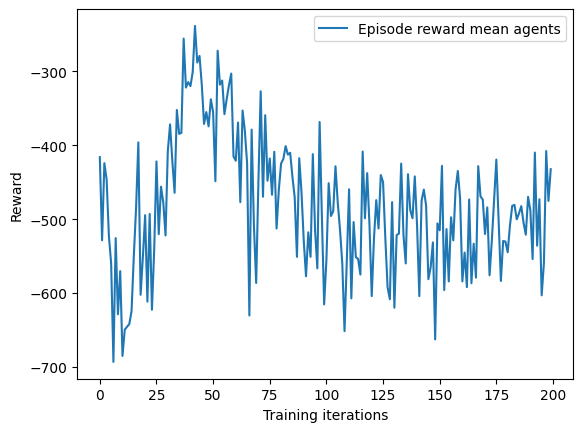

dict_keys(['agents'])


In [ ]:
fig, axs = plt.subplots(1, 1)
for i, group in enumerate(env.group_map.keys()):
    axs.plot(episode_reward_mean_map[group], label=f"Episode reward mean {group}")
    axs.set_ylabel("Reward")
    axs.legend()
axs.set_xlabel("Training iterations")
plt.show()
print(env.group_map.keys())

In [ ]:
if use_vmas and not is_sphinx:
    # Replace tmpdir with any desired path where the video should be saved
    with tempfile.TemporaryDirectory() as tmpdir:
        video_logger = CSVLogger("vmas_logs", tmpdir, video_format="mp4")
        print("Creating rendering env")
        env_with_render = TransformedEnv(env.base_env, env.transform.clone())
        env_with_render = env_with_render.append_transform(
            PixelRenderTransform(
                out_keys=["pixels"],
                # the np.ndarray has a negative stride and needs to be copied before being cast to a tensor
                preproc=lambda x: x.copy(),
                as_non_tensor=True,
                # asking for array rather than on-screen rendering
                mode="rgb_array",
            )
        )
        env_with_render = env_with_render.append_transform(
            VideoRecorder(logger=video_logger, tag="vmas_rendered")
        )
        with set_exploration_type(ExplorationType.DETERMINISTIC):
            print("Rendering rollout...")
            env_with_render.rollout(100, policy=agents_exploration_policy)
        print("Saving the video...")
        env_with_render.transform.dump()
        print("Saved! Saved directory tree:")
        video_logger.print_log_dir()

Creating rendering env
Rendering rollout...


ImportError: Error occurred while running `from pyglet.gl import *`, HINT: make sure you have OpenGL installed. On Ubuntu, you can run 'apt-get install python3-opengl'. If you're running on a server, you may need a virtual frame buffer; something like this should work:'xvfb-run -s "-screen 0 1400x900x24" python <your_script.py>'

In [ ]:
import os

# Define a permanent directory path (e.g., "local_videos")
local_dir = "local_videos"
os.makedirs(local_dir, exist_ok=True)

# Use the permanent directory instead of a temporary one
video_logger = CSVLogger("vmas_logs", local_dir, video_format="mp4")
print("Creating rendering env")
env_with_render = TransformedEnv(env.base_env, env.transform.clone())
env_with_render = env_with_render.append_transform(
    PixelRenderTransform(
        out_keys=["pixels"],
        # the np.ndarray has a negative stride and needs to be copied before being cast to a tensor
        preproc=lambda x: x.copy(),
        as_non_tensor=True,
        # asking for array rather than on-screen rendering
        mode="rgb_array",
    )
)
env_with_render = env_with_render.append_transform(
    VideoRecorder(logger=video_logger, tag="vmas_rendered")
)
with set_exploration_type(ExplorationType.DETERMINISTIC):
    print("Rendering rollout...")
    env_with_render.rollout(100, policy=agents_exploration_policy)
print("Saving the video...")
env_with_render.transform.dump()
print("Saved! Saved directory tree:")
video_logger.print_log_dir()